In [1]:
# Cell 1: Import core libraries and configure the notebook
"""
This cell imports the core Python libraries used throughout the project
and applies a few convenience settings (display options, random seed, etc.).
Run this cell before any other cells in the notebook.
"""

# Standard libraries
import os
from pathlib import Path
import json
import random

# Data handling and numerics
import numpy as np
import pandas as pd

# Basic plotting (will be used later for EDA and model visualizations)
import matplotlib.pyplot as plt

# Machine learning utilities (models will be added later in the notebook)
from sklearn.model_selection import train_test_split

# For nicer DataFrame display in Jupyter
from IPython.display import display

# -------------------------------------------------------------------
# Global configuration
# -------------------------------------------------------------------

# Set a global random seed for reproducibility.
# This will be reused later for train/test splits and model initialization.
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure some pandas display options so tables are easier to read.
pd.set_option("display.max_rows", 10)         # limit number of rows shown
pd.set_option("display.max_columns", 50)     # show more columns when inspecting
pd.set_option("display.width", 120)          # wider console output

# Configure matplotlib defaults 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Environment initialized. Random seed set to", RANDOM_SEED)


# Directory for saving figure outputs
FIG_DIR = Path("../graphs")
FIG_DIR.mkdir(parents=True, exist_ok=True)


Environment initialized. Random seed set to 42


In [2]:
# Cell 2: Define dataset path and helper functions
"""
This cell defines the path to the recipes dataset and small utility
functions that will be useful throughout the notebook.
Adjust DATA_PATH below if your CSV file lives in a different folder.
"""

# Path to the Extended Recipes Dataset CSV.
DATA_PATH = Path("../data/recipes_extended.csv")


def check_dataset_exists(path: Path) -> None:
    """
    Check that the dataset file exists at the given path.
    Raises a FileNotFoundError with a helpful message if not found.
    """
    if not path.exists():
        raise FileNotFoundError(
            f"Could not find dataset at {path.resolve()}.\n"
            "Please check that:\n"
            "  1) The CSV file is downloaded, and\n"
            "  2) DATA_PATH in this cell points to the correct location."
        )

def parse_json_list_string(s):
    """
    Parse a JSON-like string representing a list into a Python list.

    Many columns in the recipes dataset (e.g. 'ingredients', 'cuisine_list')
    are stored in the CSV as strings that look like:
        '["item1", "item2", "item3"]'

    This helper:
      - Returns [] for missing/NaN/empty strings.
      - If it's already a list, returns it unchanged.
      - Otherwise, attempts json.loads to convert to a Python list.
      - If parsing fails, wraps the original value in a one-element list.
    """
    # Handle missing values cleanly
    if pd.isna(s):
        return []
    # If the value is already a Python list, nothing to do
    if isinstance(s, list):
        return s
    # Ensure we are working with a stripped string
    s = str(s).strip()
    if s == "":
        return []
    # Try to parse as JSON
    try:
        parsed = json.loads(s)
        # If parsing worked and produced a list, return it
        if isinstance(parsed, list):
            return parsed
        # If it produced something else (e.g., a dict), wrap it in a list
        return [parsed]
    except Exception:
        # Fallback: return a one-element list containing the raw string
        return [s]

print("DATA_PATH set to:", DATA_PATH.resolve())
check_dataset_exists(DATA_PATH)
print("Dataset file found.")


DATA_PATH set to: C:\Users\dylan\Desktop\School Stuff\Data Science Foundations\IndividualProject\data\recipes_extended.csv
Dataset file found.


In [3]:
# Cell 3: Load the Extended Recipes Dataset into a DataFrame
"""
This cell loads the Extended Recipes Dataset (64K dishes) from disk
into a pandas DataFrame named `recipes_df`. It also performs basic
sanity checks: shape, column names, and a few example rows.

In addition, it removes near-duplicate recipes that appear multiple
times with identical core content (same title, canonical ingredients,
and directions) but different category metadata. This de-duplication
helps avoid over-counting the same recipe in EDA and downstream models.
"""

# Ensure the file exists before attempting to read
check_dataset_exists(DATA_PATH)

# Read the CSV. low_memory=False avoids mixed-type warnings on large CSVs.
recipes_df = pd.read_csv(DATA_PATH, low_memory=False)

print("Dataset loaded successfully.")

# -------------------------------------------------------------------
# NEW: De-duplicate near-identical recipes
# -------------------------------------------------------------------
print(f"Number of rows (recipes) BEFORE de-duplication: {recipes_df.shape[0]:,}")

# Use core structural fields to identify duplicates:
#   - recipe_title             : recipe name
#   - ingredients_canonical    : normalized ingredient list
#   - directions_text          : normalized directions text
dedup_subset = ["recipe_title", "ingredients_canonical", "directions_text"]

missing = [c for c in dedup_subset if c not in recipes_df.columns]
if missing:
    # Fallback: if some expected columns are missing, fall back to title-only de-dup
    print(f"[Warning] Could not find columns {missing} for de-duplication.")
    print("          Falling back to dropping duplicates based on 'recipe_title' only.")
    if "recipe_title" in recipes_df.columns:
        recipes_df = recipes_df.drop_duplicates(subset=["recipe_title"], keep="first")
    else:
        print("[Warning] 'recipe_title' column is also missing; skipping de-duplication.")
else:
    recipes_df = recipes_df.drop_duplicates(subset=dedup_subset, keep="first")

print(f"Number of rows (recipes) AFTER de-duplication:  {recipes_df.shape[0]:,}")
print()  # blank line for readability

# -------------------------------------------------------------------
# Basic sanity checks on the (now de-duplicated) dataset
# -------------------------------------------------------------------
print(f"Number of columns: {recipes_df.shape[1]}")

print("\nFirst 3 rows (truncated):")
display(recipes_df.head(3))

print("\nColumn names:")
print(list(recipes_df.columns))

print("\nBasic info:")
recipes_df.info()


Dataset loaded successfully.
Number of rows (recipes) BEFORE de-duplication: 62,126
Number of rows (recipes) AFTER de-duplication:  25,020

Number of columns: 38

First 3 rows (truncated):


recipe_title           category        subcategory  \
0         Air Fryer Potato Slices with Dipping Sauce  Air Fryer Recipes  Air Fryer Recipes   
1                         Gochujang Pork Belly Bites  Air Fryer Recipes  Air Fryer Recipes   
2  3-Ingredient Air Fryer Everything Bagel Chicke...  Air Fryer Recipes  Air Fryer Recipes   

                                         description                                        ingredients  \
0  These air fryer potato slices, served with a b...  ["3/4 cup ketchup", "1/2 cup beer", "1 tablesp...   
1  These gochujang pork belly bites are sweet and...  ["1 pound pork belly", "1/4 cup gochujang", "2...   
2  These 3-ingredient air fryer everything bagel ...  ["1 ¼ pounds chicken tenders", "1 tablespoon o...   

                                          directions  num_ingredients  num_steps  \
0  ["Combine ketchup, beer, Worcestershire sauce,...                9          5   
1  ["Preheat an air fryer to 400 degrees F (200 d...                5          4   
2  ["Gather all ingredients. Preheat an air fryer...                3          4   

                                     ingredient_text                                    directions_text  \
0  ketchup beer worcestershire sauce onion powder...  combine ketchup, beer, worcestershire sauce, o...   
1  pound pork belly gochujang soy sauce honey gro...  preheat an air fryer to 400 degrees f (200 deg...   
2  ¼ pounds chicken tenders olive oil everything ...  gather all ingredients. preheat an air fryer t...   

                                       combined_text                                    ingredients_raw  \
0  air fryer potato slices with dipping sauce air...  ["3/4 cup ketchup", "1/2 cup beer", "1 tablesp...   
1  gochujang pork belly bites air fryer recipes a...  ["1 pound pork belly", "1/4 cup gochujang", "2...   
2  3-ingredient air fryer everything bagel chicke...  ["1 ¼ pounds chicken tenders", "1 tablespoon o...   

                                      directions_raw                              ingredients_canonical  \
0  ["Combine ketchup, beer, Worcestershire sauce,...  ["ketchup", "beer", "worcestershire sauce", "o...   
1  ["Preheat an air fryer to 400 degrees F (200 d...  ["pound pork belly", "gochujang", "soy sauce",...   
2  ["Gather all ingredients. Preheat an air fryer...  ["¼ pounds chicken tenders", "olive oil", "eve...   

                                        cuisine_list  course_list                                 tastes  \
0  ["american", "american_region", "asian", "euro...    ["sauce"]          ["spicy", "bitter", "savory"]   
1  ["asian", "chinese", "filipino", "japanese", "...  ["unknown"]  ["sweet", "spicy", "savory", "umami"]   
2  ["european", "greek", "mediterranean", "middle...  ["unknown"]                    ["spicy", "savory"]   

  primary_taste secondary_taste  fast_hits  slow_hits  medium_hits cook_speed  est_prep_time_min  est_cook_time_min  \
0         spicy          savory          6          2            7     medium                 23                 74   
1         sweet           spicy          7          0            6       fast                 18                 42   
2         spicy          savory          7          0            6       fast                 15                 42   

  difficulty  is_vegan  is_vegetarian  is_halal  is_kosher  is_nut_free  is_dairy_free  is_gluten_free  \
0       hard      True           True     False       True         True           True            True   
1     medium     False          False     False      False         True           True            True   
2     medium     False          False      True       True         True           True            True   

                                  dietary_profile  healthiness_score                              health_flags  \
0  ["vegan", "gluten_free", "nut_free", "kosher"]                 80  ["plant_based", "healthy_fats", "fried"]   
1                     ["gluten_free", "nut_free


Column names:
['recipe_title', 'category', 'subcategory', 'description', 'ingredients', 'directions', 'num_ingredients', 'num_steps', 'ingredient_text', 'directions_text', 'combined_text', 'ingredients_raw', 'directions_raw', 'ingredients_canonical', 'cuisine_list', 'course_list', 'tastes', 'primary_taste', 'secondary_taste', 'fast_hits', 'slow_hits', 'medium_hits', 'cook_speed', 'est_prep_time_min', 'est_cook_time_min', 'difficulty', 'is_vegan', 'is_vegetarian', 'is_halal', 'is_kosher', 'is_nut_free', 'is_dairy_free', 'is_gluten_free', 'dietary_profile', 'healthiness_score', 'health_flags', 'main_ingredient', 'health_level']

Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 25020 entries, 0 to 62032
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   recipe_title           25020 non-null  object
 1   category               25020 non-null  object
 2   subcategory            25020 non-null  

In [4]:
# Cell 4: Initial preprocessing of key text and list-like columns
"""
This cell performs lightweight preprocessing to make later analysis and modeling easier.

Steps:
  1. Ensure key text fields (`ingredient_text`, `directions_text`, `combined_text`)
     are strings with no missing values (fill NaN with empty strings).
  2. Parse "list-like" columns stored as JSON strings (e.g., '["a", "b"]')
     into actual Python lists using `parse_json_list_string`.
  3. Run simple checks to confirm the transformations look correct.

This does NOT perform any heavy feature engineering yet; it only prepares a clean
starting point for exploratory data analysis and model building.
"""

# Work on a copy to avoid accidental mutations of the original raw DataFrame
recipes = recipes_df.copy()

# -------------------------------------------------------------------
# 1. Normalize key text columns
# -------------------------------------------------------------------

TEXT_COLUMNS = ["ingredient_text", "directions_text", "combined_text", "description"]

for col in TEXT_COLUMNS:
    if col in recipes.columns:
        # Fill missing values with empty strings and ensure type is string
        recipes[col] = recipes[col].fillna("").astype(str)
    else:
        # If a column is unexpectedly missing, log a warning (but do not crash)
        print(f"[Warning] Expected text column '{col}' not found in dataset.")

# -------------------------------------------------------------------
# 2. Parse list-like columns (JSON string -> Python list)
# -------------------------------------------------------------------

LIST_COLUMNS = [
    "ingredients",        # list of ingredient strings
    "directions",         # list of direction step strings
    "cuisine_list",       # list of cuisine tags
    "course_list",        # list of course tags
    "tastes",             # list of taste tags (e.g., sweet, savory)
    "dietary_profile",    # list of dietary labels
    "health_flags"        # list of health-related flags
]

for col in LIST_COLUMNS:
    if col in recipes.columns:
        # Apply the helper function to every cell in the column
        recipes[col] = recipes[col].apply(parse_json_list_string)
    else:
        print(f"[Warning] Expected list-like column '{col}' not found in dataset.")

# -------------------------------------------------------------------
# 3. Quick sanity checks on the parsed columns
# -------------------------------------------------------------------

print("\nSample of parsed 'ingredients' and 'cuisine_list' for the first 2 recipes:")
for idx in range(2):
    print(f"\nRecipe index {idx}: {recipes.loc[idx, 'recipe_title']}")
    print("  Number of ingredients:", len(recipes.loc[idx, "ingredients"]))
    print("  First few ingredients:", recipes.loc[idx, "ingredients"][:3])
    print("  Cuisines:", recipes.loc[idx, "cuisine_list"])

# Show a compact summary of missing values for a few key columns
key_cols = [
    "recipe_title",
    "ingredient_text",
    "directions_text",
    "combined_text",
    "primary_taste",
    "difficulty",
    "est_prep_time_min",
    "est_cook_time_min"
]

print("\nMissing values in key columns:")
print(recipes[key_cols].isna().sum())

# Store the cleaned DataFrame under a clear name for later cells
recipes_clean = recipes

print("\nInitial preprocessing complete. `recipes_clean` is ready for EDA and modeling.")



Sample of parsed 'ingredients' and 'cuisine_list' for the first 2 recipes:

Recipe index 0: Air Fryer Potato Slices with Dipping Sauce
  Number of ingredients: 9
  First few ingredients: ['3/4 cup ketchup', '1/2 cup beer', '1 tablespoon Worcestershire sauce']
  Cuisines: ['american', 'american_region', 'asian', 'european', 'greek', 'korean', 'mediterranean', 'middle eastern region']

Recipe index 1: Gochujang Pork Belly Bites
  Number of ingredients: 5
  First few ingredients: ['1 pound pork belly', '1/4 cup gochujang', '2 tablespoons soy sauce']
  Cuisines: ['asian', 'chinese', 'filipino', 'japanese', 'korean']

Missing values in key columns:
recipe_title         0
ingredient_text      0
directions_text      0
combined_text        0
primary_taste        0
difficulty           0
est_prep_time_min    0
est_cook_time_min    0
dtype: int64

Initial preprocessing complete. `recipes_clean` is ready for EDA and modeling.


In [5]:
# Cell 5: Basic EDA – dataset overview, key numeric summaries, and combined taste distribution
"""
This cell performs a basic exploratory overview of the cleaned recipes dataset.

Steps:
  1. Confirm that `recipes_clean` exists and inspect its shape.
  2. Show summary statistics for key numeric fields (ingredients, steps, times, healthiness).
  3. Compute and display a combined taste distribution using both `primary_taste`
     and `secondary_taste`, treating values like 'none' as missing.
  4. Display value counts for a few important categorical fields (difficulty, cook_speed).
"""

# -------------------------------------------------------------------
# 0. Safety check: ensure `recipes_clean` is available
# -------------------------------------------------------------------
if "recipes_clean" not in globals():
    raise NameError(
        "`recipes_clean` was not found. Please run the earlier preprocessing cells "
        "before executing this EDA cell."
    )

df = recipes_clean  # shorthand alias

# -------------------------------------------------------------------
# Helper: combined taste series from primary_taste + secondary_taste
# -------------------------------------------------------------------
def get_combined_taste_series(df_in: pd.DataFrame) -> pd.Series:
    """
    Build a single Series of taste labels using both `primary_taste` and `secondary_taste`.

    Rules:
      - Use both columns if present.
      - Strip whitespace and treat '', 'none', 'None', and obvious 'nan' strings as missing.
      - Drop missing values.
      - Return a flat Series of taste strings (no duplicates removed).
    """
    required = ["primary_taste", "secondary_taste"]
    for col in required:
        if col not in df_in.columns:
            raise KeyError(
                f"Column '{col}' is required for combined taste analysis but was not found."
            )

    tastes = []
    for col in required:
        s = df_in[col].astype(str).str.strip()
        s = s.replace(
            {
                "": pd.NA,
                "none": pd.NA,
                "None": pd.NA,
                "nan": pd.NA,
                "NaN": pd.NA,
            }
        )
        tastes.append(s)

    combined = pd.concat(tastes, ignore_index=True)
    combined = combined.dropna()

    return combined

# -------------------------------------------------------------------
# 1. Basic shape and a quick peek
# -------------------------------------------------------------------
print(f"Cleaned dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# -------------------------------------------------------------------
# 2. Summary statistics for key numeric columns
# -------------------------------------------------------------------
numeric_cols = [
    "num_ingredients",
    "num_steps",
    "est_prep_time_min",
    "est_cook_time_min",
    "healthiness_score",
]

numeric_cols_present = [c for c in numeric_cols if c in df.columns]

print("Summary statistics for key numeric columns:")
display(df[numeric_cols_present].describe().T)

# -------------------------------------------------------------------
# 3. Combined taste distribution (primary_taste + secondary_taste)
# -------------------------------------------------------------------
try:
    combined_tastes = get_combined_taste_series(df)
    taste_counts = combined_tastes.value_counts()

    print("\nCombined taste distribution (using primary_taste + secondary_taste, excluding 'none'):")
    display(taste_counts.to_frame("count"))
except KeyError as e:
    print(f"\n[Warning] Could not compute combined taste distribution: {e}")

# -------------------------------------------------------------------
# 4. Quick value counts for other important categoricals
# -------------------------------------------------------------------
cat_cols = ["difficulty", "cook_speed"]

for col in cat_cols:
    if col in df.columns:
        print(f"\nTop categories for '{col}':")
        display(df[col].value_counts(dropna=False).head(10))
    else:
        print(f"\n[Warning] Column '{col}' not found in dataset.")


Cleaned dataset shape: 25,020 rows × 38 columns

Summary statistics for key numeric columns:


count       mean        std   min   25%   50%   75%    max
num_ingredients    25020.0   9.026659   3.811410   1.0   6.0   9.0  11.0   35.0
num_steps          25020.0   4.320943   2.174755   1.0   3.0   4.0   5.0   25.0
est_prep_time_min  25020.0  19.736331   8.041674   2.0  14.0  19.0  24.0   67.0
est_cook_time_min  25020.0  50.898361  32.742838   3.0  28.0  44.0  67.0  301.0
healthiness_score  25020.0  65.278737  12.096426  16.0  58.0  66.0  74.0  100.0


Combined taste distribution (using primary_taste + secondary_taste, excluding 'none'):


count
savory   19397
sweet    15440
spicy     7357
umami     5090
sour      1125
bitter     161
neutral     38


Top categories for 'difficulty':


difficulty
medium    14376
hard       8376
easy       2268
Name: count, dtype: int64


Top categories for 'cook_speed':


cook_speed
fast      19242
medium     5343
slow        435
Name: count, dtype: int64

In [6]:
# Cell 6: Define a reusable color palette and axis styling helper
"""
This cell defines:
  - A reusable list of distinct colors
  - A helper function to apply consistent styling to matplotlib axes.

These helpers are used for all subsequent plots to keep the EDA visuals
colorful, readable, and stylistically consistent.
"""

import matplotlib.pyplot as plt

# 15 distinct colors
COLOR_LIST = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#17becf", "#393b79",
    "#6b6ecf", "#b15928", "#1b9e77", "#7570b3", "#e7298a",
]

def style_axes(ax, title, xlabel, ylabel):
    """
    Apply consistent styling to a matplotlib Axes object:
      - Bold, slightly larger title and axis labels
      - Slightly larger, bold tick labels
      - Light grid
    """
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=13, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=13, fontweight="bold")
    
    # Tick labels – slightly bigger + bold
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(11)
        label.set_fontweight("bold")
    
    ax.grid(alpha=0.3)


Combined taste distribution (primary_taste + secondary_taste):


count
savory   19397
sweet    15440
spicy     7357
umami     5090
sour      1125
bitter     161
neutral     38

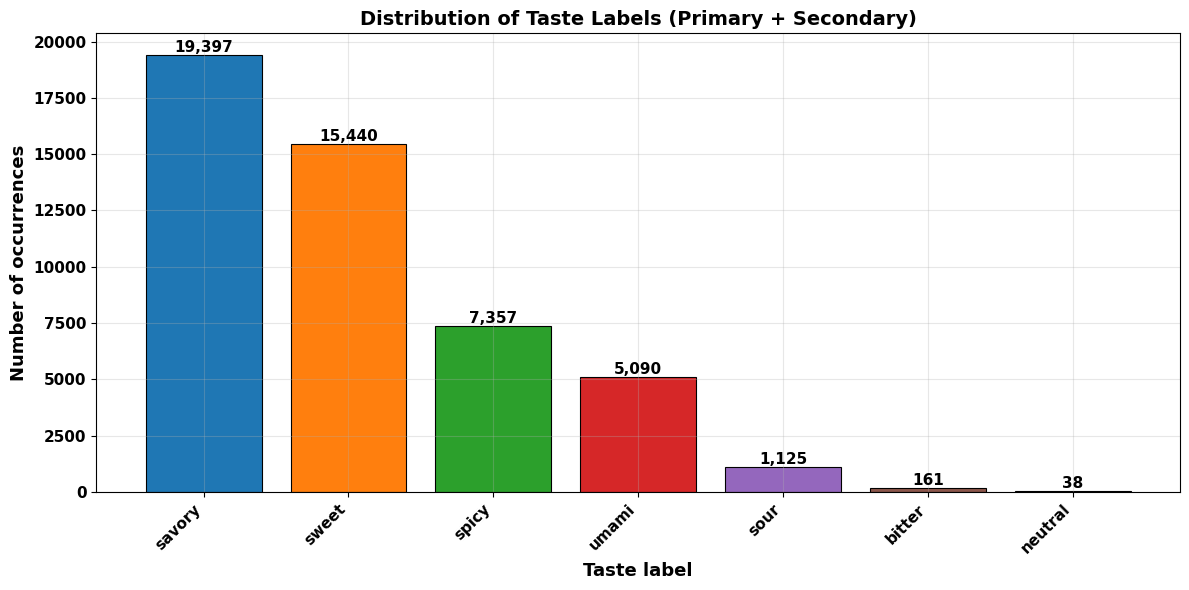

In [7]:
# Cell 7: Distribution of taste labels (primary_taste + secondary_taste)
"""
This cell explores how recipes are distributed across taste labels,
using BOTH `primary_taste` and `secondary_taste`.

Rules:
  - Values like 'none', '', and obvious 'nan' strings are treated as missing.
  - Each occurrence in either column contributes to the overall counts.
  - A colorful bar chart is plotted with one bar per taste label.
"""

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run preprocessing cells first.")

df = recipes_clean  # shorthand alias

# -------------------------------------------------------------------
# 1. Compute combined taste counts using helper from Cell 5
# -------------------------------------------------------------------
try:
    combined_tastes = get_combined_taste_series(df)
except NameError:
    raise NameError(
        "Function `get_combined_taste_series` not found. "
        "Please re-run Cell 5 before running this cell."
    )

taste_counts = combined_tastes.value_counts()

print("Combined taste distribution (primary_taste + secondary_taste):")
display(taste_counts.to_frame("count"))

# -------------------------------------------------------------------
# 2. Prepare bar chart data
# -------------------------------------------------------------------
tastes = taste_counts.index.tolist()
counts = taste_counts.values

# Choose colors for the bars from COLOR_LIST (re-use or cycle if needed)
colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(tastes))]

# -------------------------------------------------------------------
# 3. Plot bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(tastes, counts, color=colors, edgecolor="k", linewidth=0.8)

# Explicitly set tick positions to avoid set_ticklabels warning
x_positions = np.arange(len(tastes))
ax.set_xticks(x_positions)
ax.set_xticklabels(tastes, rotation=45, ha="right", fontsize=11, fontweight="bold")

# Annotate each bar with its count
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(count):,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Apply consistent styling
style_axes(
    ax,
    title="Distribution of Taste Labels (Primary + Secondary)",
    xlabel="Taste label",
    ylabel="Number of occurrences",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_1_Distribution_of_Taste_Labels_Primary_Secondary.png", dpi=300, bbox_inches="tight")
plt.show()

Difficulty distribution:


count
difficulty       
medium      14376
hard         8376
easy         2268

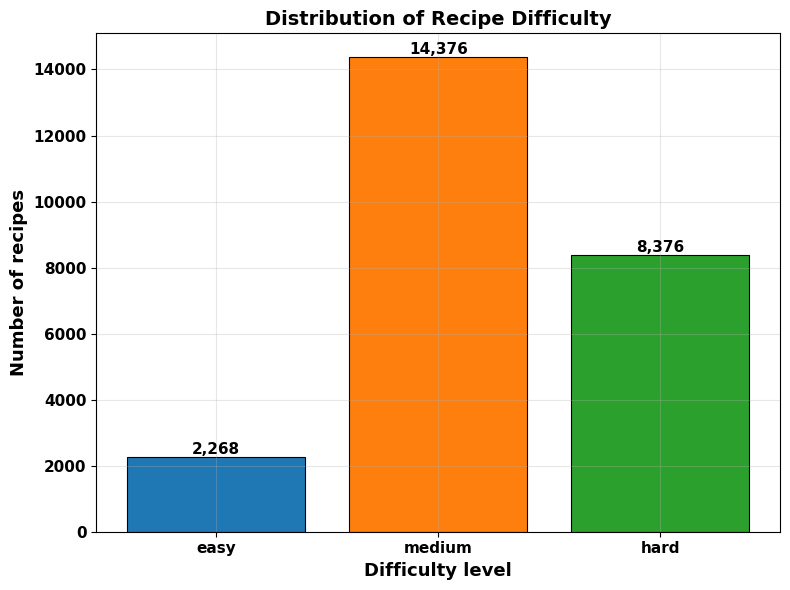

In [8]:
# Cell 8: Distribution of difficulty levels
"""
This cell examines how recipes are distributed across difficulty levels
(easy, medium, hard).

Steps:
  1. Compute value counts for `difficulty`, dropping missing values.
  2. Plot a colorful bar chart in a similar style to the primary taste chart.
  3. Annotate each bar with its count.
"""

if "difficulty" not in df.columns:
    raise KeyError("Column 'difficulty' not found in the dataset.")

# -------------------------------------------------------------------
# 1. Compute difficulty counts
# -------------------------------------------------------------------
difficulty_series = df["difficulty"].replace("", pd.NA)
difficulty_counts = difficulty_series.dropna().value_counts()

print("Difficulty distribution:")
display(difficulty_counts.to_frame("count"))

# Enforce a logical ordering if present
difficulty_order = ["easy", "medium", "hard"]
ordered_index = [d for d in difficulty_order if d in difficulty_counts.index]
for d in difficulty_counts.index:
    if d not in ordered_index:
        ordered_index.append(d)

difficulty_counts = difficulty_counts.loc[ordered_index]

levels = difficulty_counts.index.tolist()
counts = difficulty_counts.values

colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(levels))]

# -------------------------------------------------------------------
# 2. Plot bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(levels, counts, color=colors, edgecolor="k", linewidth=0.8)

# Annotate each bar with its count
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(count):,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

style_axes(
    ax,
    title="Distribution of Recipe Difficulty",
    xlabel="Difficulty level",
    ylabel="Number of recipes",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_2_Distribution_of_Recipe_Difficulty.png", dpi=300, bbox_inches="tight")
plt.show()

Non-missing counts:
  num_ingredients: 25,020
  num_steps:       25,020


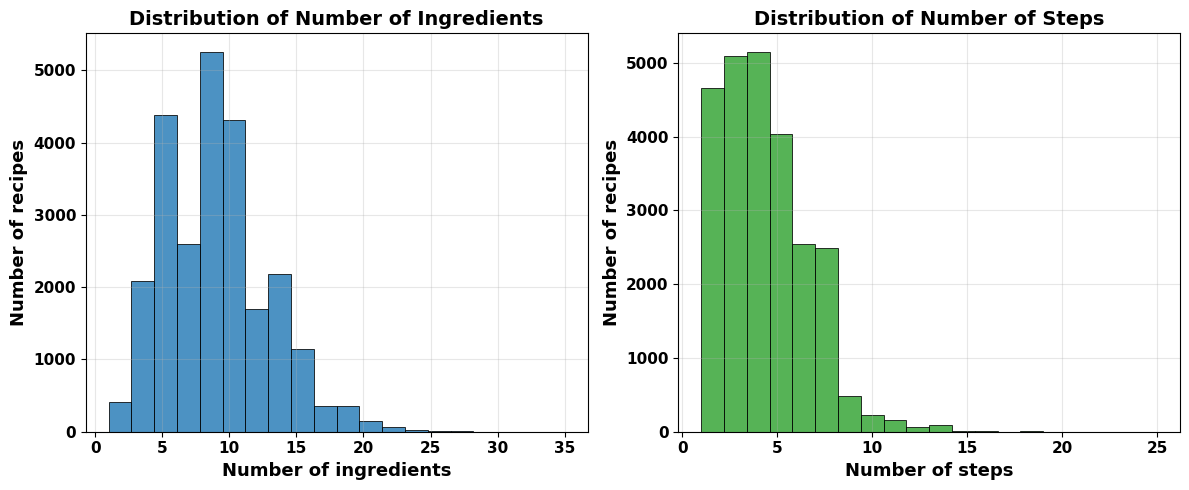

In [9]:
# Cell 9: Numeric distributions – number of ingredients and steps
"""
This cell visualizes the distributions of two core structural variables:

  - Number of ingredients
  - Number of steps

These give a sense of how complex recipes tend to be in terms of length
and structure.
"""

# Helper to create a nicely styled histogram
def plot_histogram(ax, data, bins, color, title, xlabel):
    """
    Plot a single histogram on `ax` with a consistent visual style.
    """
    ax.hist(data, bins=bins, color=color, edgecolor="k", linewidth=0.7, alpha=0.8)
    style_axes(ax, title=title, xlabel=xlabel, ylabel="Number of recipes")

# -------------------------------------------------------------------
# Extract data, dropping missing values
# -------------------------------------------------------------------
n_ing = df["num_ingredients"].dropna() if "num_ingredients" in df.columns else pd.Series(dtype=float)
n_steps = df["num_steps"].dropna() if "num_steps" in df.columns else pd.Series(dtype=float)

# Basic sanity prints
print("Non-missing counts:")
print(f"  num_ingredients: {n_ing.shape[0]:,}")
print(f"  num_steps:       {n_steps.shape[0]:,}")

# -------------------------------------------------------------------
# Raw distributions for numeric counts (ingredients, steps)
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_histogram(
    axes[0],
    n_ing,
    bins=20,
    color=COLOR_LIST[0],
    title="Distribution of Number of Ingredients",
    xlabel="Number of ingredients",
)

plot_histogram(
    axes[1],
    n_steps,
    bins=20,
    color=COLOR_LIST[2],
    title="Distribution of Number of Steps",
    xlabel="Number of steps",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_3_Distribution_of_Number_of_Steps.png", dpi=300, bbox_inches="tight")
plt.show()

Non-missing counts:
  est_prep_time_min: 25,020
  est_cook_time_min: 25,020

Basic summary (prep time in minutes):


prep_time
count  25020.000000
mean      19.736331
std        8.041674
min        2.000000
50%       19.000000
75%       24.000000
90%       31.000000
95%       35.000000
99%       43.000000
max       67.000000


Basic summary (cook time in minutes):


cook_time
count  25020.000000
mean      50.898361
std       32.742838
min        3.000000
50%       44.000000
75%       67.000000
90%       94.000000
95%      113.000000
99%      158.000000
max      301.000000

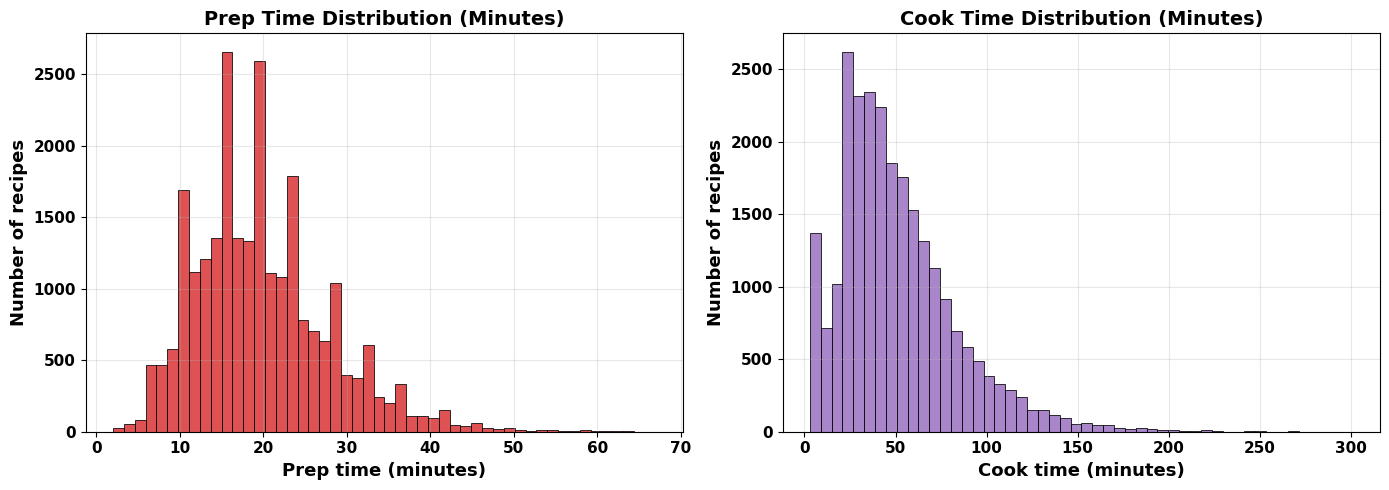

In [10]:
# Cell 10: Numeric distributions – prep and cook time (raw minutes)
"""
This cell visualizes the distributions of time-related variables:

  - Estimated preparation time (minutes)
  - Estimated cooking time (minutes)

These are plotted in **raw minutes** (no logarithm), so very long recipes
will appear as outliers to the right. The figure width and number of bins
are chosen to make the skewed distributions as readable as possible.
"""

# -------------------------------------------------------------------
# Extract data, dropping missing values
# -------------------------------------------------------------------
prep = df["est_prep_time_min"].dropna() if "est_prep_time_min" in df.columns else pd.Series(dtype=float)
cook = df["est_cook_time_min"].dropna() if "est_cook_time_min" in df.columns else pd.Series(dtype=float)

print("Non-missing counts:")
print(f"  est_prep_time_min: {prep.shape[0]:,}")
print(f"  est_cook_time_min: {cook.shape[0]:,}")

print("\nBasic summary (prep time in minutes):")
display(prep.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).to_frame("prep_time"))

print("\nBasic summary (cook time in minutes):")
display(cook.describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).to_frame("cook_time"))

# -------------------------------------------------------------------
# Histograms for raw prep and cook time
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_histogram(
    axes[0],
    prep,
    bins=50,
    color=COLOR_LIST[3],
    title="Prep Time Distribution (Minutes)",
    xlabel="Prep time (minutes)",
)

plot_histogram(
    axes[1],
    cook,
    bins=50,
    color=COLOR_LIST[4],
    title="Cook Time Distribution (Minutes)",
    xlabel="Cook time (minutes)",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_4_Cook_Time_Distribution_Minutes.png", dpi=300, bbox_inches="tight")
plt.show()

Sample of combined taste–difficulty rows:


recipe_id difficulty     taste_role  taste
0          0       hard  primary_taste  spicy
1          1     medium  primary_taste  sweet
2          2     medium  primary_taste  spicy
3          3       hard  primary_taste  sweet
4          4     medium  primary_taste  sweet


Combined taste × difficulty (counts):


difficulty  easy  medium  hard
taste                         
savory      1238   11833  6326
sweet       1636    8603  5201
spicy        326    3715  3316
umami        543    3126  1421
sour         513     474   138
bitter        93      48    20
neutral        9      24     5


Combined taste × difficulty (row-wise %):


difficulty  easy  medium  hard
taste                         
savory       6.4    61.0  32.6
sweet       10.6    55.7  33.7
spicy        4.4    50.5  45.1
umami       10.7    61.4  27.9
sour        45.6    42.1  12.3
bitter      57.8    29.8  12.4
neutral     23.7    63.2  13.2

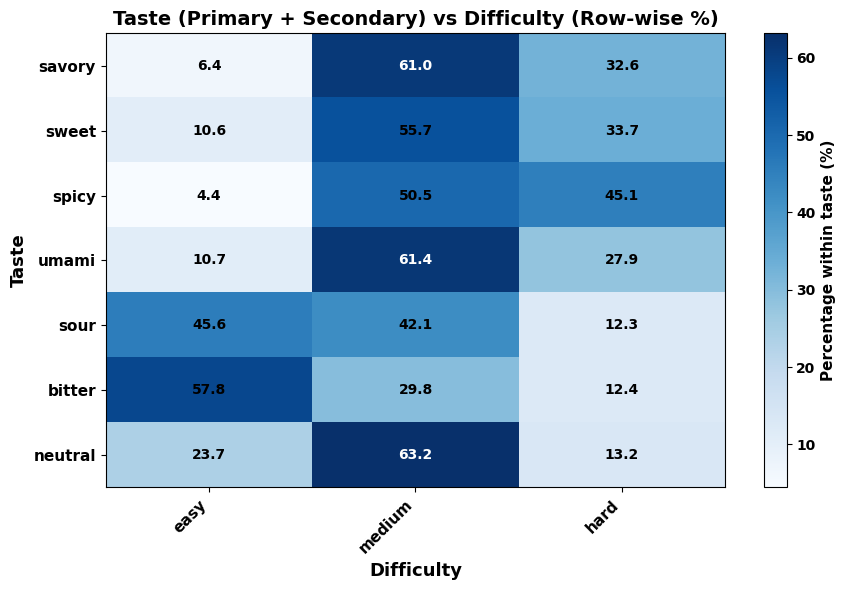

In [11]:
# Cell 11: Relationship between combined taste (primary+secondary) and difficulty (heatmap)
"""
This cell explores how recipe difficulty varies across taste labels,
using BOTH `primary_taste` and `secondary_taste`.

Steps:
  1. Build a long-form table where each recipe contributes one row per
     non-missing taste (from primary_taste and secondary_taste).
     Values like 'none' are treated as missing.
  2. Build a contingency table of `taste` × `difficulty`.
  3. Convert raw counts into row-wise percentages (within each taste).
  4. Reorder difficulty columns as easy → medium → hard (when present).
  5. Visualize the percentages as a heatmap (using a non-yellow colormap).
"""

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run preprocessing cells first.")

df = recipes_clean  # shorthand alias

required_cols = ["primary_taste", "secondary_taste", "difficulty"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' is required but not found in the dataset.")

# -------------------------------------------------------------------
# 1. Build long-form taste table (one row per recipe-taste pair)
# -------------------------------------------------------------------
sub = df[["primary_taste", "secondary_taste", "difficulty"]].copy()

# Clean difficulty
sub["difficulty"] = sub["difficulty"].replace("", pd.NA)
sub = sub.dropna(subset=["difficulty"])

# Attach a recipe_id based on the index to allow de-duplication if needed
sub["recipe_id"] = sub.index

# Melt primary_taste and secondary_taste into a single 'taste' column
taste_long = sub.melt(
    id_vars=["recipe_id", "difficulty"],
    value_vars=["primary_taste", "secondary_taste"],
    var_name="taste_role",
    value_name="taste",
)

# Clean taste values
taste_long["taste"] = taste_long["taste"].astype(str).str.strip()
taste_long["taste"] = taste_long["taste"].replace(
    {
        "": pd.NA,
        "none": pd.NA,
        "None": pd.NA,
        "nan": pd.NA,
        "NaN": pd.NA,
    }
)

# Drop missing tastes
taste_long = taste_long.dropna(subset=["taste"])

# Optional: drop exact duplicates (same recipe, same difficulty, same taste)
taste_long = taste_long.drop_duplicates(subset=["recipe_id", "difficulty", "taste"])

print("Sample of combined taste–difficulty rows:")
display(taste_long.head())

# -------------------------------------------------------------------
# 2. Build contingency table taste × difficulty
# -------------------------------------------------------------------
ct = pd.crosstab(
    taste_long["taste"],
    taste_long["difficulty"]
)

# Sort tastes by total count (descending) to make the heatmap more informative
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

# -------------------------------------------------------------------
# 3. Reorder difficulty columns: easy → medium → hard
# -------------------------------------------------------------------
desired_order = ["easy", "medium", "hard"]
ordered_cols = [d for d in desired_order if d in ct.columns] + [
    c for c in ct.columns if c not in desired_order
]

ct = ct[ordered_cols]

# Row-normalized percentages
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

print("\nCombined taste × difficulty (counts):")
display(ct)

print("\nCombined taste × difficulty (row-wise %):")
display(ct_pct.round(1))

# -------------------------------------------------------------------
# 4. Plot heatmap (row-wise %)
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))

im = ax.imshow(ct_pct.values, cmap="Blues", aspect="auto")

# Axis ticks and labels
ax.set_xticks(range(ct_pct.shape[1]))
ax.set_yticks(range(ct_pct.shape[0]))
ax.set_xticklabels(ct_pct.columns, fontsize=11, fontweight="bold", rotation=45, ha="right")
ax.set_yticklabels(ct_pct.index, fontsize=11, fontweight="bold")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percentage within taste (%)", fontsize=11, fontweight="bold")
for tick in cbar.ax.get_yticklabels():
    tick.set_fontsize(10)
    tick.set_fontweight("bold")

# Annotate each cell with % value
for i in range(ct_pct.shape[0]):
    for j in range(ct_pct.shape[1]):
        val = ct_pct.iloc[i, j]
        ax.text(
            j,
            i,
            f"{val:.1f}",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black" if val < 60 else "white",
        )

ax.set_title("Taste (Primary + Secondary) vs Difficulty (Row-wise %)", fontsize=14, fontweight="bold")
ax.set_xlabel("Difficulty", fontsize=13, fontweight="bold")
ax.set_ylabel("Taste", fontsize=13, fontweight="bold")

ax.grid(False)
plt.tight_layout()
plt.savefig(FIG_DIR / "figure_5_Taste_Primary_Secondary_vs_Difficulty_Row_wise.png", dpi=300, bbox_inches="tight")
plt.show()

Number of recipes with non-missing difficulty and times: 25020

Clipping prep time at 99th percentile ≈ 43.0 minutes
Clipping cook time at 99th percentile ≈ 158.0 minutes


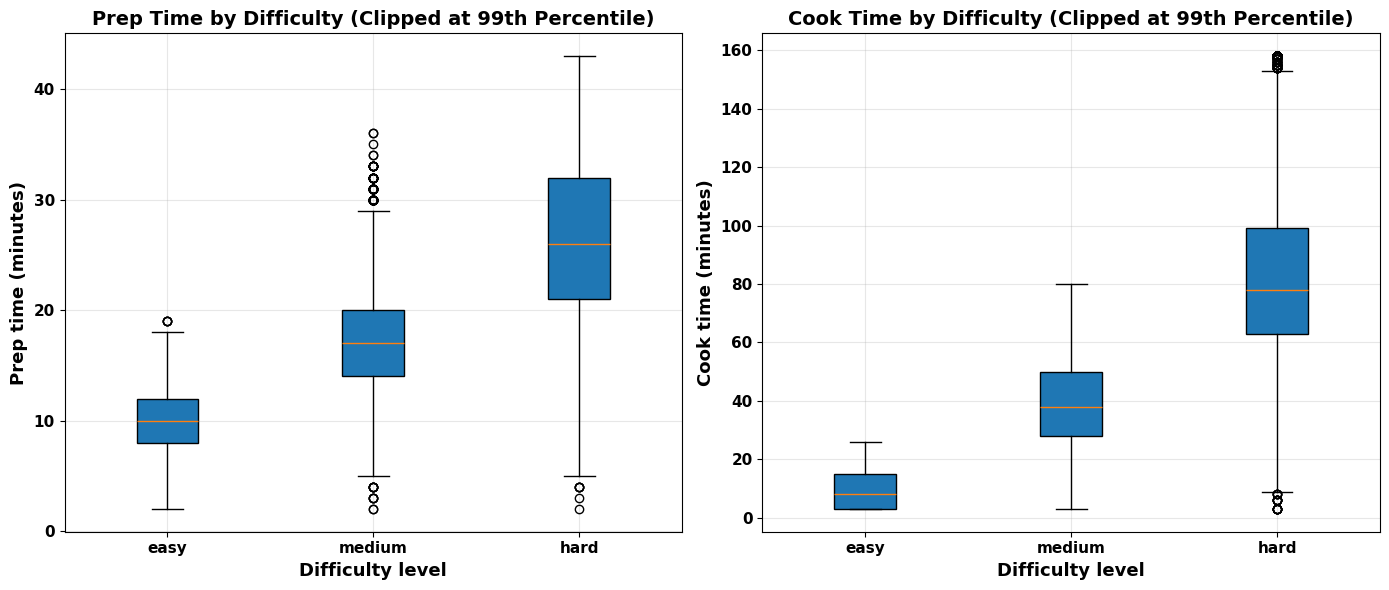

In [12]:
# Cell 12: Prep and cook time by difficulty (boxplots)
"""
This cell examines how estimated preparation and cooking times vary
across difficulty levels.

Steps:
  1. Construct a working DataFrame with difficulty, prep time, and cook time.
  2. Optionally clip times at the 99th percentile to keep boxplots readable.
  3. Plot side-by-side boxplots for prep and cook time by difficulty.
"""

required_cols = ["difficulty", "est_prep_time_min", "est_cook_time_min"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' is required but not found in the dataset.")

# -------------------------------------------------------------------
# 1. Build working DataFrame, dropping missing/empty difficulty
# -------------------------------------------------------------------
time_df = df[required_cols].copy()
time_df["difficulty"] = time_df["difficulty"].replace("", pd.NA)
time_df = time_df.dropna(subset=["difficulty", "est_prep_time_min", "est_cook_time_min"])

# Enforce difficulty order if present
difficulty_order = ["easy", "medium", "hard"]
present_levels = [d for d in difficulty_order if d in time_df["difficulty"].unique()]
if not present_levels:
    present_levels = sorted(time_df["difficulty"].unique().tolist())

time_df["difficulty"] = pd.Categorical(time_df["difficulty"], categories=present_levels, ordered=True)

print("Number of recipes with non-missing difficulty and times:", len(time_df))

# -------------------------------------------------------------------
# 2. Optional clipping at 99th percentile to make plots readable
# -------------------------------------------------------------------
prep_99 = time_df["est_prep_time_min"].quantile(0.99)
cook_99 = time_df["est_cook_time_min"].quantile(0.99)

time_df["prep_clipped"] = time_df["est_prep_time_min"].clip(upper=prep_99)
time_df["cook_clipped"] = time_df["est_cook_time_min"].clip(upper=cook_99)

print(f"\nClipping prep time at 99th percentile ≈ {prep_99:.1f} minutes")
print(f"Clipping cook time at 99th percentile ≈ {cook_99:.1f} minutes")

# -------------------------------------------------------------------
# 3. Boxplots by difficulty
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prep time
prep_data = [time_df.loc[time_df["difficulty"] == level, "prep_clipped"] for level in present_levels]
axes[0].boxplot(
    prep_data,
    tick_labels=present_levels,   # updated: use tick_labels instead of labels
    patch_artist=True,
)

# Color the boxes
for patch, color in zip(axes[0].artists, [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(present_levels))]):
    patch.set_facecolor(color)
    patch.set_edgecolor("k")

style_axes(
    axes[0],
    title="Prep Time by Difficulty (Clipped at 99th Percentile)",
    xlabel="Difficulty level",
    ylabel="Prep time (minutes)",
)

# Cook time
cook_data = [time_df.loc[time_df["difficulty"] == level, "cook_clipped"] for level in present_levels]
axes[1].boxplot(
    cook_data,
    tick_labels=present_levels,   # updated here too
    patch_artist=True,
)

for patch, color in zip(axes[1].artists, [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(present_levels))]):
    patch.set_facecolor(color)
    patch.set_edgecolor("k")

style_axes(
    axes[1],
    title="Cook Time by Difficulty (Clipped at 99th Percentile)",
    xlabel="Difficulty level",
    ylabel="Cook time (minutes)",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_6_Cook_Time_by_Difficulty_Clipped_at_99th_Percentile.png", dpi=300, bbox_inches="tight")
plt.show()

Top 15 cuisines by recipe count:


count
cuisine_list                
european               19175
french                 13066
asian                  11884
middle eastern region   9659
korean                  7843
...                      ...
thai                    3224
caribbean               3092
american                2963
turkish                 2793
chinese                 2702

[15 rows x 1 columns]

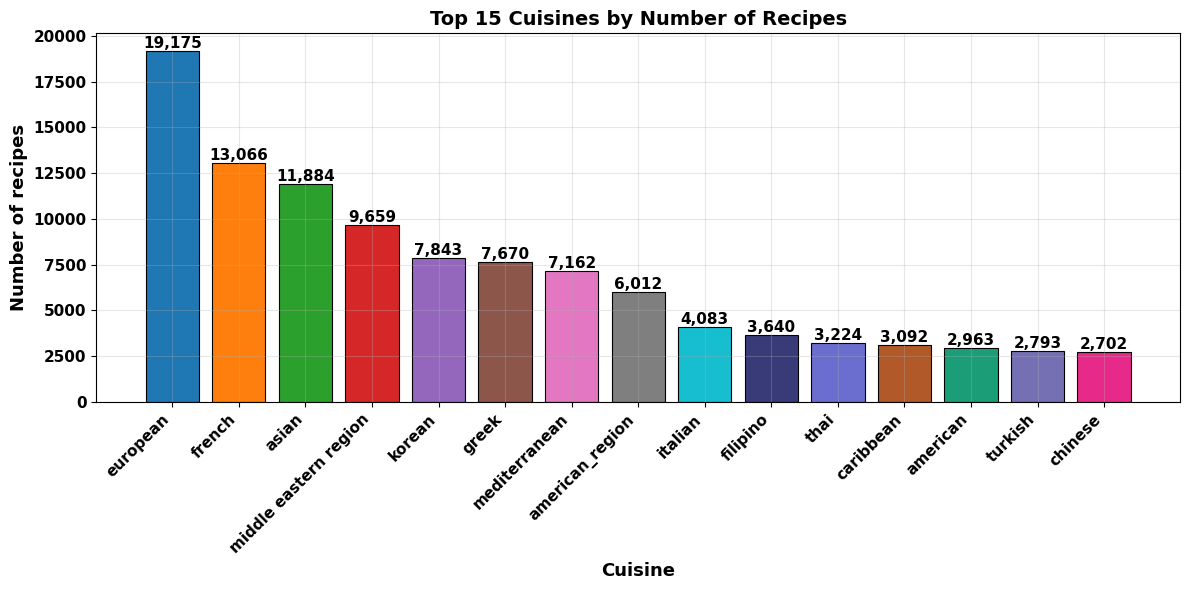

In [13]:
# Cell 13: Top cuisines by recipe count (bar chart)
"""
This cell explores which cuisines are most represented in the dataset.

Steps:
  1. Explode the `cuisine_list` column so each cuisine tag gets its own row.
  2. Count recipes per cuisine and select the top N.
  3. Plot a colorful bar chart with counts annotated.
"""

if "cuisine_list" not in df.columns:
    raise KeyError("Column 'cuisine_list' not found in the dataset.")

# -------------------------------------------------------------------
# 1. Explode cuisine_list so each cuisine has its own row
# -------------------------------------------------------------------
cuisine_exploded = df[["recipe_title", "cuisine_list"]].copy()

# Ensure `cuisine_list` is actually a list for each row (should be from preprocessing)
def _ensure_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    return parse_json_list_string(x)

cuisine_exploded["cuisine_list"] = cuisine_exploded["cuisine_list"].apply(_ensure_list)

# Explode into one row per cuisine tag
cuisine_exploded = cuisine_exploded.explode("cuisine_list")
cuisine_exploded["cuisine_list"] = cuisine_exploded["cuisine_list"].replace("", pd.NA)

# Drop missing/blank cuisines
cuisine_exploded = cuisine_exploded.dropna(subset=["cuisine_list"])

# -------------------------------------------------------------------
# 2. Count cuisines and take top N
# -------------------------------------------------------------------
cuisine_counts = cuisine_exploded["cuisine_list"].value_counts()
TOP_N = 15
top_cuisines = cuisine_counts.head(TOP_N)

print(f"Top {TOP_N} cuisines by recipe count:")
display(top_cuisines.to_frame("count"))

cuisines = top_cuisines.index.tolist()
counts = top_cuisines.values
colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(cuisines))]

# -------------------------------------------------------------------
# 3. Plot bar chart (Steam-style)
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(cuisines, counts, color=colors, edgecolor="k", linewidth=0.8)

# Explicitly set tick positions and labels to avoid set_ticklabels warning
x_positions = np.arange(len(cuisines))
ax.set_xticks(x_positions)
ax.set_xticklabels(cuisines, rotation=45, ha="right", fontsize=11, fontweight="bold")

# Annotate each bar with its count
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(count):,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

style_axes(
    ax,
    title=f"Top {TOP_N} Cuisines by Number of Recipes",
    xlabel="Cuisine",
    ylabel="Number of recipes",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_7_Top_TOP_N_Cuisines_by_Number_of_Recipes.png", dpi=300, bbox_inches="tight")
plt.show()

Scatter plot will use 5,000 points.


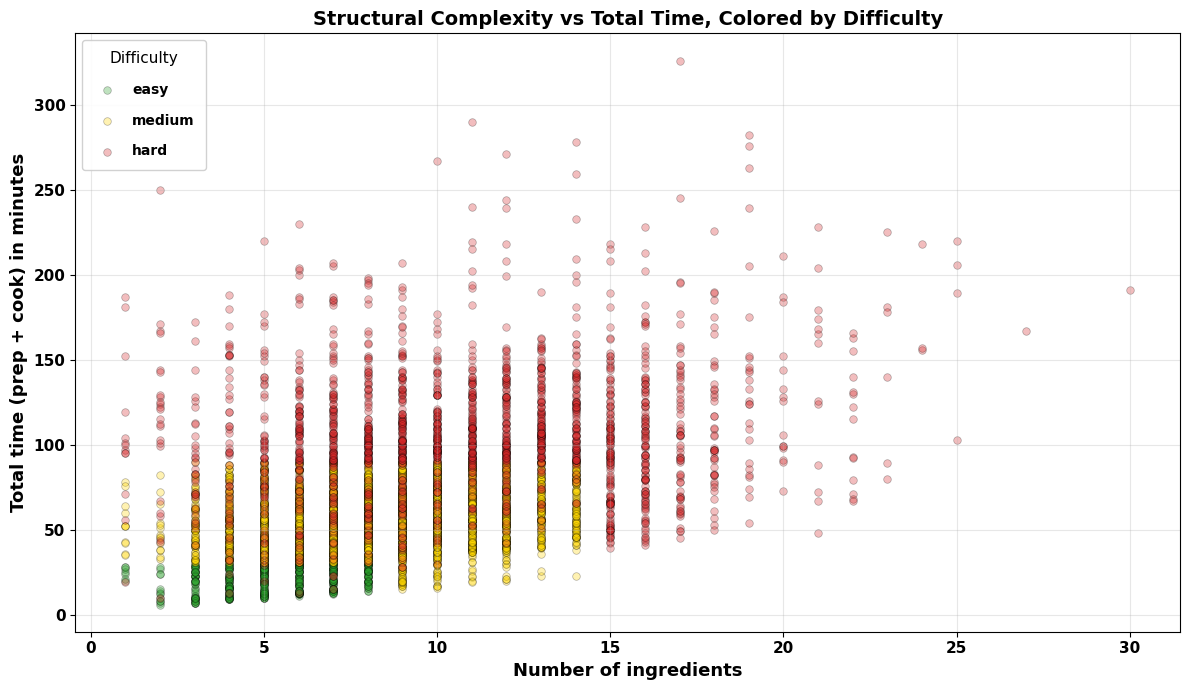

In [14]:
# Cell 14: Structural complexity vs total time (scatter, colored by difficulty)
"""
This cell looks at how structural complexity (number of ingredients and steps)
relates to total time, and how this relates to difficulty.

Steps:
  1. Create a `total_time_min` feature as prep + cook time.
  2. Build a working DataFrame with num_ingredients, num_steps, total_time, difficulty.
  3. Subsample to a manageable size for plotting (e.g., 5,000 recipes).
  4. Create a scatter plot of num_ingredients vs total_time, colored by difficulty
     (easy = green, medium = yellow, hard = red).
"""

required_cols = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min", "difficulty"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' is required but not found in the dataset.")

# -------------------------------------------------------------------
# 1. Create total_time_min
# -------------------------------------------------------------------
struct_df = df[required_cols].copy()
struct_df["difficulty"] = struct_df["difficulty"].replace("", pd.NA)

# Drop rows with missing difficulty or times
struct_df = struct_df.dropna(
    subset=["difficulty", "num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
)

struct_df["total_time_min"] = struct_df["est_prep_time_min"] + struct_df["est_cook_time_min"]

# -------------------------------------------------------------------
# 2. Subsample to keep plot readable
# -------------------------------------------------------------------
MAX_POINTS = 5000
if struct_df.shape[0] > MAX_POINTS:
    struct_df_sampled = struct_df.sample(n=MAX_POINTS, random_state=RANDOM_SEED)
else:
    struct_df_sampled = struct_df

print(f"Scatter plot will use {struct_df_sampled.shape[0]:,} points.")

# Define fixed color mapping for difficulty
difficulty_levels = ["easy", "medium", "hard"]
present_levels = [d for d in difficulty_levels if d in struct_df_sampled["difficulty"].unique()]
if not present_levels:
    present_levels = sorted(struct_df_sampled["difficulty"].unique().tolist())

difficulty_to_color = {
    "easy":  "#2ca02c",  # green
    "medium": "#FFD700", # yellow/gold
    "hard":  "#d62728",  # red
}

fig, ax = plt.subplots(figsize=(12, 7))

# -------------------------------------------------------------------
# 3. Scatter plot: num_ingredients vs total_time, colored by difficulty
# -------------------------------------------------------------------
for level in present_levels:
    subset = struct_df_sampled[struct_df_sampled["difficulty"] == level]
    ax.scatter(
        subset["num_ingredients"],
        subset["total_time_min"],
        s=30,
        alpha=0.3,
        edgecolor="k",
        linewidth=0.5,
        color=difficulty_to_color.get(level, "#7f7f7f"),  # fallback gray
        label=level,
    )

style_axes(
    ax,
    title="Structural Complexity vs Total Time, Colored by Difficulty",
    xlabel="Number of ingredients",
    ylabel="Total time (prep + cook) in minutes",
)

# Legend
legend = ax.legend(
    title="Difficulty",
    loc="upper left",
    borderaxespad=0.5,
    labelspacing=1.2,
    borderpad=0.8,
    markerscale=1.0,
    prop={"size": 10, "weight": "bold"},
    title_fontsize=11,
)
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_8_Difficulty.png", dpi=300, bbox_inches="tight")
plt.show()

# Beginning preparation and training of the model to predict taste, difficulty, and cook time

# Taste prediction

In [15]:
# Cell 15: Prepare multi-label modeling dataset for taste prediction
"""
This cell prepares a clean subset of the recipes dataset for predicting taste
from text features, treating each recipe as potentially having multiple tastes.

Targets:
  - A set of taste labels per recipe, drawn from both `primary_taste` and `secondary_taste`.
    Values like 'none' / blank / NaN are treated as missing and ignored.

Features:
  - `combined_text` (preprocessed combination of ingredients + directions).

Steps:
  1. Clean `primary_taste` and `secondary_taste` and construct a list of tastes per recipe.
  2. Remove recipes with no valid tastes.
  3. Optionally drop very rare tastes (below a minimum sample threshold) to keep modeling stable.
  4. Build a modeling DataFrame with columns:
        - 'text'         : input text
        - 'taste_labels' : list of taste strings (multi-label target)
"""

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run preprocessing cells first.")

df = recipes_clean  # shorthand alias

required_cols = ["primary_taste", "secondary_taste", "combined_text"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' is required for this modeling task but not found.")

def _clean_taste_value(s: str):
    """
    Normalize a raw taste value into either a cleaned string or NaN.

    Rules:
      - Cast to string, strip whitespace.
      - Treat '', 'none', 'None', 'nan', 'NaN' as missing.
    """
    s = str(s).strip()
    if s in {"", "none", "None", "nan", "NaN"}:
        return pd.NA
    return s

# -------------------------------------------------------------------
# 1. Build a list of tastes per recipe from primary + secondary
# -------------------------------------------------------------------
model_df = df.copy()

model_df["primary_taste_clean"] = model_df["primary_taste"].apply(_clean_taste_value)
model_df["secondary_taste_clean"] = model_df["secondary_taste"].apply(_clean_taste_value)

def _combine_tastes(row):
    """
    Combine primary and secondary tastes into a unique list per recipe,
    dropping any missing values.
    """
    tastes = []
    if pd.notna(row["primary_taste_clean"]):
        tastes.append(row["primary_taste_clean"])
    if pd.notna(row["secondary_taste_clean"]):
        tastes.append(row["secondary_taste_clean"])
    # Remove duplicates while preserving order
    return list(dict.fromkeys(tastes))

model_df["taste_labels"] = model_df.apply(_combine_tastes, axis=1)

# Remove recipes with no valid tastes at all
model_df = model_df[model_df["taste_labels"].map(len) > 0]

print(f"Recipes with at least one valid taste (primary+secondary): {model_df.shape[0]:,} "
      f"out of {df.shape[0]:,}")

# -------------------------------------------------------------------
# 2. Optionally drop very rare tastes
# -------------------------------------------------------------------
# Flatten all tastes to count frequencies
all_tastes_flat = [t for tastes in model_df["taste_labels"] for t in tastes]
taste_counts = pd.Series(all_tastes_flat).value_counts()

print("\nTaste counts before filtering rare classes (using primary+secondary):")
display(taste_counts.to_frame("count"))

MIN_SAMPLES_PER_TASTE = 10  # min number of occurrences required per taste label

major_tastes = taste_counts[taste_counts >= MIN_SAMPLES_PER_TASTE].index.tolist()
print(f"\nKeeping tastes with at least {MIN_SAMPLES_PER_TASTE} occurrences:")
print(major_tastes)

def _filter_taste_list(taste_list):
    return [t for t in taste_list if t in major_tastes]

model_df["taste_labels"] = model_df["taste_labels"].apply(_filter_taste_list)

# Drop recipes that lost all labels after filtering
model_df = model_df[model_df["taste_labels"].map(len) > 0]

print(f"\nModeling dataset size after filtering rare tastes: {model_df.shape[0]:,} recipes")

# Recompute taste counts after filtering
all_tastes_flat_filtered = [t for tastes in model_df["taste_labels"] for t in tastes]
taste_counts_filtered = pd.Series(all_tastes_flat_filtered).value_counts()

print("\nTaste counts after filtering rare classes:")
display(taste_counts_filtered.to_frame("count"))

# -------------------------------------------------------------------
# 3. Build final modeling DataFrame with 'text' and 'taste_labels'
# -------------------------------------------------------------------
TEXT_COL = "combined_text"
model_df[TEXT_COL] = model_df[TEXT_COL].fillna("").astype(str)

taste_model_df = model_df[[TEXT_COL, "taste_labels"]].rename(
    columns={TEXT_COL: "text"}
)

print("\nFinal multi-label taste modeling DataFrame preview:")
display(taste_model_df.head(5))

print(f"\nTaste modeling DataFrame shape: {taste_model_df.shape[0]:,} rows × {taste_model_df.shape[1]} columns")


Recipes with at least one valid taste (primary+secondary): 25,020 out of 25,020

Taste counts before filtering rare classes (using primary+secondary):


count
savory   19397
sweet    15440
spicy     7357
umami     5090
sour      1125
bitter     161
neutral     38


Keeping tastes with at least 10 occurrences:
['savory', 'sweet', 'spicy', 'umami', 'sour', 'bitter', 'neutral']

Modeling dataset size after filtering rare tastes: 25,020 recipes

Taste counts after filtering rare classes:


count
savory   19397
sweet    15440
spicy     7357
umami     5090
sour      1125
bitter     161
neutral     38


Final multi-label taste modeling DataFrame preview:


text     taste_labels
0  air fryer potato slices with dipping sauce air...  [spicy, savory]
1  gochujang pork belly bites air fryer recipes a...   [sweet, spicy]
2  3-ingredient air fryer everything bagel chicke...  [spicy, savory]
3  air fryer everything bagel chicken cutlets air...   [sweet, spicy]
4  air fryer honey sriracha salmon bites air frye...   [sweet, spicy]


Taste modeling DataFrame shape: 25,020 rows × 2 columns


In [16]:
# Cell 16: Multi-label taste prediction model (TF–IDF + One-vs-Rest Logistic Regression)
"""
This cell trains a multi-label supervised model to predict taste sets from text.

Model:
  - Pipeline: TF–IDF vectorizer + One-vs-Rest Logistic Regression.
    - TF–IDF converts text into sparse numeric vectors.
    - One-vs-Rest trains one binary Logistic Regression classifier per taste label.

Setup:
  - Each recipe is represented by a list of tastes (taste_labels).
  - MultiLabelBinarizer converts these into a multi-hot label matrix Y of shape (n_samples, n_classes).

Steps:
  1. Build the multi-label targets using MultiLabelBinarizer.
  2. Train/test split on text + multi-label targets.
  3. Build a scikit-learn Pipeline with TfidfVectorizer and OneVsRestClassifier(LogisticRegression).
  4. Fit the model and evaluate with micro/macro F1, precision, recall, and per-class metrics.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

if "taste_model_df" not in globals():
    raise NameError(
        "`taste_model_df` not found. Please run Cell 15 before this modeling cell."
    )

# -------------------------------------------------------------------
# 1. Build multi-label targets
# -------------------------------------------------------------------
X_text = taste_model_df["text"].values
y_labels = taste_model_df["taste_labels"].values  # each entry is a list of taste strings

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y_labels)   # shape: (n_samples, n_classes)

print("Taste classes (multi-label):", mlb.classes_)
print("Label matrix shape:", Y.shape)

# -------------------------------------------------------------------
# 2. Train/test split (note: stratified splitting is non-trivial for multi-label,
#    so a simple random split is used here).
# -------------------------------------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(
    X_text,
    Y,
    test_size=0.20,
    random_state=RANDOM_SEED,
)

print(f"Training set size: {X_train.shape[0]:,}")
print(f"Test set size:     {X_test.shape[0]:,}")

# -------------------------------------------------------------------
# 3. Build TF–IDF + One-vs-Rest Logistic Regression pipeline
# -------------------------------------------------------------------
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=5,
    max_df=0.9,
)

base_logreg = LogisticRegression(
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",
    solver="lbfgs",
    random_state=RANDOM_SEED,
)

ovr_clf = OneVsRestClassifier(base_logreg, n_jobs=-1)

taste_clf = Pipeline(
    steps=[
        ("tfidf", tfidf),
        ("clf", ovr_clf),
    ]
)

# -------------------------------------------------------------------
# 4. Fit the model
# -------------------------------------------------------------------
print("\nFitting multi-label TF–IDF + One-vs-Rest Logistic Regression taste model...")
taste_clf.fit(X_train, Y_train)
print("Model training complete.")

# -------------------------------------------------------------------
# 5. Evaluate on the test set
# -------------------------------------------------------------------
Y_pred = taste_clf.predict(X_test)

# Micro-averaged metrics (global across all labels)
micro_precision = precision_score(Y_test, Y_pred, average="micro", zero_division=0)
micro_recall = recall_score(Y_test, Y_pred, average="micro", zero_division=0)
micro_f1 = f1_score(Y_test, Y_pred, average="micro", zero_division=0)

# Macro-averaged metrics (average of label-wise scores)
macro_precision = precision_score(Y_test, Y_pred, average="macro", zero_division=0)
macro_recall = recall_score(Y_test, Y_pred, average="macro", zero_division=0)
macro_f1 = f1_score(Y_test, Y_pred, average="macro", zero_division=0)

print("\nMulti-label test performance:")
print(f"  Micro-averaged  Precision: {micro_precision:.4f}")
print(f"  Micro-averaged  Recall:    {micro_recall:.4f}")
print(f"  Micro-averaged  F1-score:  {micro_f1:.4f}")
print(f"  Macro-averaged  Precision: {macro_precision:.4f}")
print(f"  Macro-averaged  Recall:    {macro_recall:.4f}")
print(f"  Macro-averaged  F1-score:  {macro_f1:.4f}")

print("\nPer-class classification report:")
print(
    classification_report(
        Y_test,
        Y_pred,
        target_names=mlb.classes_,
        digits=3,
        zero_division=0,
    )
)


Taste classes (multi-label): ['bitter' 'neutral' 'savory' 'sour' 'spicy' 'sweet' 'umami']
Label matrix shape: (25020, 7)
Training set size: 20,016
Test set size:     5,004

Fitting multi-label TF–IDF + One-vs-Rest Logistic Regression taste model...
Model training complete.

Multi-label test performance:
  Micro-averaged  Precision: 0.8787
  Micro-averaged  Recall:    0.8853
  Micro-averaged  F1-score:  0.8820
  Macro-averaged  Precision: 0.6048
  Macro-averaged  Recall:    0.7874
  Macro-averaged  F1-score:  0.6504

Per-class classification report:
              precision    recall  f1-score   support

      bitter      0.159     0.619     0.252        21
     neutral      0.125     0.500     0.200         4
      savory      0.943     0.876     0.909      3917
        sour      0.477     0.830     0.606       229
       spicy      0.920     0.937     0.928      1503
       sweet      0.985     0.885     0.932      3045
       umami      0.625     0.865     0.725      1014

   micro av

Per-taste metrics (sorted by F1):


taste_label  precision    recall        f1  support
5       sweet   0.984649  0.884729  0.932019     3045
4       spicy   0.920261  0.936793  0.928454     1503
2      savory   0.943132  0.876436  0.908562     3917
6       umami   0.624644  0.864892  0.725393     1014
3        sour   0.477387  0.829694  0.606061      229
0      bitter   0.158537  0.619048  0.252427       21
1     neutral   0.125000  0.500000  0.200000        4

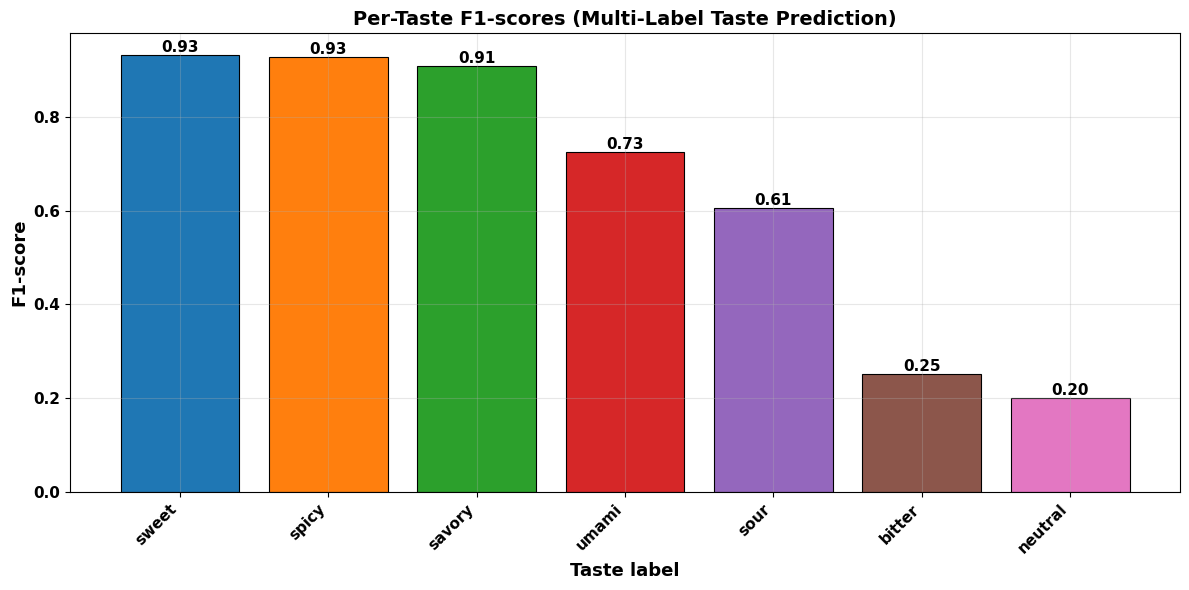

In [17]:
# Cell 17: Per-taste F1-scores (multi-label evaluation bar chart)
"""
This cell visualizes how well the model performs on each taste label, using
F1-scores per class in a bar chart.

Steps:
  1. Compute precision, recall, F1, and support per taste label.
  2. Build a DataFrame summarizing per-label metrics.
  3. Plot a colorful bar chart of F1-scores per taste label.
"""

from sklearn.metrics import precision_recall_fscore_support

if "Y_test" not in globals() or "Y_pred" not in globals() or "mlb" not in globals():
    raise NameError(
        "Variables `Y_test`, `Y_pred`, or `mlb` not found. "
        "Please run Cell 16 before this evaluation cell."
    )

prec, rec, f1, support = precision_recall_fscore_support(
    Y_test,
    Y_pred,
    average=None,
    zero_division=0,
)

metrics_df = pd.DataFrame(
    {
        "taste_label": mlb.classes_,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": support,
    }
).sort_values("f1", ascending=False)

print("Per-taste metrics (sorted by F1):")
display(metrics_df)

# -------------------------------------------------------------------
# Plot F1-scores per taste label
# -------------------------------------------------------------------
tastes = metrics_df["taste_label"].tolist()
f1_scores = metrics_df["f1"].tolist()
colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(tastes))]

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(tastes, f1_scores, color=colors, edgecolor="k", linewidth=0.8)

# Annotate bars with F1 values
for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Explicit ticks + labels (to avoid warnings)
x_positions = np.arange(len(tastes))
ax.set_xticks(x_positions)
ax.set_xticklabels(tastes, rotation=45, ha="right", fontsize=11, fontweight="bold")

style_axes(
    ax,
    title="Per-Taste F1-scores (Multi-Label Taste Prediction)",
    xlabel="Taste label",
    ylabel="F1-score",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_9_Per_Taste_F1_scores_Multi_Label_Taste_Prediction.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# Cell 18: Top indicative tokens per taste label (multi-label model interpretation)
"""
This cell inspects the learned One-vs-Rest logistic regression classifiers to
identify which tokens (words/phrases) are most indicative of each taste label.

Changes from previous version:
  - Instead of storing all tokens in one long string that can be truncated,
    this version creates separate columns: token_1, token_2, ..., token_15.
  - This makes it easier to see all top tokens for each taste without cutoff.
"""

if "taste_clf" not in globals():
    raise NameError("`taste_clf` not found. Please run Cell 16 before this interpretation cell.")

# Optional: avoid truncating cell contents in Jupyter display
pd.set_option("display.max_colwidth", None)

# Extract fitted components from the pipeline
tfidf = taste_clf.named_steps["tfidf"]
ovr_clf = taste_clf.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
classes = mlb.classes_
estimators = ovr_clf.estimators_

TOP_N = 15  # number of top tokens per taste

rows = []

for class_idx, taste_label in enumerate(classes):
    estimator = estimators[class_idx]
    
    # For LogisticRegression, coef_ has shape (1, n_features) in binary setup
    class_coefs = estimator.coef_[0]
    top_idx = np.argsort(class_coefs)[-TOP_N:][::-1]  # indices of largest weights
    
    top_tokens = feature_names[top_idx]
    top_weights = class_coefs[top_idx]
    
    # Build a row dict with one column per token
    row_dict = {"taste_label": taste_label}
    for rank, (tok, w) in enumerate(zip(top_tokens, top_weights), start=1):
        row_dict[f"token_{rank}"] = f"{tok} ({w:.2f})"
    
    rows.append(row_dict)

top_tokens_df = pd.DataFrame(rows)

# Optionally sort by taste_label to keep output stable
top_tokens_df = top_tokens_df.sort_values("taste_label").reset_index(drop=True)

print(f"Top {TOP_N} indicative tokens per taste label (multi-label One-vs-Rest model):")
display(top_tokens_df)


Top 15 indicative tokens per taste label (multi-label One-vs-Rest model):


taste_label            token_1         token_2            token_3          token_4             token_5  \
0      bitter       beer (10.96)     kale (8.52)      coffee (7.63)     vodka (7.21)          gin (4.64)   
1     neutral       water (5.82)    grams (3.44)        eggs (3.03)  pressure (2.98)      polenta (2.90)   
2      savory      butter (8.80)     salt (7.60)      cheese (4.82)  and salt (4.32)          oil (3.25)   
3        sour       lemon (8.51)    juice (5.90)  buttermilk (5.65)    yogurt (5.58)  lemon juice (4.70)   
4       spicy  seasoning (21.42)  ginger (19.82)    cayenne (12.86)    chili (11.33)       spice (10.28)   
5       sweet      sugar (20.12)    wine (13.47)      sweet (11.56)     honey (9.57)  brown sugar (7.86)   
6       umami        milk (7.97)   cheese (5.31)       cream (4.59)       egg (4.31)     parmesan (3.54)   

                   token_6             token_7               token_8            token_9                token_10  \
0         cocktails (3.95)          ice (3.93)        arugula (3.61)    espresso (3.45)          whiskey (3.39)   
1       almond bark (2.69)  puff pastry (2.49)         squash (2.45)        bark (2.40)        air fryer (2.35)   
2     teaspoon salt (3.04)      walnuts (3.01)           soup (2.79)  cup butter (2.75)       corn syrup (2.54)   
3            orange (4.47)         lime (4.37)      pineapple (3.33)   champagne (3.00)         lemonade (2.79)   
4    cayenne pepper (9.95)        chile (8.90)  pepper flakes (8.12)    jalapeno (7.82)           flakes (7.43)   
5             white (7.27)       nutmeg (6.97)    white sugar (6.95)       apple (6.42)         cinnamon (6.29)   
6  balsamic vinegar (2.83)   and pepper (2.50)       balsamic (2.36)      olives (2.18)  parmesan cheese (2.16)   

           token_11             token_12                  token_13             token_14              token_15  
0    limeade (2.80)         fluid (2.76)          mincemeat (2.61)        drinks (2.54)         brewed (2.51)  
1       puff (2.34)      doughnut (2.28)  natural sweetener (2.27)        truvia (2.27)    gluten free (2.25)  
2      basil (2.41)  cream cheese (2.39)             celery (2.33)    and pepper (2.31)     pinch salt (2.21)  
3     hummus (2.67)     cocktails (2.56)          chickpeas (2.49)   and vinegar (2.43)  white vinegar (2.40)  
4  hot sauce (7.35)        pepper (6.92)           jalapeño (6.73)  chili powder (6.62)  ground ginger (6.33)  
5     cherry (5.81)       coconut (5.53)          pineapple (5.45)    white wine (5.41)          syrup (4.92)  
6   cream of (2.09)         pesto (2.09)                soy (2.02)      mushroom (1.99)   tomato paste (1.97)

# Difficulty prediction

In [19]:
# Cell 19: Prepare modeling dataset for difficulty prediction
"""
This cell prepares a clean subset of the recipes dataset for predicting
difficulty from text features.

Target:
  - `difficulty` (categorical label: e.g., easy, medium, hard).

Features:
  - `combined_text` (preprocessed combination of ingredients + directions).

Steps:
  1. Clean the `difficulty` column (strip whitespace, treat blank/None as missing).
  2. Restrict to the core difficulty levels (easy, medium, hard) if present.
  3. Drop recipes with missing or unsupported difficulty.
  4. Build a modeling DataFrame with:
        - 'text'            : input text
        - 'difficulty_label': target class
"""

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run preprocessing cells first.")

df = recipes_clean  # shorthand alias

# -------------------------------------------------------------------
# 1. Clean difficulty column
# -------------------------------------------------------------------
if "difficulty" not in df.columns:
    raise KeyError("Column 'difficulty' is required for this modeling task but not found.")

difficulty_clean = df["difficulty"].astype(str).str.strip()
difficulty_clean = difficulty_clean.replace(
    {
        "": pd.NA,
        "none": pd.NA,
        "None": pd.NA,
        "nan": pd.NA,
        "NaN": pd.NA,
    }
)

model_df_diff = df.copy()
model_df_diff["difficulty_clean"] = difficulty_clean

# -------------------------------------------------------------------
# 2. Restrict to core difficulty levels if present
# -------------------------------------------------------------------
core_levels = ["easy", "medium", "hard"]
present_levels = [lvl for lvl in core_levels if lvl in difficulty_clean.unique()]

if not present_levels:
    # Fall back to using whatever unique values exist
    present_levels = sorted(difficulty_clean.dropna().unique().tolist())
    print("[Warning] Core difficulty levels (easy, medium, hard) not found.")
    print("Using available difficulty levels instead:", present_levels)
else:
    print("Using difficulty levels:", present_levels)

model_df_diff = model_df_diff[model_df_diff["difficulty_clean"].isin(present_levels)]

# Drop missing
model_df_diff = model_df_diff.dropna(subset=["difficulty_clean"])

print(
    f"Recipes with valid difficulty labels ({', '.join(present_levels)}): "
    f"{model_df_diff.shape[0]:,} out of {df.shape[0]:,}"
)

print("\nDifficulty counts in modeling dataset:")
display(model_df_diff["difficulty_clean"].value_counts().to_frame("count"))

# -------------------------------------------------------------------
# 3. Build the final modeling DataFrame with 'text' and 'difficulty_label'
# -------------------------------------------------------------------
TEXT_COL = "combined_text"
if TEXT_COL not in model_df_diff.columns:
    raise KeyError(
        f"Expected text column '{TEXT_COL}' not found. "
        "Please ensure earlier preprocessing created it."
    )

model_df_diff[TEXT_COL] = model_df_diff[TEXT_COL].fillna("").astype(str)

difficulty_model_df = model_df_diff[[TEXT_COL, "difficulty_clean"]].rename(
    columns={
        TEXT_COL: "text",
        "difficulty_clean": "difficulty_label",
    }
)

print("\nFinal difficulty modeling DataFrame preview:")
display(difficulty_model_df.head(5))

print(
    f"\nDifficulty modeling DataFrame shape: "
    f"{difficulty_model_df.shape[0]:,} rows × {difficulty_model_df.shape[1]} columns"
)


Using difficulty levels: ['easy', 'medium', 'hard']
Recipes with valid difficulty labels (easy, medium, hard): 25,020 out of 25,020

Difficulty counts in modeling dataset:


count
difficulty_clean       
medium            14376
hard               8376
easy               2268


Final difficulty modeling DataFrame preview:


text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      air fryer potato slices with dipping sauce air fryer recipes air fryer recipes 3/4 cup ketchup 1/2 cup beer 1 tablespoon worcestershire sauce 1/2 teaspoon onion powder 1/4 teaspoon cayenne 2 baking potatoes olive oil cooking spray 1/2 teaspoon garlic powder salt and freshly ground black pepper combine ketchup, beer, worcestershire sauce, onion powder, and cayenne in a small saucepan. bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. remove from heat, and cool. cover and store in the refrigerator until ready to use. preheat the air fryer to 400 degrees f (200 degrees c). spray the basket with cooking spray or line with a disposable parchment liner. slice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. spray potatoes with olive oil spray, and sprinkle with garlic powder, salt and pepper. give the potatoes a good stir. place potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they start to crisp up a bit and turn golden brown, 14 to 17 minutes. cooking times can vary depending on the brand and size of the fryer, and you may have to cook in batches. remove from the fryer, and serve with beer ketchup dipping sauce.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        gochujang pork belly bites air fryer recipes air fryer recipes 1 pound pork belly 1/4 cup gochujang 2 tablespoons soy sauce 1 tablespoon honey, 1 teaspoon ground ginger preheat an air fryer to 400 degrees f (200 degrees c). place pork belly pieces in the basket in a single layer, not touching. air fry for 8 to 9 minutes; turn over and air fry for 6 to 7 minutes more. meanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl. remove pork belly from air fryer basket; toss in sauce to coat. return to the air fryer and fry until bites begin to char at the edges, 8 to 11 minutes more. (alternately, you can use sauce only for dipping; in this case, continue to fry without removing bites, until they begin to char, 6 to 7 minutes.)   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     


Difficulty modeling DataFrame shape: 25,020 rows × 2 columns


In [20]:
# Cell 20: Baseline difficulty prediction model (TF–IDF + Logistic Regression)
"""
This cell trains a baseline supervised model to predict recipe difficulty
(easy/medium/hard) from text.

Model:
  - Pipeline: TF–IDF vectorizer + Logistic Regression.
    - TF–IDF converts text into sparse numeric vectors.
    - Logistic Regression estimates a probability distribution over difficulty labels.

Steps:
  1. Split the difficulty modeling DataFrame into train and test sets
     (stratified by difficulty).
  2. Build a scikit-learn Pipeline with:
       - TfidfVectorizer
       - LogisticRegression
  3. Fit the model on the training data.
  4. Evaluate on the test data using accuracy and a classification report.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

if "difficulty_model_df" not in globals():
    raise NameError(
        "`difficulty_model_df` not found. Please run Cell 19 before this modeling cell."
    )

# -------------------------------------------------------------------
# 1. Extract features and labels, then stratified train/test split
# -------------------------------------------------------------------
X_diff = difficulty_model_df["text"].values
y_diff = difficulty_model_df["difficulty_label"].values

X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(
    X_diff,
    y_diff,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y_diff,   # preserve class proportions
)

print(f"Training set size: {len(X_train_diff):,}")
print(f"Test set size:     {len(X_test_diff):,}")

# -------------------------------------------------------------------
# 2. Build TF–IDF + Logistic Regression pipeline
# -------------------------------------------------------------------
tfidf_diff = TfidfVectorizer(
    ngram_range=(1, 2),     # unigrams + bigrams
    min_df=5,               # ignore extremely rare tokens
    max_df=0.9,             # ignore super-common tokens
)

# Note: multi_class argument is omitted to avoid FutureWarning.
# Newer sklearn versions default to multinomial when appropriate.
logreg_diff = LogisticRegression(
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",   # mitigate class imbalance across difficulty levels
    solver="lbfgs",
    random_state=RANDOM_SEED,
)

difficulty_clf = Pipeline(
    steps=[
        ("tfidf", tfidf_diff),
        ("logreg", logreg_diff),
    ]
)

# -------------------------------------------------------------------
# 3. Fit the model
# -------------------------------------------------------------------
print("\nFitting TF–IDF + Logistic Regression difficulty model...")
difficulty_clf.fit(X_train_diff, y_train_diff)
print("Model training complete.")

# -------------------------------------------------------------------
# 4. Evaluate on the test set
# -------------------------------------------------------------------
y_pred_diff = difficulty_clf.predict(X_test_diff)

test_accuracy_diff = accuracy_score(y_test_diff, y_pred_diff)
print(f"\nTest accuracy (difficulty prediction): {test_accuracy_diff:.4f}")

print("\nClassification report (per-difficulty precision/recall/F1):")
print(classification_report(y_test_diff, y_pred_diff, digits=3))


Training set size: 20,016
Test set size:     5,004

Fitting TF–IDF + Logistic Regression difficulty model...
Model training complete.

Test accuracy (difficulty prediction): 0.8070

Classification report (per-difficulty precision/recall/F1):
              precision    recall  f1-score   support

        easy      0.626     0.855     0.723       454
        hard      0.768     0.850     0.806      1675
      medium      0.880     0.775     0.824      2875

    accuracy                          0.807      5004
   macro avg      0.758     0.826     0.784      5004
weighted avg      0.819     0.807     0.809      5004



Normalized confusion matrix for difficulty (%):


easy  medium  hard
easy    85.5    14.5   0.0
medium   7.5    77.5  15.0
hard     0.9    14.1  85.0

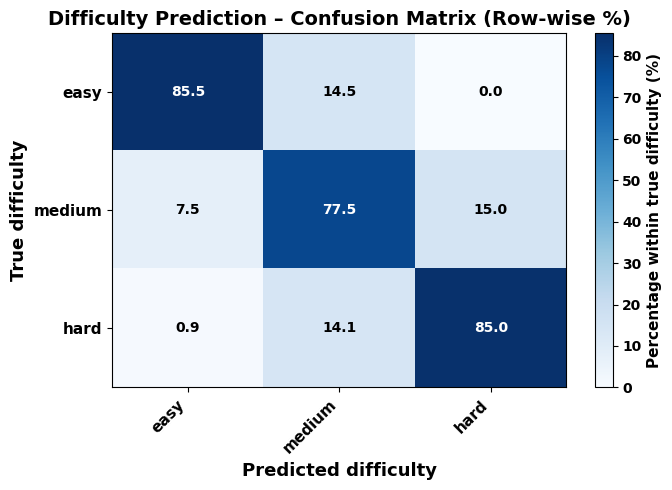

In [21]:
# Cell 21: Confusion matrix heatmap for difficulty prediction
"""
This cell visualizes how the difficulty classifier confuses different
difficulty levels, using a normalized confusion matrix heatmap.

Steps:
  1. Compute the confusion matrix on the test set.
  2. Normalize rows to show percentages per true difficulty level.
  3. Plot a heatmap using a non-yellow colormap.
"""

from sklearn.metrics import confusion_matrix

if "y_test_diff" not in globals() or "y_pred_diff" not in globals():
    raise NameError(
        "Variables `y_test_diff` and `y_pred_diff` not found. "
        "Please run Cell 20 (difficulty model training and prediction) first."
    )

# -------------------------------------------------------------------
# 1. Compute confusion matrix with a stable label order
# -------------------------------------------------------------------
labels_diff = ["easy", "medium", "hard"]
# Keep only labels that actually appear
labels_diff = [lbl for lbl in labels_diff if lbl in np.unique(y_test_diff)]

cm_diff = confusion_matrix(y_test_diff, y_pred_diff, labels=labels_diff)

# Normalize rows (per-true-difficulty percentages)
cm_diff_pct = cm_diff.astype(float) / cm_diff.sum(axis=1, keepdims=True) * 100.0

cm_diff_df = pd.DataFrame(cm_diff_pct, index=labels_diff, columns=labels_diff)

print("Normalized confusion matrix for difficulty (%):")
display(cm_diff_df.round(1))

# -------------------------------------------------------------------
# 2. Plot heatmap
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

im = ax.imshow(cm_diff_df.values, cmap="Blues", aspect="auto")  # non-yellow colormap

# Ticks and labels
ax.set_xticks(range(len(labels_diff)))
ax.set_yticks(range(len(labels_diff)))
ax.set_xticklabels(labels_diff, fontsize=11, fontweight="bold", rotation=45, ha="right")
ax.set_yticklabels(labels_diff, fontsize=11, fontweight="bold")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percentage within true difficulty (%)", fontsize=11, fontweight="bold")
for tick in cbar.ax.get_yticklabels():
    tick.set_fontsize(10)
    tick.set_fontweight("bold")

# Annotate cells
for i in range(len(labels_diff)):
    for j in range(len(labels_diff)):
        val = cm_diff_df.iloc[i, j]
        ax.text(
            j,
            i,
            f"{val:.1f}",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black" if val < 60 else "white",
        )

ax.set_title("Difficulty Prediction – Confusion Matrix (Row-wise %)", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted difficulty", fontsize=13, fontweight="bold")
ax.set_ylabel("True difficulty", fontsize=13, fontweight="bold")

ax.grid(False)
plt.tight_layout()
plt.savefig(FIG_DIR / "figure_10_Difficulty_Prediction_Confusion_Matrix_Row_wise.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
# Cell 22: Top indicative tokens per difficulty level (model interpretation)
"""
This cell inspects the learned multiclass logistic regression coefficients to
identify which tokens are most indicative of each difficulty level.

Changes:
  - Enforces a consistent class order: easy → medium → hard (when present).
  - Still shows top 15 tokens per difficulty as separate columns.
"""

if "difficulty_clf" not in globals():
    raise NameError(
        "`difficulty_clf` not found. Please run Cell 20 before this interpretation cell."
    )

# Avoid truncating cell contents in Jupyter display
pd.set_option("display.max_colwidth", None)

# Extract fitted components
tfidf_diff = difficulty_clf.named_steps["tfidf"]
logreg_diff = difficulty_clf.named_steps["logreg"]

feature_names_diff = np.array(tfidf_diff.get_feature_names_out())

# Raw class order from sklearn (usually alphabetical)
classes_raw = list(logreg_diff.classes_)

# Desired display order
desired_order = ["easy", "medium", "hard"]
classes_ordered = [c for c in desired_order if c in classes_raw] + [
    c for c in classes_raw if c not in desired_order
]

# Map label -> index in the coefficient matrix
label_to_idx = {label: idx for idx, label in enumerate(logreg_diff.classes_)}

coef_diff = logreg_diff.coef_  # shape: (n_classes, n_features)

TOP_N = 15  # number of top tokens per difficulty class

rows = []

for diff_label in classes_ordered:
    class_idx = label_to_idx[diff_label]
    class_coefs = coef_diff[class_idx]
    top_idx = np.argsort(class_coefs)[-TOP_N:][::-1]  # indices of largest weights
    
    top_tokens = feature_names_diff[top_idx]
    top_weights = class_coefs[top_idx]
    
    row_dict = {"difficulty_label": diff_label}
    for rank, (tok, w) in enumerate(zip(top_tokens, top_weights), start=1):
        row_dict[f"token_{rank}"] = f"{tok} ({w:.2f})"
    
    rows.append(row_dict)

top_tokens_diff_df = pd.DataFrame(rows).reset_index(drop=True)

print(f"Top {TOP_N} indicative tokens per difficulty level (TF–IDF + Logistic Regression):")
display(top_tokens_diff_df)


Top 15 indicative tokens per difficulty level (TF–IDF + Logistic Regression):


difficulty_label             token_1                 token_2           token_3                token_4  \
0             easy    microwave (1.86)         diabetic (1.75)  breakfast (1.73)          drinks (1.70)   
1           medium         eggs (1.49)  temperature cup (1.30)     baking (1.20)  degrees grease (1.18)   
2             hard  temperature (8.84)            place (4.79)        the (4.77)            room (4.77)   

                   token_5          token_6            token_7         token_8            token_9         token_10  \
0            pestos (1.62)  frosting (1.62)  pie crusts (1.55)    salad (1.51)  appetizers (1.48)     chill (1.34)   
1         the flour (1.16)   cook on (1.16)      batter (1.10)  oven to (1.07)     preheat (1.06)  into the (1.04)   
2  room temperature (4.76)      heat (4.72)       hours (4.13)    grill (4.01)      simmer (4.00)    reduce (3.92)   

             token_11            token_12         token_13            token_14               token_15  
0       salads (1.34)    cocktails (1.29)       ice (1.27)       crusts (1.19)            easy (1.16)  
1  over medium (1.02)  ground beef (0.99)  pancakes (0.94)  preheat the (0.93)            bars (0.92)  
2      to room (3.89)         with (3.77)       cup (3.69)      degrees (3.66)  temperature to (3.61)

In [23]:
# Cell 23: Augment difficulty dataset with structural features
"""
This cell augments the difficulty modeling dataset with structural features:

  - num_ingredients
  - num_steps
  - est_prep_time_min
  - est_cook_time_min

The goal is to combine text features and numeric structural features in a
single model for difficulty prediction.

Steps:
  1. Join the text-based difficulty dataset with the structural columns.
  2. Drop rows with missing numeric values.
  3. Store the result as `difficulty_model_aug_df`.
"""

if "difficulty_model_df" not in globals():
    raise NameError(
        "`difficulty_model_df` not found. Please run Cell 19 (difficulty dataset prep) first."
    )

# Columns needed from the original recipes dataframe
struct_cols = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]

for col in struct_cols:
    if col not in recipes_clean.columns:
        raise KeyError(f"Required structural column '{col}' not found in recipes_clean.")

# We built difficulty_model_df from model_df_diff (which was a copy of recipes_clean),
# so indices should still align with recipes_clean. Use the index to join.
aug_df = difficulty_model_df.copy()

# Copy structural columns from recipes_clean using the same index
for col in struct_cols:
    aug_df[col] = recipes_clean.loc[aug_df.index, col]

# Drop rows with missing numeric values
aug_df_before = aug_df.shape[0]
aug_df = aug_df.dropna(subset=struct_cols)
aug_df_after = aug_df.shape[0]

print(f"Augmented difficulty dataset size before dropping NaNs: {aug_df_before:,}")
print(f"Augmented difficulty dataset size after dropping NaNs:  {aug_df_after:,}")

print("\nPreview of augmented difficulty dataset:")
display(aug_df.head())

print("\nSummary statistics for structural features:")
display(aug_df[struct_cols].describe().T)

# Store under a clear name
difficulty_model_aug_df = aug_df

print(
    f"\n`difficulty_model_aug_df` shape: "
    f"{difficulty_model_aug_df.shape[0]:,} rows × {difficulty_model_aug_df.shape[1]} columns"
)


Augmented difficulty dataset size before dropping NaNs: 25,020
Augmented difficulty dataset size after dropping NaNs:  25,020

Preview of augmented difficulty dataset:


text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      air fryer potato slices with dipping sauce air fryer recipes air fryer recipes 3/4 cup ketchup 1/2 cup beer 1 tablespoon worcestershire sauce 1/2 teaspoon onion powder 1/4 teaspoon cayenne 2 baking potatoes olive oil cooking spray 1/2 teaspoon garlic powder salt and freshly ground black pepper combine ketchup, beer, worcestershire sauce, onion powder, and cayenne in a small saucepan. bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. remove from heat, and cool. cover and store in the refrigerator until ready to use. preheat the air fryer to 400 degrees f (200 degrees c). spray the basket with cooking spray or line with a disposable parchment liner. slice potatoes 1/4-inch thick (use a mandoline if you have one), and place in a bowl. spray potatoes with olive oil spray, and sprinkle with garlic powder, salt and pepper. give the potatoes a good stir. place potatoes in a single layer in the air fryer, and cook, shaking occasionally, until they start to crisp up a bit and turn golden brown, 14 to 17 minutes. cooking times can vary depending on the brand and size of the fryer, and you may have to cook in batches. remove from the fryer, and serve with beer ketchup dipping sauce.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        gochujang pork belly bites air fryer recipes air fryer recipes 1 pound pork belly 1/4 cup gochujang 2 tablespoons soy sauce 1 tablespoon honey, 1 teaspoon ground ginger preheat an air fryer to 400 degrees f (200 degrees c). place pork belly pieces in the basket in a single layer, not touching. air fry for 8 to 9 minutes; turn over and air fry for 6 to 7 minutes more. meanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl. remove pork belly from air fryer basket; toss in sauce to coat. return to the air fryer and fry until bites begin to char at the edges, 8 to 11 minutes more. (alternately, you can use sauce only for dipping; in this case, continue to fry without removing bites, until they begin to char, 6 to 7 minutes.)   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     


Summary statistics for structural features:


count       mean        std  min   25%   50%   75%    max
num_ingredients    25020.0   9.026659   3.811410  1.0   6.0   9.0  11.0   35.0
num_steps          25020.0   4.320943   2.174755  1.0   3.0   4.0   5.0   25.0
est_prep_time_min  25020.0  19.736331   8.041674  2.0  14.0  19.0  24.0   67.0
est_cook_time_min  25020.0  50.898361  32.742838  3.0  28.0  44.0  67.0  301.0


`difficulty_model_aug_df` shape: 25,020 rows × 6 columns


In [24]:
# Cell 24: Difficulty prediction with text + structural features
"""
This cell trains an augmented difficulty prediction model that uses:

  - Text features from `text` via TfidfVectorizer.
  - Structural numeric features: num_ingredients, num_steps,
    est_prep_time_min, est_cook_time_min (scaled).

Model:
  - ColumnTransformer to combine:
      - TF–IDF for text
      - StandardScaler for numeric features
  - LogisticRegression as the classifier.

Changes:
  - Classification report is printed in the consistent order easy → medium → hard,
    when those classes are present.
"""

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

if "difficulty_model_aug_df" not in globals():
    raise NameError(
        "`difficulty_model_aug_df` not found. Please run Cell 23 before this modeling cell."
    )

# -------------------------------------------------------------------
# 1. Define features (X) and labels (y)
# -------------------------------------------------------------------
numeric_features = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
text_feature = "text"
target_col = "difficulty_label"

X_aug = difficulty_model_aug_df[[text_feature] + numeric_features]
y_aug = difficulty_model_aug_df[target_col].values

print("Difficulty label distribution in augmented dataset:")
display(difficulty_model_aug_df[target_col].value_counts().to_frame("count"))

# -------------------------------------------------------------------
# 2. Train/test split (stratified by difficulty)
# -------------------------------------------------------------------
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug,
    y_aug,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y_aug,
)

print(f"\nAugmented training set size: {X_train_aug.shape[0]:,}")
print(f"Augmented test set size:     {X_test_aug.shape[0]:,}")

# -------------------------------------------------------------------
# 3. ColumnTransformer: text + numeric
# -------------------------------------------------------------------
text_transformer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
)

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_feature),
        ("num", numeric_transformer, numeric_features),
    ],
    remainder="drop",
)

logreg_diff_aug = LogisticRegression(
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",
    solver="lbfgs",
    random_state=RANDOM_SEED,
)

difficulty_clf_aug = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("logreg", logreg_diff_aug),
    ]
)

# -------------------------------------------------------------------
# 4. Fit the augmented model
# -------------------------------------------------------------------
print("\nFitting augmented difficulty model (text + structural features)...")
difficulty_clf_aug.fit(X_train_aug, y_train_aug)
print("Augmented model training complete.")

# -------------------------------------------------------------------
# 5. Evaluate and compare to text-only baseline
# -------------------------------------------------------------------
y_pred_aug = difficulty_clf_aug.predict(X_test_aug)
test_accuracy_aug = accuracy_score(y_test_aug, y_pred_aug)

print(f"\nTest accuracy (augmented model): {test_accuracy_aug:.4f}")

# If the baseline accuracy from Cell 20 is still available, print it for comparison
if "test_accuracy_diff" in globals():
    print(f"Test accuracy (text-only baseline): {test_accuracy_diff:.4f}")
    improvement = test_accuracy_aug - test_accuracy_diff
    print(f"Accuracy improvement (augmented - baseline): {improvement:.4f}")

# -------------------------------------------------------------------
# 6. Classification report with consistent ordering
# -------------------------------------------------------------------
desired_order = ["easy", "medium", "hard"]
present_labels = [lbl for lbl in desired_order if lbl in np.unique(y_test_aug)]

print("\nClassification report (augmented model, ordered easy → medium → hard):")
print(
    classification_report(
        y_test_aug,
        y_pred_aug,
        labels=present_labels,
        target_names=present_labels,
        digits=3,
    )
)


Difficulty label distribution in augmented dataset:


count
difficulty_label       
medium            14376
hard               8376
easy               2268


Augmented training set size: 20,016
Augmented test set size:     5,004

Fitting augmented difficulty model (text + structural features)...
Augmented model training complete.

Test accuracy (augmented model): 0.8893
Test accuracy (text-only baseline): 0.8070
Accuracy improvement (augmented - baseline): 0.0823

Classification report (augmented model, ordered easy → medium → hard):
              precision    recall  f1-score   support

        easy      0.824     0.956     0.885       454
      medium      0.931     0.875     0.902      2875
        hard      0.845     0.896     0.870      1675

    accuracy                          0.889      5004
   macro avg      0.867     0.909     0.886      5004
weighted avg      0.893     0.889     0.890      5004



Numeric feature coefficients (per difficulty class, ordered easy → medium → hard):


easy    medium      hard
feature                                        
num_ingredients   -1.892533  0.485250  1.407283
num_steps         -0.298206 -0.188115  0.486322
est_prep_time_min -2.288797  0.879683  1.409115
est_cook_time_min -9.472311  3.393746  6.078565

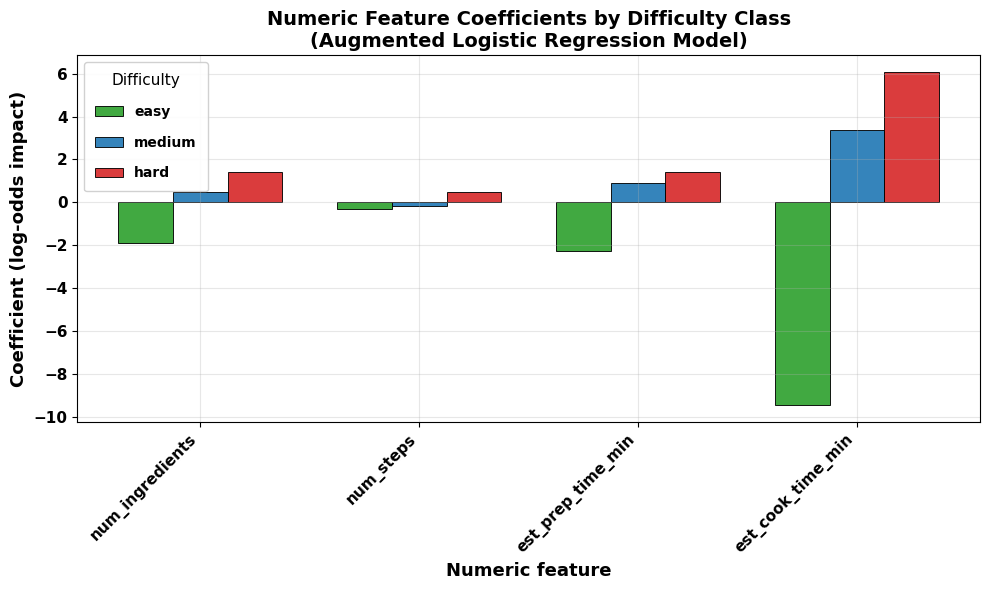

In [25]:
# Cell 25: Numeric feature coefficients for augmented difficulty model
"""
This cell inspects how the structural numeric features influence predicted
difficulty levels in the augmented model.

Changes:
  - Enforces a consistent class order: easy → medium → hard (when present)
    for the coefficient table and the grouped bar plot.
"""

if "difficulty_clf_aug" not in globals():
    raise NameError(
        "`difficulty_clf_aug` not found. Please run Cell 24 before this interpretation cell."
    )

from sklearn.utils.validation import check_is_fitted

# Ensure the pipeline is fitted
check_is_fitted(difficulty_clf_aug)

preprocessor = difficulty_clf_aug.named_steps["preprocess"]
logreg_aug = difficulty_clf_aug.named_steps["logreg"]

# Get full feature names from the ColumnTransformer
feature_names_full = preprocessor.get_feature_names_out()

# Numeric features will have a "num__" prefix (because we named that transformer "num")
num_prefix = "num__"
numeric_feature_names = [name for name in feature_names_full if name.startswith(num_prefix)]

if not numeric_feature_names:
    raise RuntimeError("No numeric features found in the transformed feature names.")

# Clean names (remove "num__" prefix)
numeric_feature_clean = [name.replace(num_prefix, "") for name in numeric_feature_names]

# Coefficient matrix and raw classes
coef_matrix = logreg_aug.coef_  # shape: (n_classes, n_features)
classes_raw = list(logreg_aug.classes_)

# Desired class order
desired_order = ["easy", "medium", "hard"]
classes_ordered = [c for c in desired_order if c in classes_raw] + [
    c for c in classes_raw if c not in desired_order
]

# Indices mapping label -> row index in coef_matrix
label_to_idx = {label: idx for idx, label in enumerate(logreg_aug.classes_)}

# Indices of numeric features in the full feature space
numeric_indices = [list(feature_names_full).index(name) for name in numeric_feature_names]

# Build a DataFrame: rows = numeric features, columns = difficulty classes (ordered)
coef_data = []
for feat_name, feat_clean, feat_idx in zip(numeric_feature_names, numeric_feature_clean, numeric_indices):
    row = {"feature": feat_clean}
    for cls in classes_ordered:
        class_idx = label_to_idx[cls]
        row[cls] = coef_matrix[class_idx, feat_idx]
    coef_data.append(row)

coef_df = pd.DataFrame(coef_data).set_index("feature")

print("Numeric feature coefficients (per difficulty class, ordered easy → medium → hard):")
display(coef_df)

# -------------------------------------------------------------------
# Plot grouped bar chart of numeric feature coefficients
# -------------------------------------------------------------------
features = coef_df.index.tolist()
x = np.arange(len(features))  # positions for groups
width = 0.25                  # bar width

# Map difficulty to distinct, non-yellow colors (we'll reuse the same mapping as before)
difficulty_colors = {
    "easy": COLOR_LIST[2],   # green-ish
    "medium": COLOR_LIST[0], # blue
    "hard": COLOR_LIST[3],   # red
}

fig, ax = plt.subplots(figsize=(10, 6))

for i, cls in enumerate(classes_ordered):
    offsets = x + (i - len(classes_ordered)/2) * width + width/2
    ax.bar(
        offsets,
        coef_df[cls].values,
        width=width,
        label=cls,
        color=difficulty_colors.get(cls, COLOR_LIST[i % len(COLOR_LIST)]),
        edgecolor="k",
        linewidth=0.7,
        alpha=0.9,
    )

# X-axis ticks at group centers
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha="right", fontsize=11, fontweight="bold")

style_axes(
    ax,
    title="Numeric Feature Coefficients by Difficulty Class\n(Augmented Logistic Regression Model)",
    xlabel="Numeric feature",
    ylabel="Coefficient (log-odds impact)",
)

legend = ax.legend(
    title="Difficulty",
    loc="upper left",
    borderaxespad=0.5,
    labelspacing=1.2,
    borderpad=0.8,
    markerscale=1.0,
    prop={"size": 10, "weight": "bold"},
    title_fontsize=11,
)
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_11_Difficulty.png", dpi=300, bbox_inches="tight")
plt.show()

Difficulty model comparison (text-only vs text+structural):


model  test_size  accuracy  macro_f1
0  Text-only (TF–IDF)       5004  0.806954  0.784348
1   Text + structural       5004  0.889289  0.885565


Normalized confusion matrix (%), text-only model:


easy  medium  hard
easy    85.5    14.5   0.0
medium   7.5    77.5  15.0
hard     0.9    14.1  85.0


Normalized confusion matrix (%), text + structural model:


easy  medium  hard
easy    95.6     4.4   0.0
medium   2.9    87.5   9.6
hard     0.5     9.9  89.6

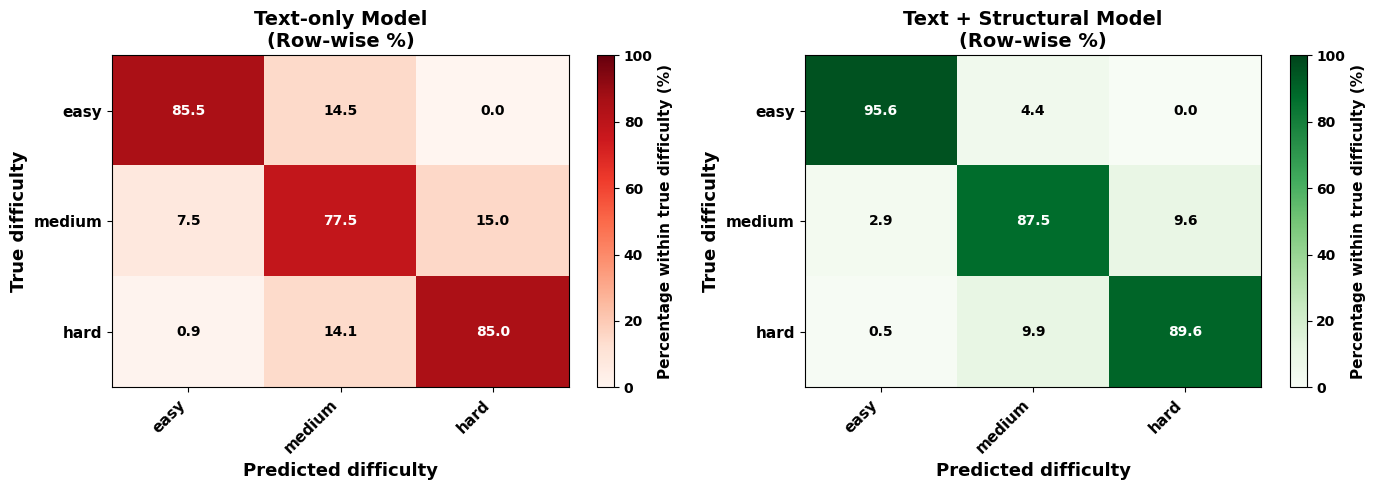

In [26]:
# Cell 26: Compare text-only vs text+structural difficulty models
"""
This cell compares the two difficulty models:

  1) Text-only model (TF–IDF + Logistic Regression) from Cell 20.
  2) Augmented model (TF–IDF + structural features + Logistic Regression) from Cell 24.

Comparison includes:
  - A small metrics table with accuracy and macro F1-score.
  - Side-by-side normalized confusion matrix heatmaps for each model,
    each with its own percentage gradient (colorbar) and a shared 0–100% scale.
    - Text-only: red colormap
    - Text + structural: green colormap
"""

from sklearn.metrics import confusion_matrix, f1_score

# -------------------------------------------------------------------
# 0. Safety checks
# -------------------------------------------------------------------
required_vars = [
    "y_test_diff", "y_pred_diff", "test_accuracy_diff",
    "y_test_aug", "y_pred_aug", "test_accuracy_aug",
]
for var in required_vars:
    if var not in globals():
        raise NameError(
            f"Variable `{var}` not found. Please ensure Cells 20 and 24 "
            "have been run successfully before this comparison cell."
        )

# -------------------------------------------------------------------
# 1. Compute metrics for both models
# -------------------------------------------------------------------
# Text-only baseline
acc_base = test_accuracy_diff
macro_f1_base = f1_score(y_test_diff, y_pred_diff, average="macro", zero_division=0)

# Augmented model
acc_aug = test_accuracy_aug
macro_f1_aug = f1_score(y_test_aug, y_pred_aug, average="macro", zero_division=0)

metrics_df = pd.DataFrame(
    {
        "model": ["Text-only (TF–IDF)", "Text + structural"],
        "test_size": [len(y_test_diff), len(y_test_aug)],
        "accuracy": [acc_base, acc_aug],
        "macro_f1": [macro_f1_base, macro_f1_aug],
    }
)

print("Difficulty model comparison (text-only vs text+structural):")
display(metrics_df)

# -------------------------------------------------------------------
# 2. Build confusion matrices for both models (row-wise %)
# -------------------------------------------------------------------
labels_order = ["easy", "medium", "hard"]

present_labels_base = [lbl for lbl in labels_order if lbl in np.unique(y_test_diff)]
present_labels_aug = [lbl for lbl in labels_order if lbl in np.unique(y_test_aug)]

cm_base = confusion_matrix(y_test_diff, y_pred_diff, labels=present_labels_base)
cm_aug = confusion_matrix(y_test_aug, y_pred_aug, labels=present_labels_aug)

# Normalize rows to percentages
cm_base_pct = cm_base.astype(float) / cm_base.sum(axis=1, keepdims=True) * 100.0
cm_aug_pct = cm_aug.astype(float) / cm_aug.sum(axis=1, keepdims=True) * 100.0

cm_base_df = pd.DataFrame(cm_base_pct, index=present_labels_base, columns=present_labels_base)
cm_aug_df = pd.DataFrame(cm_aug_pct, index=present_labels_aug, columns=present_labels_aug)

print("\nNormalized confusion matrix (%), text-only model:")
display(cm_base_df.round(1))

print("\nNormalized confusion matrix (%), text + structural model:")
display(cm_aug_df.round(1))

# -------------------------------------------------------------------
# 3. Plot side-by-side heatmaps (each with its own colorbar)
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Shared color scale for both: 0–100%
vmin, vmax = 0, 100

# --- Left: text-only model (RED) ---
ax = axes[0]
im0 = ax.imshow(cm_base_df.values, cmap="Reds", aspect="auto", vmin=vmin, vmax=vmax)

ax.set_xticks(range(len(present_labels_base)))
ax.set_yticks(range(len(present_labels_base)))
ax.set_xticklabels(present_labels_base, fontsize=11, fontweight="bold", rotation=45, ha="right")
ax.set_yticklabels(present_labels_base, fontsize=11, fontweight="bold")

for i in range(len(present_labels_base)):
    for j in range(len(present_labels_base)):
        val = cm_base_df.iloc[i, j]
        ax.text(
            j,
            i,
            f"{val:.1f}",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black" if val < 60 else "white",
        )

ax.set_title("Text-only Model\n(Row-wise %)", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted difficulty", fontsize=13, fontweight="bold")
ax.set_ylabel("True difficulty", fontsize=13, fontweight="bold")
ax.grid(False)

# Colorbar for text-only matrix
cbar0 = fig.colorbar(im0, ax=ax)
cbar0.ax.set_ylabel("Percentage within true difficulty (%)", fontsize=11, fontweight="bold")
for tick in cbar0.ax.get_yticklabels():
    tick.set_fontsize(10)
    tick.set_fontweight("bold")

# --- Right: text + structural model (GREEN) ---
ax = axes[1]
im1 = ax.imshow(cm_aug_df.values, cmap="Greens", aspect="auto", vmin=vmin, vmax=vmax)

ax.set_xticks(range(len(present_labels_aug)))
ax.set_yticks(range(len(present_labels_aug)))
ax.set_xticklabels(present_labels_aug, fontsize=11, fontweight="bold", rotation=45, ha="right")
ax.set_yticklabels(present_labels_aug, fontsize=11, fontweight="bold")

for i in range(len(present_labels_aug)):
    for j in range(len(present_labels_aug)):
        val = cm_aug_df.iloc[i, j]
        ax.text(
            j,
            i,
            f"{val:.1f}",
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black" if val < 60 else "white",
        )

ax.set_title("Text + Structural Model\n(Row-wise %)", fontsize=14, fontweight="bold")
ax.set_xlabel("Predicted difficulty", fontsize=13, fontweight="bold")
ax.set_ylabel("True difficulty", fontsize=13, fontweight="bold")
ax.grid(False)

# Colorbar for augmented matrix
cbar1 = fig.colorbar(im1, ax=ax)
cbar1.ax.set_ylabel("Percentage within true difficulty (%)", fontsize=11, fontweight="bold")
for tick in cbar1.ax.get_yticklabels():
    tick.set_fontsize(10)
    tick.set_fontweight("bold")

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_12_Text_Structural_Model_Row_wise.png", dpi=300, bbox_inches="tight")
plt.show()

# Beginning the ingredient-based pantry recommender

Recipes with at least one first-pass ingredient: 25,020 out of 25,020

Number of unique first-pass ingredients: 20,548
Ingredients appearing < 10 times: 18,742

Recipes available for ingredient-based recommendation (after second-pass cleaning): 25,020
Unique cleaned canonical ingredient tokens (final): 17,400

Top 20 most common cleaned canonical ingredients (final):


ingredient  recipe_count
0                             salt          7834
1                      white sugar          6523
2                all purpose flour          5263
3                           butter          5209
4                           garlic          4666
..                             ...           ...
15                     baking soda          2077
16  salt ground black pepper taste          1958
17                     brown sugar          1729
18                 unsalted butter          1551
19                             egg          1489

[20 rows x 2 columns]

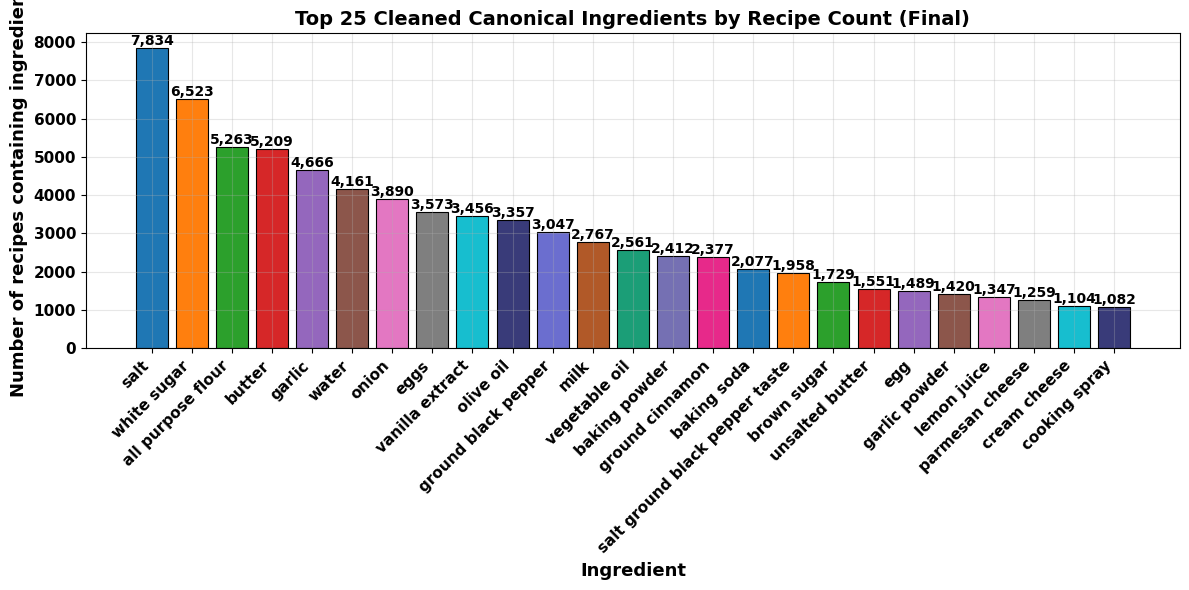

In [27]:
# Cell 27: Build ingredient-based representation for pantry recommender
"""
This cell prepares an ingredient-based representation of recipes for the
pantry-based recommender.

Improvements in this version:
  - Ingredient phrases are simplified to a cleaner, more canonical form.
    Examples:
      * "1/2 salt"                                   -> "salt"
      * "¼ tsp salt"                                 -> "salt"
      * "- -ounces chicken breasts halved horizontally"
            -> "chicken breasts"
      * "chicken breast cut into cubes"              -> "chicken breast"
      * "active dry yeast such as fleischmann s activedry yeast"
            -> "active dry yeast"
      * "- bag corn tortilla chips"                  -> "corn tortilla chips"
      * "salt pepper taste"                          -> "salt", "pepper"
  - Quantities, measurement units, and cooking/prep descriptors
    (e.g., "1/2", "¼", "cups", "minced", "chopped", "to taste") are removed.
  - Unicode fractions (¼, ½, ¾, etc.) are treated as numeric tokens and removed.
  - Tokens that are pure dashes/bullets ("-", "–", "—", "*") are dropped.
  - Multi-word ingredient names that make sense as single items are preserved:
      * "olive oil", "yukon gold potatoes", "garlic powder", "soy sauce", etc.
  - SECOND PASS: Ingredients that appear fewer than RARE_THRESHOLD times
    are re-checked more aggressively to remove leftover packaging/dashes/descriptors.

Steps:
  1. First-pass simplification: build `ingredients_list_lvl1`.
  2. Compute ingredient frequencies and identify "rare" ingredients.
  3. Second-pass refinement for rare ingredients to build `ingredients_list_clean`.
  4. Filter to recipes with at least one cleaned ingredient.
  5. Build a MultiLabelBinarizer multi-hot matrix (recipes × ingredients).
  6. Build an ingredient vocabulary DataFrame and plot top ingredients.
"""

import re
import ast
import unicodedata
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run the earlier preprocessing cells first.")

base_df = recipes_clean  # shorthand alias

if "ingredients_canonical" not in base_df.columns:
    raise KeyError("Column 'ingredients_canonical' not found in recipes_clean.")

# -------------------------------------------------------------------
# Helper: numeric detection with unicode fractions
# -------------------------------------------------------------------

FRACTION_CHARS = "¼½¾⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞"

def is_numeric_token(tok: str) -> bool:
    """
    Return True if the token looks like a quantity / numeric fragment.

    This catches:
      - Standard digits: "1", "2", "10", "1/2", "1-1/2", "0.5"
      - Any token containing unicode fraction chars: "¼", "½", "¾", etc.
      - Anything with digits + fraction chars mixed in ("1¼", "2½", etc.).
    """
    tok = tok.strip()
    if not tok:
        return False

    # If it contains any standard digit or unicode fraction, treat as numeric-like
    if any(ch.isdigit() for ch in tok) or any(ch in FRACTION_CHARS for ch in tok):
        return True

    # Regex fallback for pure ascii fraction-ish stuff
    if re.match(r"^[0-9]+([\/\.\-][0-9]+)*$", tok):
        return True

    # Final fallback: try unicode numeric conversion
    try:
        _ = unicodedata.numeric(tok)
        return True
    except (TypeError, ValueError):
        pass

    return False

# -------------------------------------------------------------------
# First-pass simplification for a single ingredient phrase
# -------------------------------------------------------------------

def simplify_ingredient_phrase(raw_phrase):
    """
    Simplify a single ingredient phrase into one or more canonical ingredient tokens.

    Goals:
      - Strip quantities and measurement units (e.g. '1/2 cup', '2 tsp', '¼ tsp').
      - Remove cooking/preparation descriptors (e.g. 'minced', 'chopped', 'to taste').
      - Cut off trailing explanation/brand phrases ("such as ...", "including ...",
        "cut into ...", etc.).
      - Remove bullets / leading dashes.
      - Preserve meaningful multi-word ingredient names (e.g. 'olive oil',
        'garlic powder', 'soy sauce', 'yukon gold potatoes').
      - Special-case 'salt and pepper' style combos into separate ingredients.

    Returns:
      A list of 0, 1, or more cleaned ingredient strings.
    """
    if not isinstance(raw_phrase, str):
        raw_phrase = str(raw_phrase)

    s = raw_phrase.lower().strip()
    if not s:
        return []

    # Cut off trailing "explanatory" clauses that usually introduce brands/examples
    # or describe cutting/portioning details.
    cut_patterns = [
        r"\bsuch as\b",
        r"\blike\b",
        r"\bincluding\b",
        r"\bfor example\b",
        r"\bfor instance\b",
        r"\bcut into\b",
        r"\bcut in\b",
    ]
    for pat in cut_patterns:
        parts = re.split(pat, s, maxsplit=1)
        if len(parts) > 1:
            s = parts[0].strip()

    # Remove common trailing phrases that are not part of the core ingredient
    remove_phrases = [
        "to taste",
        "or to taste",
        "for serving",
        "for garnish",
        "for frying",
        "for brushing",
        "for dusting",
        "for topping",
        "for decoration",
        "as needed",
    ]
    for phrase in remove_phrases:
        s = s.replace(phrase, " ")

    # Replace punctuation separators with spaces
    # (we split on '-' as well; hyphenated words like "semi-sweet" become two tokens,
    # which is acceptable here)
    s = re.sub(r"[(),/;+\-]", " ", s)

    # Collapse multiple spaces
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        return []

    tokens = s.split()

    units = {
        "tsp", "teaspoon", "teaspoons", "tsp.", "teaspoon.", "teaspoons.",
        "tbsp", "tablespoon", "tablespoons", "tbsp.", "tablespoon.", "tablespoons.",
        "cup", "cups", "cup.", "cups.",
        "ounce", "ounces", "oz", "oz.",
        "pound", "pounds", "lb", "lbs", "lb.", "lbs.",
        "gram", "grams", "g", "kg", "kilogram", "kilograms",
        "ml", "liter", "liters", "l",
        "clove", "cloves",
        "slice", "slices",
        "can", "cans",
        "package", "packages", "pkg",
        "bag", "bags",
        "pinch", "dash",
    }

    # Descriptors that are usually not part of the core ingredient identity
    descriptors = {
        "large", "small", "medium",
        "fresh", "freshly",
        "minced", "diced", "chopped", "sliced", "shredded", "grated",
        "melted", "softened", "cooled",
        "boneless", "skinless",
        "lean",
        "room", "temperature",
        "warm", "cold", "hot",
        "finely", "roughly", "coarsely",
        "divided",
        "halved", "quartered",
        "horizontally", "vertically", "diagonally", "lengthwise",
        "thinly", "thickly",
        "cubed", "crushed", "smashed",
        "pieces", "piece",
        "chunks", "chunk",
        "strips", "strip",
        "sticks", "stick",
        "rings", "ring",
        "bite", "size", "sized",
        "inch", "inches",
        "preferably", "good", "quality",
        "extra",  # often redundant in 'extra sharp cheddar', etc.
    }

    # Words that are connective but not core ingredients
    stopwords = {"and", "or", "of", "such", "as", "s"}  # 's' for "Fleischmann's" split

    filtered_tokens = []
    for tok in tokens:
        tok = tok.strip()
        if not tok:
            continue

        # Drop tokens that are pure dash/bullet characters
        if re.fullmatch(r"[-–—•*]+", tok):
            continue

        # Strip common punctuation from edges
        tok = tok.strip(".,%:-")
        if not tok:
            continue

        # First drop numeric-like tokens (including unicode fractions)
        if is_numeric_token(tok):
            continue

        if tok in units:
            continue
        if tok in descriptors:
            continue
        if tok in stopwords:
            continue

        filtered_tokens.append(tok)

    if not filtered_tokens:
        return []

    # Special case: "salt" + "pepper" combos -> return two separate ingredients
    if "salt" in filtered_tokens and "pepper" in filtered_tokens:
        core_tokens = [t for t in filtered_tokens if t not in {"salt", "pepper"}]
        if len(core_tokens) == 0:
            return ["salt", "pepper"]

    # Otherwise, treat remaining tokens as a single multi-word ingredient phrase
    simplified = " ".join(filtered_tokens)
    simplified = simplified.strip()
    if not simplified:
        return []

    return [simplified]

# -------------------------------------------------------------------
# Helper: parse ingredients_canonical (row-level) using first-pass simplifier
# -------------------------------------------------------------------

def parse_ingredients_canonical(val):
    """
    Parse the `ingredients_canonical` field into a list of cleaned ingredients
    using the first-pass simplifier.

    The underlying field may be:
      - a true Python list of strings, or
      - a string representation of a list.

    Each element is passed through `simplify_ingredient_phrase`, which may
    return zero, one, or multiple core ingredient tokens.
    """
    # Already a list
    if isinstance(val, list):
        items = val
    else:
        # String / other: try to parse as Python literal
        try:
            items = ast.literal_eval(str(val))
        except Exception:
            items = []

    cleaned = []
    for it in items:
        pieces = simplify_ingredient_phrase(it)
        cleaned.extend(pieces)

    # Remove empties and ensure uniqueness within a recipe while preserving order
    cleaned = [c for c in cleaned if c]
    cleaned = list(dict.fromkeys(cleaned))

    return cleaned

# -------------------------------------------------------------------
# SECOND PASS: refine rare ingredients more aggressively
# -------------------------------------------------------------------

def refine_rare_ingredient(ing: str) -> list:
    """
    Apply a more aggressive cleanup to a rare ingredient token.

    This is used only for tokens that appear fewer than RARE_THRESHOLD times
    in the first-pass ingredient list.

    Operations:
      - Strip leading bullets/dashes again.
      - Remove packaging words, descriptors, and extra connectives if they remain.
      - Re-run simplified logic to keep only core words.

    Returns:
      A list of tokens (usually length 1). If aggressive cleaning would
      delete everything, the original token is returned as a fallback.
    """
    s = str(ing).lower().strip()
    if not s:
        return []

    # Strip leading bullets/dashes
    s = re.sub(r"^[\-\–—•*]+\s*", "", s).strip()
    if not s:
        return []

    tokens = s.split()

    packaging = {
        "bag", "bags", "box", "boxes", "package", "packages", "pkg",
        "bottle", "bottles", "jar", "jars", "carton", "cartons",
        "packet", "packets", "envelope", "envelopes",
        "can", "cans", "container",
    }
    extra_descriptors = {
        "large", "small", "medium",
        "fresh", "freshly",
        "minced", "diced", "chopped", "sliced", "shredded", "grated",
        "melted", "softened", "cooled",
        "boneless", "skinless",
        "lean",
        "halved", "quartered",
        "horizontally", "vertically", "diagonally", "lengthwise",
        "thinly", "thickly",
        "cubed", "crushed", "smashed",
        "pieces", "piece",
        "chunks", "chunk",
        "strips", "strip",
        "sticks", "stick",
        "rings", "ring",
        "bite", "size", "sized",
        "inch", "inches",
        "preferably", "good", "quality",
        "extra", "more", "taste", "seeded", "into", "drained",
        "trimmed", "optional", "additional", "broken", 
    }
    stopwords2 = {"and", "or", "of", "such", "as", "s", "like", "including"}

    kept = []
    for tok in tokens:
        tok = tok.strip(".,%:-")
        if not tok:
            continue
        if re.fullmatch(r"[-–—•*]+", tok):
            continue
        if is_numeric_token(tok):
            continue
        if tok in packaging:
            continue
        if tok in extra_descriptors:
            continue
        if tok in stopwords2:
            continue
        kept.append(tok)

    if not kept:
        # Fallback: do not destroy the ingredient entirely
        return [ing]

    # Handle salt+pepper again
    if "salt" in kept and "pepper" in kept:
        others = [t for t in kept if t not in {"salt", "pepper"}]
        if not others:
            return ["salt", "pepper"]

    simplified = " ".join(kept).strip()
    if not simplified:
        return [ing]

    return [simplified]

# -------------------------------------------------------------------
# 1–2. First-pass parse + compute frequencies and rare tokens
# -------------------------------------------------------------------

work_df = base_df.copy()
work_df["ingredients_list_lvl1"] = work_df["ingredients_canonical"].apply(parse_ingredients_canonical)

# First-pass: keep recipes with at least one ingredient
mask_has_ing_lvl1 = work_df["ingredients_list_lvl1"].map(len) > 0
work_df = work_df[mask_has_ing_lvl1].reset_index(drop=True)

print(
    f"Recipes with at least one first-pass ingredient: "
    f"{work_df.shape[0]:,} out of {base_df.shape[0]:,}"
)

# Flatten to compute frequencies
all_ing_lvl1 = [ing for lst in work_df["ingredients_list_lvl1"] for ing in lst]
freq_lvl1 = pd.Series(all_ing_lvl1).value_counts()

RARE_THRESHOLD = 10
rare_ingredients = set(freq_lvl1[freq_lvl1 < RARE_THRESHOLD].index)

print(f"\nNumber of unique first-pass ingredients: {freq_lvl1.shape[0]:,}")
print(f"Ingredients appearing < {RARE_THRESHOLD} times: {len(rare_ingredients):,}")

# -------------------------------------------------------------------
# 3. Second-pass refinement for rare ingredients
# -------------------------------------------------------------------

def refine_ingredient_list(lst):
    new_tokens = []
    for ing in lst:
        if ing in rare_ingredients:
            refined = refine_rare_ingredient(ing)
            new_tokens.extend(refined)
        else:
            new_tokens.append(ing)

    # De-duplicate while preserving order
    out = []
    seen = set()
    for ing in new_tokens:
        if ing not in seen:
            seen.add(ing)
            out.append(ing)
    return out

work_df["ingredients_list_clean"] = work_df["ingredients_list_lvl1"].apply(refine_ingredient_list)

# Final mask: recipes with at least one cleaned ingredient
mask_has_clean = work_df["ingredients_list_clean"].map(len) > 0
recipes_for_recs = work_df[mask_has_clean].reset_index(drop=True)

print(
    f"\nRecipes available for ingredient-based recommendation (after second-pass cleaning): "
    f"{recipes_for_recs.shape[0]:,}"
)

# -------------------------------------------------------------------
# 4–5. MultiLabelBinarizer + ingredient vocabulary
# -------------------------------------------------------------------

ing_mlb = MultiLabelBinarizer(sparse_output=True)
X_ingredients = ing_mlb.fit_transform(recipes_for_recs["ingredients_list_clean"])

ingredient_vocab = ing_mlb.classes_
print(f"Unique cleaned canonical ingredient tokens (final): {len(ingredient_vocab):,}")

# Number of ingredients per recipe (cleaned canonical token count)
recipe_ing_counts = np.asarray(X_ingredients.sum(axis=1)).ravel()

# Ingredient frequencies (final)
ingredient_counts = np.asarray(X_ingredients.sum(axis=0)).ravel()
ingredient_vocab_df = (
    pd.DataFrame(
        {
            "ingredient": ingredient_vocab,
            "recipe_count": ingredient_counts.astype(int),
        }
    )
    .sort_values("recipe_count", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 20 most common cleaned canonical ingredients (final):")
display(ingredient_vocab_df.head(20))

# -------------------------------------------------------------------
# 6. Plot top-N ingredients by frequency
# -------------------------------------------------------------------
TOP_N_ING = 25
top_ing = ingredient_vocab_df.head(TOP_N_ING)

fig, ax = plt.subplots(figsize=(12, 6))

x_positions = np.arange(len(top_ing))
colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(top_ing))]

bars = ax.bar(
    x_positions,
    top_ing["recipe_count"].values,
    color=colors,
    edgecolor="k",
    linewidth=0.8,
)

ax.set_xticks(x_positions)
ax.set_xticklabels(
    top_ing["ingredient"].tolist(),
    rotation=45,
    ha="right",
    fontsize=11,
    fontweight="bold",
)

for bar, count in zip(bars, top_ing["recipe_count"].values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(count):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

style_axes(
    ax,
    title=f"Top {TOP_N_ING} Cleaned Canonical Ingredients by Recipe Count (Final)",
    xlabel="Ingredient",
    ylabel="Number of recipes containing ingredient",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_13_Top_TOP_N_ING_Cleaned_Canonical_Ingredients_by_Recipe_Count_Final.png", dpi=300, bbox_inches="tight")
plt.show()

In [28]:
# Cell 28: Searchable ingredient browser (scrollable, no truncation)
"""
This cell provides a searchable, scrollable view of all canonical ingredients
available in the dataset.

Improvements:
  - Both the full vocabulary table and the filtered search results use a
    scrollable HTML container, so the entire table is preserved (no middle
    truncation with "...").
  - DataFrames are rendered via .to_html(max_rows=None, max_cols=None),
    so pandas does not shorten them.
"""

from IPython.display import display, HTML
try:
    from ipywidgets import interact, widgets
    HAVE_WIDGETS = True
except ImportError:
    HAVE_WIDGETS = False
    print(
        "ipywidgets is not installed. Install it to enable interactive search, "
        "or just inspect `ingredient_vocab_df` directly."
    )

if "ingredient_vocab_df" not in globals():
    raise NameError(
        "`ingredient_vocab_df` not found. Please run Cell 27 before this browser cell."
    )

# Optional: avoid truncating long strings in cells
pd.set_option("display.max_colwidth", None)

def display_scrollable_df(df, max_height_px=400):
    """
    Render a DataFrame as a scrollable HTML table without truncation.

    - Uses DataFrame.to_html(max_rows=None, max_cols=None) to avoid pandas
      truncating the middle of the table.
    - Wraps the HTML in a <div> with fixed max-height and overflow:auto
      so the user can scroll vertically.
    """
    html = df.to_html(
        max_rows=None,
        max_cols=None,
        escape=False,
        border=0,
        index=True,
    )
    style = (
        f"max-height:{max_height_px}px; "
        "overflow:auto; "
        "border:1px solid #ccc; "
        "padding:4px; "
        "margin-top:4px;"
    )
    display(HTML(f'<div style="{style}">{html}</div>'))

print(f"Total canonical ingredients: {ingredient_vocab_df.shape[0]:,}")

# --- Full vocabulary (scrollable, no truncation) ---
print("\nFull ingredient vocabulary (scrollable):")
display_scrollable_df(ingredient_vocab_df, max_height_px=450)

# --- Interactive search (if ipywidgets is available) ---
if HAVE_WIDGETS:
    @interact(
        query=widgets.Text(description="Search:", placeholder="e.g. chicken, garlic"),
        top_n=widgets.IntSlider(
            value=25, min=10, max=200, step=5, description="Max rows:"
        ),
    )
    def search_ingredients(query="", top_n=25):
        """
        Filter the ingredient vocabulary by substring match, case-insensitive.
        Shows up to `top_n` rows in a scrollable, non-truncated table.
        """
        q = query.strip()
        if q == "":
            sub = ingredient_vocab_df.head(top_n)
        else:
            mask = ingredient_vocab_df["ingredient"].str.contains(q, case=False, regex=False)
            sub = ingredient_vocab_df[mask].head(top_n)

        print(
            f"\nMatching ingredients for query='{q}' "
            f"(showing up to {top_n} rows, {sub.shape[0]} displayed):"
        )
        display_scrollable_df(sub, max_height_px=350)


Total canonical ingredients: 17,400

Full ingredient vocabulary (scrollable):


interactive(children=(Text(value='', description='Search:', placeholder='e.g. chicken, garlic'), IntSlider(val…

In [29]:
# Cell 29: Pantry-based recipe recommender (core scoring function)
"""
This cell implements the core pantry-based recommender.

Improvement:
  - User-provided pantry ingredients are matched not only by exact name,
    but also by word-level substring against the cleaned canonical
    ingredient vocabulary.

    Example:
      - User types: "zucchini"
      - Matches canonical ingredients like:
          "zucchini", "zucchini patted dry", "zucchini spiralized"

Workflow:
  1. Normalize user pantry strings (lowercase, strip whitespace).
  2. For each user term, find all canonical ingredients whose name
     contains that term as a full word (word boundary match).
  3. Build a sparse user ingredient vector over the canonical vocabulary.
  4. For each recipe, compute:
       - overlap: number of matched canonical ingredients,
       - recipe_ingredient_count,
       - coverage = overlap / recipe_ingredient_count,
       - Jaccard similarity between user and recipe ingredient sets.
  5. Return a sorted DataFrame of top-k matching recipes, plus the user vector.

Notes:
  - `recipes_for_recs`, `X_ingredients`, `recipe_ing_counts`, and `ing_mlb`
    are created in Cell 27.
"""

import numpy as np
from scipy.sparse import csr_matrix

if "recipes_for_recs" not in globals() or "X_ingredients" not in globals() or "ing_mlb" not in globals():
    raise NameError(
        "`recipes_for_recs`, `X_ingredients`, or `ing_mlb` not found. "
        "Please run Cell 27 before using the pantry recommender."
    )

# Cache the canonical ingredient vocabulary for convenience
ING_VOCAB = np.array(ing_mlb.classes_)


def _map_pantry_to_vocab_indices(pantry_norm):
    """
    Internal helper: for a list of normalized pantry terms, find all matching
    indices in the canonical ingredient vocabulary using word-boundary
    substring matches.

    Returns:
      - matched_indices: set of integer indices into ING_VOCAB
      - mapping: dict user_term -> list of matched canonical ingredient strings
      - unmatched_terms: list of user terms with no matches
    """
    matched_indices = set()
    mapping = {}
    unmatched_terms = []

    for term in pantry_norm:
        # Word-boundary pattern to avoid e.g. 'rice' matching 'licorice'
        pattern = re.compile(r"\b" + re.escape(term) + r"\b")

        local_indices = [
            idx for idx, name in enumerate(ING_VOCAB)
            if pattern.search(name)
        ]

        if local_indices:
            matched_indices.update(local_indices)
            mapping[term] = [ING_VOCAB[i] for i in local_indices]
        else:
            unmatched_terms.append(term)

    return matched_indices, mapping, unmatched_terms


def recommend_recipes_for_pantry(
    pantry_ingredients,
    top_k=10,
    min_overlap=1,
    verbose=True,
):
    """
    Recommend recipes given a list of pantry ingredients.

    Matching behavior:
      - User terms are matched to canonical ingredients by word-boundary
        substring:
          * "zucchini" matches "zucchini", "zucchini patted dry", etc.
          * "chicken" matches "chicken breast", "ground chicken", etc.

    Parameters
    ----------
    pantry_ingredients : list of str
        List of user-provided ingredient strings (free-form).
        They will be normalized (lowercase, stripped) and matched against
        the canonical ingredient vocabulary as described above.
    top_k : int
        Number of recipes to return.
    min_overlap : int
        Minimum number of overlapping canonical ingredients between
        pantry and recipe required for a recipe to be considered.
    verbose : bool
        If True, prints basic info and mapping diagnostics.

    Returns
    -------
    recs_df : pandas.DataFrame
        DataFrame of the top-k recommended recipes, including:
          - recipe_idx (row index in `recipes_for_recs`)
          - recipe_title, description, difficulty
          - overlap, recipe_ingredients_count, coverage, jaccard
          - ingredients_list_clean
    user_vec : scipy.sparse.csr_matrix (1 × n_ingredients)
        Multi-hot ingredient vector for the user's pantry over the
        canonical ingredient space.
    """

    if not isinstance(pantry_ingredients, (list, tuple)):
        raise TypeError("`pantry_ingredients` should be a list of strings.")

    # Normalize pantry ingredients
    pantry_norm = [str(s).strip().lower() for s in pantry_ingredients if str(s).strip() != ""]
    pantry_norm = list(dict.fromkeys(pantry_norm))  # remove duplicates while preserving order

    if len(pantry_norm) == 0:
        if verbose:
            print("No valid pantry ingredients provided after cleaning.")
        return pd.DataFrame(), None

    if verbose:
        print("Normalized pantry ingredients:", pantry_norm)

    # Map user pantry terms to canonical ingredient vocabulary indices
    matched_indices, mapping, unmatched_terms = _map_pantry_to_vocab_indices(pantry_norm)

    if verbose:
        if mapping:
            print("\nPantry term → matched canonical ingredients:")
            for term, matches in mapping.items():
                # Show up to a few matches per term to avoid huge prints
                preview = matches[:6]
                preview_str = ", ".join(preview)
                if len(matches) > 6:
                    preview_str += f" ... (+{len(matches) - 6} more)"
                print(f"  {term!r} → {preview_str}")
        if unmatched_terms:
            print("\nThe following pantry terms did not match any canonical ingredient:")
            for u in unmatched_terms:
                print(f"  - {u}")
            print("Consider using the ingredient browser (Cell 28) to find close matches.\n")

    if not matched_indices:
        if verbose:
            print("No pantry ingredients matched the canonical vocabulary. "
                  "Cannot compute recommendations.")
        return pd.DataFrame(), None

    # Build user ingredient vector (1 × n_ingredients) as a sparse CSR matrix
    idx_list = sorted(matched_indices)
    data = np.ones(len(idx_list), dtype=np.float32)
    rows = np.zeros(len(idx_list), dtype=int)
    cols = np.array(idx_list, dtype=int)

    user_vec = csr_matrix(
        (data, (rows, cols)),
        shape=(1, len(ING_VOCAB)),
        dtype=np.float32,
    )

    # Overlap = number of shared ingredients between recipe and pantry
    overlaps = X_ingredients.dot(user_vec.T).toarray().ravel()

    # Union sizes for Jaccard similarity
    user_count = user_vec.sum(axis=1).A1[0]
    unions = recipe_ing_counts + user_count - overlaps
    jaccard = np.where(unions > 0, overlaps / unions, 0.0)

    # Coverage: fraction of recipe's ingredients covered by pantry
    coverage = np.where(recipe_ing_counts > 0, overlaps / recipe_ing_counts, 0.0)

    # Filter by minimum overlap
    mask = overlaps >= min_overlap
    if mask.sum() == 0:
        if verbose:
            print(f"No recipes found with at least {min_overlap} overlapping ingredients.")
        return pd.DataFrame(), user_vec

    # Build results DataFrame
    base = recipes_for_recs.loc[mask].copy().reset_index(drop=True)

    overlaps_f = overlaps[mask]
    recipe_counts_f = recipe_ing_counts[mask]
    coverage_f = coverage[mask]
    jaccard_f = jaccard[mask]

    recs_df = pd.DataFrame(
        {
            "recipe_idx": base.index,  # index within recipes_for_recs
            "recipe_title": base["recipe_title"].values,
            "description": base["description"].values,
            "difficulty": base["difficulty"].values,
            "overlap": overlaps_f,
            "recipe_ingredients_count": recipe_counts_f,
            "coverage": coverage_f,
            "jaccard": jaccard_f,
            "ingredients_list_clean": base["ingredients_list_clean"].values,
            "est_prep_time_min": base.get("est_prep_time_min", pd.Series([np.nan]*len(base))).values,
            "est_cook_time_min": base.get("est_cook_time_min", pd.Series([np.nan]*len(base))).values,
        }
    )

    # Sort by: coverage (descending), then Jaccard, then overlap, then shorter recipes
    recs_df = recs_df.sort_values(
        by=["coverage", "jaccard", "overlap", "recipe_ingredients_count"],
        ascending=[False, False, False, True],
    ).reset_index(drop=True)

    # Keep only top_k
    recs_df = recs_df.head(top_k)

    if verbose:
        print(f"Found {mask.sum():,} recipes with at least {min_overlap} overlapping ingredients.")
        print(f"Showing top {len(recs_df)} recipes after sorting.\n")

    return recs_df, user_vec


In [30]:
# Cell 30a: Example pantry recommendation with difficulty & taste predictions (no plots)
"""
This cell runs the pantry-based recommender on an example pantry and attaches:
  - Predicted difficulty (from the augmented difficulty model).
  - Predicted tastes (from the multi-label taste model).

It displays a summary table but does not produce any plots.
Subsequent cells (30b–30d) visualize these results.
"""

from collections import Counter  # used later in 30d, safe to import here

# Sanity checks: make sure the models and data are available
required_globals = [
    "difficulty_clf_aug",
    "difficulty_model_aug_df",
    "taste_clf",
    "mlb",
    "recipes_for_recs",
    "X_ingredients",
]
for name in required_globals:
    if name not in globals():
        raise NameError(
            f"`{name}` not found. Please run the taste and difficulty modeling cells "
            f"(Cells 15–16 for taste, 19, 23–24 for difficulty) before this cell."
        )

# -------------------------------------------------------------------
# 1. Define an example pantry and get recommendations
# -------------------------------------------------------------------
example_pantry = [
    "chicken",
    "garlic",
    "soy sauce",
    "olive oil",
    "rice",
]

TOP_K_EXAMPLE = 10

recs_example, user_vec_example = recommend_recipes_for_pantry(
    example_pantry,
    top_k=TOP_K_EXAMPLE,
    min_overlap=2,
    verbose=True,
)

if recs_example.empty or user_vec_example is None:
    print("No recommendations to visualize for this pantry.")
else:
    # -------------------------------------------------------------------
    # 2. Attach predicted difficulty + tastes for the recommended recipes
    # -------------------------------------------------------------------
    # Map back to rows in recipes_for_recs to pull text + structural features
    recipe_indices = recs_example["recipe_idx"].values

    # Difficulty features: text + numeric structure
    X_diff_recs = pd.DataFrame(
        {
            "text": recipes_for_recs.loc[recipe_indices, "combined_text"].fillna("").values,
            "num_ingredients": recipes_for_recs.loc[recipe_indices, "num_ingredients"].values,
            "num_steps": recipes_for_recs.loc[recipe_indices, "num_steps"].values,
            "est_prep_time_min": recipes_for_recs.loc[recipe_indices, "est_prep_time_min"].values,
            "est_cook_time_min": recipes_for_recs.loc[recipe_indices, "est_cook_time_min"].values,
        }
    )

    # Fill any missing numeric values with medians from the training dataset
    numeric_features = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
    num_medians = difficulty_model_aug_df[numeric_features].median()
    for col in numeric_features:
        X_diff_recs[col] = X_diff_recs[col].fillna(num_medians[col])

    pred_diff_labels = difficulty_clf_aug.predict(X_diff_recs)
    pred_diff_proba = difficulty_clf_aug.predict_proba(X_diff_recs)
    diff_classes = difficulty_clf_aug.named_steps["logreg"].classes_

    # Attach difficulty predictions + probabilities
    recs_example = recs_example.copy()
    recs_example["pred_difficulty"] = pred_diff_labels
    for i, cls in enumerate(diff_classes):
        recs_example[f"p_diff_{cls}"] = pred_diff_proba[:, i]

    # Taste predictions (multi-label)
    X_taste_recs = recipes_for_recs.loc[recipe_indices, "combined_text"].fillna("").values
    Y_taste_pred = taste_clf.predict(X_taste_recs)  # shape: (k, n_tastes)

    taste_labels = mlb.classes_
    pred_taste_lists = []
    for row in Y_taste_pred:
        tastes_for_recipe = [lbl for lbl, flag in zip(taste_labels, row) if flag == 1]
        pred_taste_lists.append(tastes_for_recipe)

    recs_example["pred_tastes"] = pred_taste_lists

    print("Top recommendations with predicted difficulty and tastes:")
    display(
        recs_example[
            [
                "recipe_title",
                "difficulty",        # original label (if present)
                "pred_difficulty",   # model prediction
                "overlap",
                "recipe_ingredients_count",
                "coverage",
                "jaccard",
                "pred_tastes",
            ]
        ]
    )


Normalized pantry ingredients: ['chicken', 'garlic', 'soy sauce', 'olive oil', 'rice']

Pantry term → matched canonical ingredients:
  'chicken' → apple chicken sausage links, artificial chicken, assorted chicken, beef broth chicken broth, better than bouillon roasted chicken base, boiled chicken breast meat ... (+473 more)
  'garlic' → asian chile paste with garlic, asian chili garlic sauce, asian garlic chili sauce, asian style sriracha chile garlic sauce, basil garlic flavored olive oil, basil garlic oregano tomato paste ... (+208 more)
  'soy sauce' → big tamari soy sauce, black soy sauce, chinese dark soy sauce, coconut aminos light soy sauce, dark soy sauce, dashes soy sauce ... (+36 more)
  'olive oil' → a little olive oil for the pan, anchovy fillets packed in olive oil, basil garlic flavored olive oil, black truffle infused olive oil, butter olive oil, canola oil virgin olive oil ... (+87 more)
  'rice' → aji nori furikake seasoned seaweed sesame rice topping, arborio rice, ar

recipe_title difficulty pred_difficulty  overlap  recipe_ingredients_count  coverage  \
0           Easy Canned Chicken & Rice       easy            hard      3.0                         3      1.00   
1          Roasted Garlic without Foil     medium            easy      2.0                         2      1.00   
2                       Roasted Garlic       easy            hard      2.0                         2      1.00   
3                   Really Simple Rice     medium            hard      4.0                         5      0.80   
4        Easy Air Fryer Chicken Breast     medium            easy      3.0                         4      0.75   
5                Chinese Chicken Wings     medium            easy      3.0                         4      0.75   
6     Super Easy Chicken and Dumplings     medium          medium      3.0                         4      0.75   
7  Orange Soya Sauce Marinated Chicken     medium          medium      3.0                         4      0.75   
8                            Bat Wings     medium            hard      3.0                         4      0.75   
9  Lucky and Rippy's Favorite Dog Food     medium            hard      3.0                         4      0.75   

    jaccard           pred_tastes  
0  0.002809       [savory, sweet]  
1  0.001873       [savory, sweet]  
2  0.001873        [spicy, sweet]  
3  0.003742        [spicy, sweet]  
4  0.002806               [sweet]  
5  0.002806  [sour, spicy, sweet]  
6  0.002806       [savory, umami]  
7  0.002806         [sour, sweet]  
8  0.002806              [savory]  
9  0.002806       [savory, sweet]

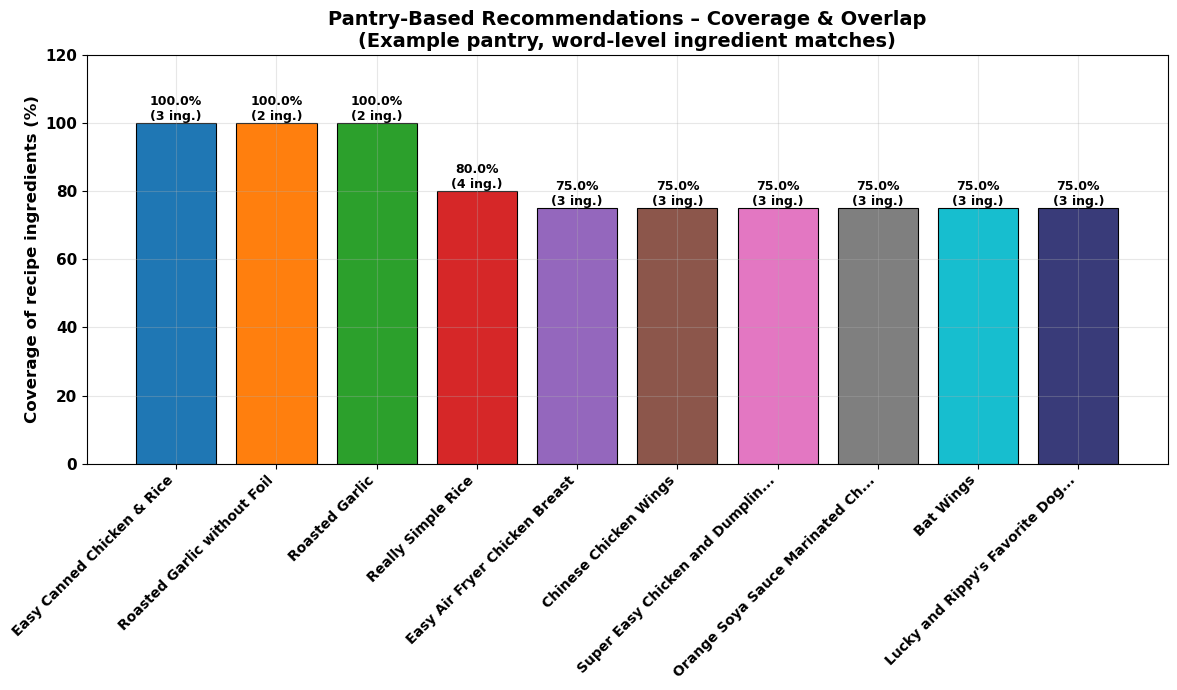

In [31]:
# Cell 30b: Coverage & overlap bar chart for example pantry
"""
This cell visualizes the top-k recommendations from Cell 30a using a bar chart:
  - Y-axis: coverage of recipe ingredients (% of ingredients present in pantry).
  - Text labels: coverage percentage and overlap count (number of matching ingredients).
"""

if "recs_example" not in globals() or recs_example.empty:
    raise NameError("`recs_example` not found or empty. Please run Cell 30a first.")

fig, ax1 = plt.subplots(figsize=(12, 7))  # taller to avoid title/label overlap

x_positions = np.arange(len(recs_example))
titles = recs_example["recipe_title"].tolist()

coverage_vals = recs_example["coverage"].values * 100.0  # percentage
overlap_vals = recs_example["overlap"].values

y_max = coverage_vals.max() if len(coverage_vals) > 0 else 1.0
ax1.set_ylim(0, y_max * 1.2)  # give some headroom for text labels

# Bars for coverage (% of recipe's ingredients present)
bars = ax1.bar(
    x_positions,
    coverage_vals,
    color=[COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(recs_example))],
    edgecolor="k",
    linewidth=0.8,
)

ax1.set_xticks(x_positions)
ax1.set_xticklabels(
    [t[:30] + ("..." if len(t) > 30 else "") for t in titles],
    rotation=45,
    ha="right",
    fontsize=10,
    fontweight="bold",
)

for bar, cov, ov in zip(bars, coverage_vals, overlap_vals):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        cov,
        f"{cov:.1f}%\n({int(ov)} ing.)",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

ax1.set_ylabel("Coverage of recipe ingredients (%)", fontsize=12, fontweight="bold")
ax1.set_title(
    "Pantry-Based Recommendations – Coverage & Overlap\n"
    "(Example pantry, word-level ingredient matches)",
    fontsize=14,
    fontweight="bold",
)

for label in ax1.get_yticklabels():
    label.set_fontsize(11)
    label.set_fontweight("bold")

ax1.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "figure_14_Pantry_Based_Recommendations_Coverage_Overlap.png", dpi=300, bbox_inches="tight")
plt.show()

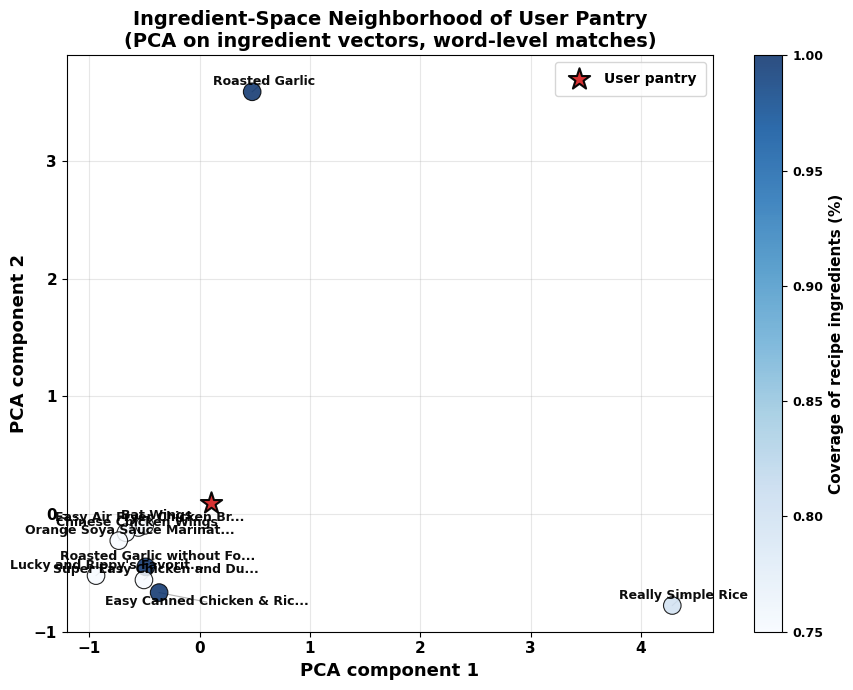

In [32]:
# Cell 30c: Ingredient-space neighborhood of user pantry (PCA)
"""
This cell plots the top-k recommended recipes and the user pantry in a
2D ingredient space using PCA:

  - Points: recipes (colored by coverage).
  - Star: user pantry.
  - Labels: non-overlapping recipe titles with leader lines.

PCA is fit on the recommended recipes only, and the user pantry vector
is projected into that space.
"""

from sklearn.decomposition import PCA
from scipy.sparse import vstack

if "recs_example" not in globals() or recs_example.empty or "user_vec_example" not in globals():
    raise NameError(
        "`recs_example` / `user_vec_example` not found or empty. "
        "Please run Cell 30a first."
    )

# Extract ingredient vectors for the recommended recipes
recipe_indices = recs_example["recipe_idx"].values  # indices within recipes_for_recs
X_recs = X_ingredients[recipe_indices]  # shape: (k, n_ingredients)

# Fit PCA on the recommended recipes only, then project the user pantry
X_recs_dense = X_recs.toarray()
user_dense = user_vec_example.toarray()

pca = PCA(n_components=2, random_state=RANDOM_SEED)
rec_coords = pca.fit_transform(X_recs_dense)         # (k, 2)
user_coord = pca.transform(user_dense)[0]            # (2,)

fig, ax = plt.subplots(figsize=(9, 7))

# Bigger points so the coverage gradient is more obvious
point_size = 160

# Plot recommended recipes, colored by coverage
scatter = ax.scatter(
    rec_coords[:, 0],
    rec_coords[:, 1],
    s=point_size,
    alpha=0.85,
    edgecolor="k",
    linewidth=0.8,
    c=recs_example["coverage"].values,  # color by coverage
    cmap="Blues",
    zorder=3,
)

# Plot user pantry as a star marker
ax.scatter(
    user_coord[0],
    user_coord[1],
    s=260,
    marker="*",
    edgecolor="k",
    linewidth=1.5,
    alpha=0.95,
    color="#d62728",  # red
    label="User pantry",
    zorder=5,
)

# -------------------------------------------------------------------
# Non-overlapping labels with leader lines
# -------------------------------------------------------------------
x_vals = rec_coords[:, 0]
y_vals = rec_coords[:, 1]
x_range = x_vals.max() - x_vals.min() if len(x_vals) > 1 else 1.0
y_range = y_vals.max() - y_vals.min() if len(y_vals) > 1 else 1.0

rng = np.random.default_rng(RANDOM_SEED)
label_positions = []
# Minimum distance between label positions (in data coordinates)
min_dist = 3.5 * np.hypot(x_range, y_range)

for (x, y, title, cov) in zip(
    rec_coords[:, 0],
    rec_coords[:, 1],
    recs_example["recipe_title"].tolist(),
    recs_example["coverage"].values,
):
    short_title = title[:25] + ("..." if len(title) > 25 else "")

    # Try a few random offsets to find a label position that isn't
    # too close to an existing label
    for _ in range(25):
        dx = (rng.random() - 0.5) * 0.3 * x_range   # jitter up to ±15% range
        dy = (rng.random() - 0.5) * 0.3 * y_range

        lx, ly = x + dx, y + dy

        if all(np.hypot(lx - px, ly - py) >= min_dist for (px, py) in label_positions):
            label_positions.append((lx, ly))
            break
    else:
        # Fallback: no non-overlapping position found, just place near the point
        lx, ly = x + 0.02 * x_range, y + 0.02 * y_range
        label_positions.append((lx, ly))

    # Draw a light leader line from point to label
    ax.plot(
        [x, lx],
        [y, ly],
        color="gray",
        linewidth=0.8,
        alpha=0.6,
        zorder=2,
    )

    # Draw the label
    ax.text(
        lx,
        ly,
        short_title,
        fontsize=9,
        fontweight="bold",
        ha="center",
        va="center",
        alpha=0.95,
        zorder=6,
    )

cbar = fig.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Coverage of recipe ingredients (%)", fontsize=11, fontweight="bold")
for tick in cbar.ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_fontweight("bold")

style_axes(
    ax,
    title="Ingredient-Space Neighborhood of User Pantry\n"
          "(PCA on ingredient vectors, word-level matches)",
    xlabel="PCA component 1",
    ylabel="PCA component 2",
)

ax.legend(
    loc="upper right",
    borderaxespad=0.5,
    labelspacing=1.0,
    borderpad=0.7,
    prop={"size": 10, "weight": "bold"},
    title_fontsize=11,
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_15_Ingredient_Space_Neighborhood_of_User_Pantry.png", dpi=300, bbox_inches="tight")
plt.show()

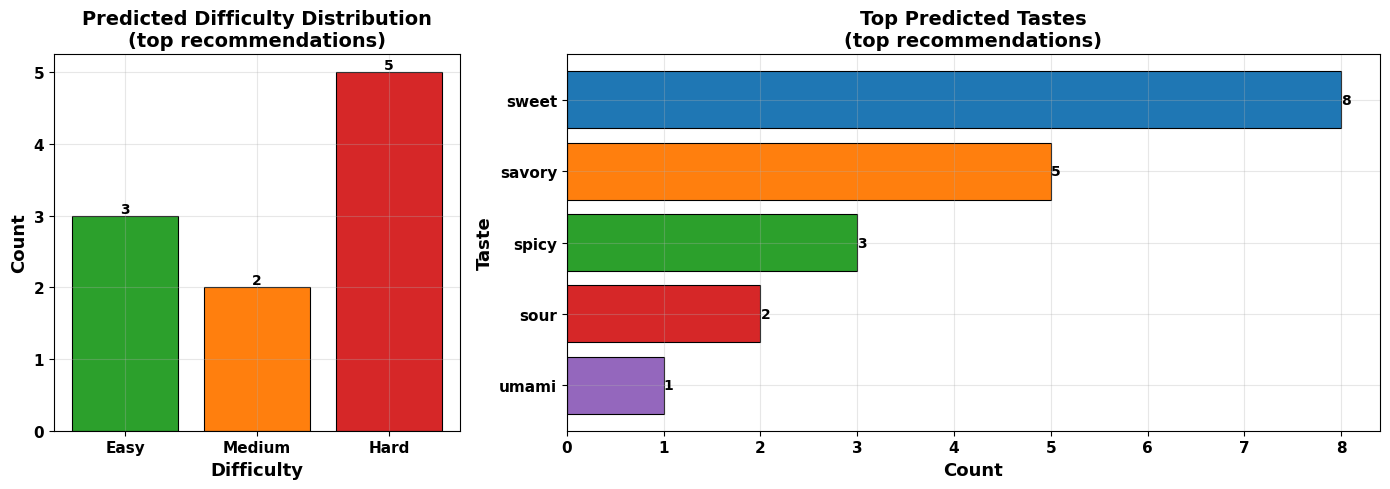

In [33]:
# Cell 30d: Summary charts – predicted difficulty & top tastes
"""
This cell summarizes the top-k recommendations from Cell 30a in two plots:

  - Left: distribution of predicted difficulty (easy / medium / hard).
  - Right: top predicted tastes by frequency.

It assumes that `recs_example` already contains:
  - `pred_difficulty`
  - `pred_tastes`
as added in Cell 30a.
"""

from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

if "recs_example" not in globals() or recs_example.empty:
    raise NameError("`recs_example` not found or empty. Please run Cell 30a first.")

# Difficulty distribution among recommended recipes
desired_order = ["easy", "medium", "hard"]
diff_counts = recs_example["pred_difficulty"].value_counts().reindex(
    desired_order, fill_value=0
)

# Taste frequencies among recommended recipes
taste_counter = Counter(
    taste
    for tastes in recs_example["pred_tastes"]
    for taste in tastes
)
if len(taste_counter) > 0:
    taste_df = (
        pd.DataFrame(
            {"taste": list(taste_counter.keys()), "count": list(taste_counter.values())}
        )
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )
    TOP_TASTES = min(8, taste_df.shape[0])
    taste_top = taste_df.head(TOP_TASTES)
else:
    taste_top = pd.DataFrame({"taste": [], "count": []})

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

ax_diff = plt.subplot(gs[0])
ax_taste = plt.subplot(gs[1])

# --- Left: difficulty distribution ---
diff_x = np.arange(len(desired_order))
diff_colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # green, orange, red (no yellow)

bars_diff = ax_diff.bar(
    diff_x,
    diff_counts.values,
    color=diff_colors,
    edgecolor="k",
    linewidth=0.8,
)

ax_diff.set_xticks(diff_x)
ax_diff.set_xticklabels(
    [lbl.capitalize() for lbl in desired_order],
    rotation=0,
    fontsize=11,
    fontweight="bold",
)

for bar, cnt in zip(bars_diff, diff_counts.values):
    ax_diff.text(
        bar.get_x() + bar.get_width() / 2,
        cnt,
        int(cnt),
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

# Force integer y-axis ticks to avoid 0.0–1.0 style tick labels
ax_diff.yaxis.set_major_locator(MaxNLocator(integer=True))

style_axes(
    ax_diff,
    title="Predicted Difficulty Distribution\n(top recommendations)",
    xlabel="Difficulty",
    ylabel="Count",
)

# --- Right: top tastes (if any) ---
if not taste_top.empty:
    y_pos = np.arange(taste_top.shape[0])
    taste_colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(taste_top.shape[0])]

    ax_taste.barh(
        y_pos,
        taste_top["count"].values,
        color=taste_colors,
        edgecolor="k",
        linewidth=0.8,
    )

    ax_taste.set_yticks(y_pos)
    ax_taste.set_yticklabels(
        taste_top["taste"].tolist(),
        fontsize=11,
        fontweight="bold",
    )
    ax_taste.invert_yaxis()  # highest at top

    for y, cnt in zip(y_pos, taste_top["count"].values):
        ax_taste.text(
            cnt,
            y,
            int(cnt),
            va="center",
            ha="left",
            fontsize=10,
            fontweight="bold",
        )

    # Force integer x-axis ticks here as well
    ax_taste.xaxis.set_major_locator(MaxNLocator(integer=True))

    style_axes(
        ax_taste,
        title="Top Predicted Tastes\n(top recommendations)",
        xlabel="Count",
        ylabel="Taste",
    )
else:
    ax_taste.text(
        0.5,
        0.5,
        "No tastes predicted for these recipes.",
        ha="center",
        va="center",
        fontsize=12,
        fontweight="bold",
    )
    style_axes(
        ax_taste,
        title="Top Predicted Tastes\n(top recommendations)",
        xlabel="Count",
        ylabel="Taste",
    )

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_16_Top_Predicted_Tastes_top_recommendations.png", dpi=300, bbox_inches="tight")
plt.show()

Normalized pantry ingredients: ['zucchini', 'chicken', 'garlic', 'onion', 'olive oil']

Pantry term → matched canonical ingredients:
  'zucchini' → frozen mixed carrots broccoli zucchini cauliflowe, green zucchini, organic zucchini, peeled zucchini, pumpkin zucchini blossoms, squeezed zucchini ... (+31 more)
  'chicken' → apple chicken sausage links, artificial chicken, assorted chicken, beef broth chicken broth, better than bouillon roasted chicken base, boiled chicken breast meat ... (+473 more)
  'garlic' → asian chile paste with garlic, asian chili garlic sauce, asian garlic chili sauce, asian style sriracha chile garlic sauce, basil garlic flavored olive oil, basil garlic oregano tomato paste ... (+208 more)
  'onion' → basil green onion, beef with onion soup mix, beefy onion soup mix, bermuda onion, bunch green onion, bunches green onion ... (+178 more)
  'olive oil' → a little olive oil for the pan, anchovy fillets packed in olive oil, basil garlic flavored olive oil, black truf

recipe_title difficulty pred_difficulty  overlap  recipe_ingredients_count  \
0                             Easy Baked Chicken Thighs     medium          medium      3.0                         3   
1                                      Steamed Zucchini     medium          medium      3.0                         3   
2                           Roasted Garlic without Foil     medium          medium      2.0                         2   
3                                        Roasted Garlic       easy          medium      2.0                         2   
4                              Air Fryer Chicken Strips       hard          medium      1.0                         1   
5                       Air Fryer Frozen Chicken Strips       hard            hard      1.0                         1   
6                                    Air Fryer Calzones     medium            hard      1.0                         1   
7                     Chef John's Nashville Hot Chicken       hard            easy      1.0                         1   
8  Khao Man Gai Thai Chicken and Rice (Healthy Version)       hard            hard      1.0                         1   
9                                    Really Simple Rice     medium          medium      4.0                         5   

   coverage   jaccard      pred_tastes  
0       1.0  0.003003  [savory, sweet]  
1       1.0  0.003003  [savory, sweet]  
2       1.0  0.002002  [savory, sweet]  
3       1.0  0.002002  [savory, sweet]  
4       1.0  0.001001  [savory, spicy]  
5       1.0  0.001001  [savory, sweet]  
6       1.0  0.001001  [savory, umami]  
7       1.0  0.001001    [sour, sweet]  
8       1.0  0.001001   [spicy, sweet]  
9       0.8  0.004000  [savory, umami]

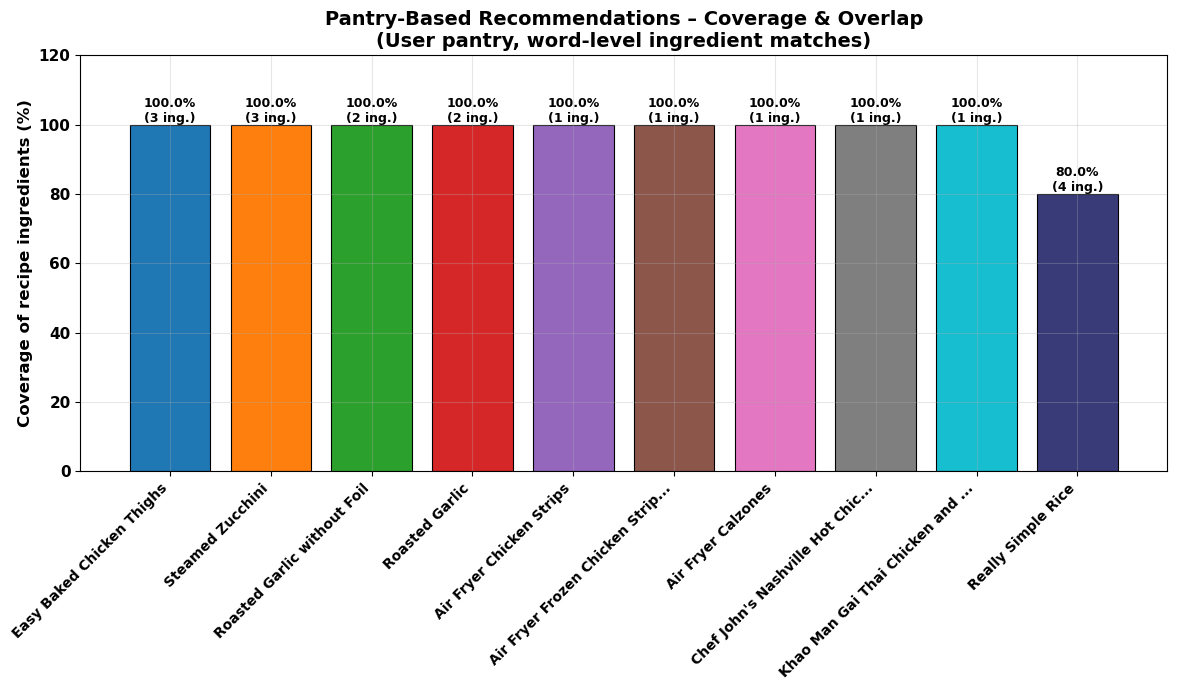

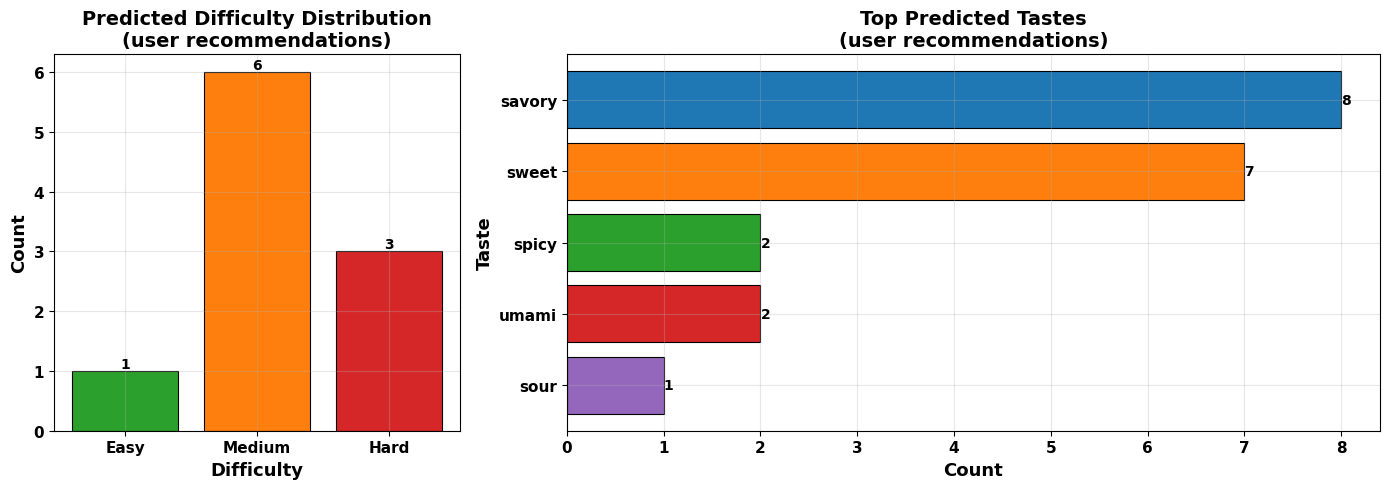

In [34]:
# Cell 31: User-defined pantry input with difficulty & taste predictions
"""
This cell lets a user specify their own pantry ingredients and then:

  1. Runs the pantry-based recommender.
  2. Attaches predicted difficulty (from the augmented difficulty model).
  3. Attaches predicted tastes (from the multi-label taste model).
  4. Displays:
       - A table of top recommended recipes.
       - A bar chart of coverage & overlap.
       - A summary figure:
           * Left: predicted difficulty distribution.
           * Right: top predicted tastes.

Matching behavior:
  - Pantry terms are matched to canonical ingredients by word-level substring.
    Examples:
      * "zucchini" matches "zucchini", "zucchini patted dry", "zucchini spiralized"
      * "chicken" matches "chicken breast", "ground chicken", etc.
"""

from collections import Counter
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

# Sanity checks: make sure the models and data are available
required_globals = [
    "difficulty_clf_aug",
    "difficulty_model_aug_df",
    "taste_clf",
    "mlb",
    "recipes_for_recs",
    "X_ingredients",
    "recommend_recipes_for_pantry",
]
for name in required_globals:
    if name not in globals():
        raise NameError(
            f"`{name}` not found. Please run the taste and difficulty modeling cells "
            f"(Cells 15–16 for taste, 19, 23–24 for difficulty), the ingredient "
            f"recommender setup cells (27–29), and Cell 30a before this cell."
        )

# -------------------------------------------------------------------
# 1. EDIT THIS LIST WITH YOUR INGREDIENTS
# -------------------------------------------------------------------
user_pantry = [
    "zucchini",
    "chicken",
    "garlic",
    "onion",
    "olive oil",
]

TOP_K_USER = 10

# -------------------------------------------------------------------
# 2. Get recommendations for the user pantry
# -------------------------------------------------------------------
user_recs, user_vec = recommend_recipes_for_pantry(
    user_pantry,
    top_k=TOP_K_USER,
    min_overlap=1,
    verbose=True,
)

if user_recs.empty or user_vec is None:
    print("No recommendations returned. Try adjusting your pantry list or min_overlap.")
else:
    # -------------------------------------------------------------------
    # 3. Attach predicted difficulty + tastes for the user recommendations
    # -------------------------------------------------------------------
    recipe_indices_user = user_recs["recipe_idx"].values

    # Difficulty features: text + numeric structure
    X_diff_user = pd.DataFrame(
        {
            "text": recipes_for_recs.loc[recipe_indices_user, "combined_text"].fillna("").values,
            "num_ingredients": recipes_for_recs.loc[recipe_indices_user, "num_ingredients"].values,
            "num_steps": recipes_for_recs.loc[recipe_indices_user, "num_steps"].values,
            "est_prep_time_min": recipes_for_recs.loc[recipe_indices_user, "est_prep_time_min"].values,
            "est_cook_time_min": recipes_for_recs.loc[recipe_indices_user, "est_cook_time_min"].values,
        }
    )

    # Fill any missing numeric values with medians from the training dataset
    numeric_features = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
    num_medians = difficulty_model_aug_df[numeric_features].median()
    for col in numeric_features:
        X_diff_user[col] = X_diff_user[col].fillna(num_medians[col])

    pred_diff_labels_user = difficulty_clf_aug.predict(X_diff_user)
    pred_diff_proba_user = difficulty_clf_aug.predict_proba(X_diff_user)
    diff_classes = difficulty_clf_aug.named_steps["logreg"].classes_

    user_recs = user_recs.copy()
    user_recs["pred_difficulty"] = pred_diff_labels_user
    for i, cls in enumerate(diff_classes):
        user_recs[f"p_diff_{cls}"] = pred_diff_proba_user[:, i]

    # Taste predictions (multi-label)
    X_taste_user = recipes_for_recs.loc[recipe_indices_user, "combined_text"].fillna("").values
    Y_taste_pred_user = taste_clf.predict(X_taste_user)

    taste_labels = mlb.classes_
    pred_taste_lists_user = []
    for row in Y_taste_pred_user:
        tastes_for_recipe = [lbl for lbl, flag in zip(taste_labels, row) if flag == 1]
        pred_taste_lists_user.append(tastes_for_recipe)

    user_recs["pred_tastes"] = pred_taste_lists_user

    print("Top recommendations for your pantry with predicted difficulty and tastes:")
    display(
        user_recs[
            [
                "recipe_title",
                "difficulty",        # original label (if present)
                "pred_difficulty",   # model prediction
                "overlap",
                "recipe_ingredients_count",
                "coverage",
                "jaccard",
                "pred_tastes",
            ]
        ]
    )

    # -------------------------------------------------------------------
    # 4. Coverage & overlap bar chart (for this user pantry)
    # -------------------------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(12, 7))

    x_positions = np.arange(len(user_recs))
    titles = user_recs["recipe_title"].tolist()

    coverage_vals = user_recs["coverage"].values * 100.0  # percentage
    overlap_vals = user_recs["overlap"].values

    y_max = coverage_vals.max() if len(coverage_vals) > 0 else 1.0
    ax1.set_ylim(0, y_max * 1.2)

    bars = ax1.bar(
        x_positions,
        coverage_vals,
        color=[COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(user_recs))],
        edgecolor="k",
        linewidth=0.8,
    )

    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(
        [t[:30] + ("..." if len(t) > 30 else "") for t in titles],
        rotation=45,
        ha="right",
        fontsize=10,
        fontweight="bold",
    )

    for bar, cov, ov in zip(bars, coverage_vals, overlap_vals):
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            cov,
            f"{cov:.1f}%\n({int(ov)} ing.)",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    ax1.set_ylabel("Coverage of recipe ingredients (%)", fontsize=12, fontweight="bold")
    ax1.set_title(
        "Pantry-Based Recommendations – Coverage & Overlap\n"
        "(User pantry, word-level ingredient matches)",
        fontsize=14,
        fontweight="bold",
    )

    for label in ax1.get_yticklabels():
        label.set_fontsize(11)
        label.set_fontweight("bold")

    ax1.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "figure_17_Predicted_Difficulty_Distribution_user_recommendations.png", dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------------------------------------------
    # 5. Summary charts: difficulty distribution + top tastes
    # -------------------------------------------------------------------
    # Difficulty distribution among user recommendations
    desired_order = ["easy", "medium", "hard"]
    diff_counts_user = user_recs["pred_difficulty"].value_counts().reindex(
        desired_order, fill_value=0
    )

    # Taste frequencies among user recommendations
    taste_counter_user = Counter(
        taste
        for tastes in user_recs["pred_tastes"]
        for taste in tastes
    )
    if len(taste_counter_user) > 0:
        taste_df_user = (
            pd.DataFrame(
                {"taste": list(taste_counter_user.keys()), "count": list(taste_counter_user.values())}
            )
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )
        TOP_TASTES_USER = min(8, taste_df_user.shape[0])
        taste_top_user = taste_df_user.head(TOP_TASTES_USER)
    else:
        taste_top_user = pd.DataFrame({"taste": [], "count": []})

    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ax_diff = plt.subplot(gs[0])
    ax_taste = plt.subplot(gs[1])

    # --- Left: difficulty distribution ---
    diff_x = np.arange(len(desired_order))
    diff_colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # green, orange, red (no yellow)

    bars_diff = ax_diff.bar(
        diff_x,
        diff_counts_user.values,
        color=diff_colors,
        edgecolor="k",
        linewidth=0.8,
    )

    ax_diff.set_xticks(diff_x)
    ax_diff.set_xticklabels(
        [lbl.capitalize() for lbl in desired_order],
        rotation=0,
        fontsize=11,
        fontweight="bold",
    )

    for bar, cnt in zip(bars_diff, diff_counts_user.values):
        ax_diff.text(
            bar.get_x() + bar.get_width() / 2,
            cnt,
            int(cnt),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Force integer y-axis ticks
    ax_diff.yaxis.set_major_locator(MaxNLocator(integer=True))

    style_axes(
        ax_diff,
        title="Predicted Difficulty Distribution\n(user recommendations)",
        xlabel="Difficulty",
        ylabel="Count",
    )

    # --- Right: top tastes (if any) ---
    if not taste_top_user.empty:
        y_pos = np.arange(taste_top_user.shape[0])
        taste_colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(taste_top_user.shape[0])]

        ax_taste.barh(
            y_pos,
            taste_top_user["count"].values,
            color=taste_colors,
            edgecolor="k",
            linewidth=0.8,
        )

        ax_taste.set_yticks(y_pos)
        ax_taste.set_yticklabels(
            taste_top_user["taste"].tolist(),
            fontsize=11,
            fontweight="bold",
        )
        ax_taste.invert_yaxis()  # highest at top

        for y, cnt in zip(y_pos, taste_top_user["count"].values):
            ax_taste.text(
                cnt,
                y,
                int(cnt),
                va="center",
                ha="left",
                fontsize=10,
                fontweight="bold",
            )

        # Force integer x-axis ticks
        ax_taste.xaxis.set_major_locator(MaxNLocator(integer=True))

        style_axes(
            ax_taste,
            title="Top Predicted Tastes\n(user recommendations)",
            xlabel="Count",
            ylabel="Taste",
        )
    else:
        ax_taste.text(
            0.5,
            0.5,
            "No tastes predicted for these recipes.",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )
        style_axes(
            ax_taste,
            title="Top Predicted Tastes\n(user recommendations)",
            xlabel="Count",
            ylabel="Taste",
        )

    plt.tight_layout()
    plt.savefig(FIG_DIR / "figure_18_Top_Predicted_Tastes_user_recommendations.png", dpi=300, bbox_inches="tight")
    plt.show()

Normalized pantry ingredients: ['zucchini', 'chicken', 'garlic', 'onion', 'olive oil']

Pantry term → matched canonical ingredients:
  'zucchini' → frozen mixed carrots broccoli zucchini cauliflowe, green zucchini, organic zucchini, peeled zucchini, pumpkin zucchini blossoms, squeezed zucchini ... (+31 more)
  'chicken' → apple chicken sausage links, artificial chicken, assorted chicken, beef broth chicken broth, better than bouillon roasted chicken base, boiled chicken breast meat ... (+473 more)
  'garlic' → asian chile paste with garlic, asian chili garlic sauce, asian garlic chili sauce, asian style sriracha chile garlic sauce, basil garlic flavored olive oil, basil garlic oregano tomato paste ... (+208 more)
  'onion' → basil green onion, beef with onion soup mix, beefy onion soup mix, bermuda onion, bunch green onion, bunches green onion ... (+178 more)
  'olive oil' → a little olive oil for the pan, anchovy fillets packed in olive oil, basil garlic flavored olive oil, black truf

recipe_title difficulty pred_difficulty  overlap  recipe_ingredients_count  \
0                          Instant Pot Chicken Soup     medium            hard      8.0                        14   
1                               Chicken Rotini Soup     medium          medium      6.0                        11   
2              New Mexican Green Chile Chicken Stew     medium            hard      6.0                        11   
3  After the Holidays Chicken Cordon Bleu Casserole     medium            hard      6.0                        12   
4                Slow Cooker Shredded Chicken Chili     medium          medium      6.0                        12   
5                                    Caldo de Pollo       hard            easy      6.0                        12   
6             Creamy Tomato Chicken and White Beans       hard          medium      6.0                        12   
7                     Chicken Broccoli Rice Skillet       hard            hard      6.0                        12   
8               Incredibly Easy Chicken and Noodles     medium          medium      5.0                         8   
9                               Roasted Leg of Pork       hard          medium      5.0                         8   

   coverage   jaccard            pred_tastes  
0  0.571429  0.007960                     []  
1  0.545455  0.005976  [savory, sour, umami]  
2  0.545455  0.005976        [savory, sweet]  
3  0.500000  0.005970        [savory, sweet]  
4  0.500000  0.005970         [spicy, sweet]  
5  0.500000  0.005970         [sweet, umami]  
6  0.500000  0.005970        [savory, umami]  
7  0.500000  0.005970         [spicy, sweet]  
8  0.625000  0.004990         [savory, sour]  
9  0.625000  0.004990        [savory, sweet]

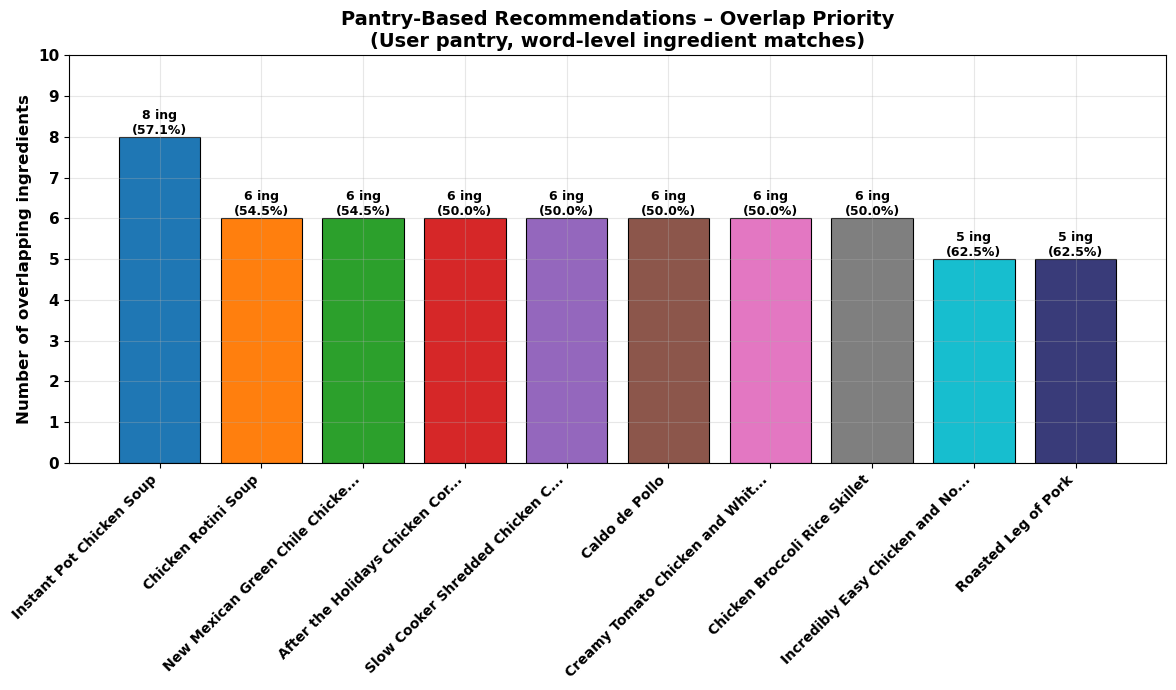

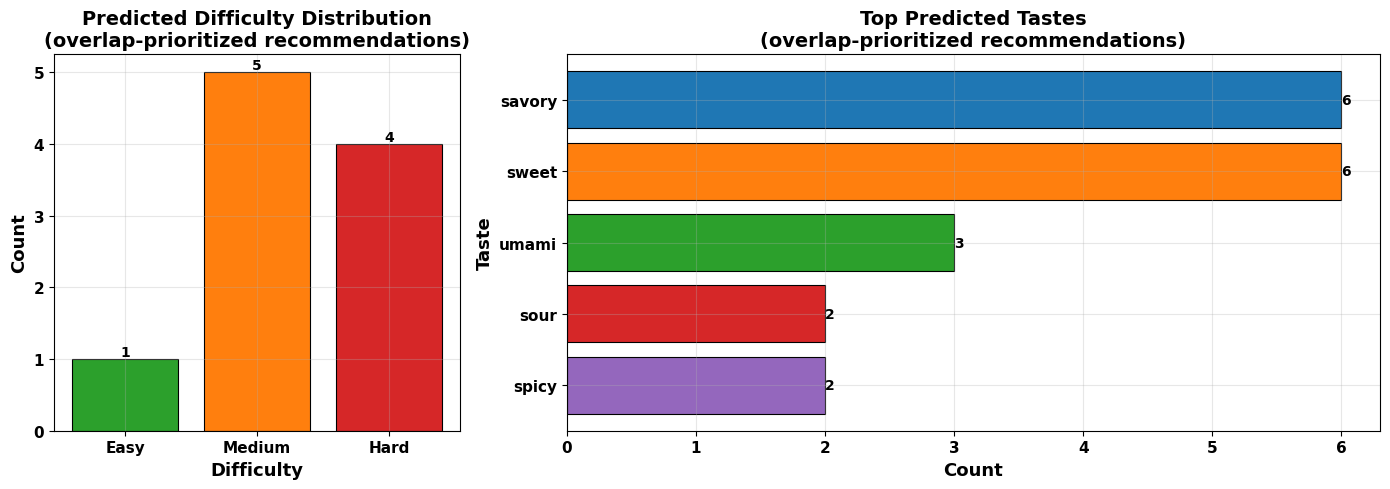

In [35]:
# Cell 32: User pantry with overlap-prioritized recommendations
"""
This cell is similar to Cell 31, but it prioritizes OVERLAP instead of coverage.

Use this when:
  - The goal is to find recipes that use as many of the listed pantry
    ingredients as possible (high overlap), even if some recipe ingredients
    are missing.

Behavior:
  1. Reuses `user_pantry` defined in Cell 31.
  2. Calls the same pantry-based recommender, but:
       - Requests a larger candidate set.
       - Re-sorts the results by overlap (then coverage, then Jaccard).
  3. Attaches predicted difficulty and tastes.
  4. Displays:
       - A table of top overlap-prioritized recipes.
       - A bar chart (Y = overlap count, label = coverage%).
       - Difficulty and taste summary charts for these overlap-prioritized picks.
"""

from collections import Counter
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator

# Sanity checks
required_globals = [
    "difficulty_clf_aug",
    "difficulty_model_aug_df",
    "taste_clf",
    "mlb",
    "recipes_for_recs",
    "X_ingredients",
    "recommend_recipes_for_pantry",
]
for name in required_globals:
    if name not in globals():
        raise NameError(
            f"`{name}` not found. Please run the taste and difficulty modeling cells "
            f"(Cells 15–16 for taste, 19, 23–24 for difficulty), the ingredient "
            f"recommender setup cells (27–29), and Cell 31 before this cell."
        )

if "user_pantry" not in globals():
    raise NameError(
        "`user_pantry` not found. Please define it in Cell 31 (or above) before running this cell."
    )

# -------------------------------------------------------------------
# 1. Get a larger candidate set, then re-sort by overlap
# -------------------------------------------------------------------
CANDIDATE_K = 100   # how many candidates to pull before re-sorting
TOP_K_OVERLAP = 10  # how many to finally show

user_recs_raw, user_vec_overlap = recommend_recipes_for_pantry(
    user_pantry,
    top_k=CANDIDATE_K,
    min_overlap=1,
    verbose=True,
)

if user_recs_raw.empty or user_vec_overlap is None:
    print("No overlap-based recommendations returned. Try adjusting your pantry list or min_overlap.")
else:
    # Re-sort by overlap first, then coverage, then Jaccard, then shorter recipes
    user_recs_o = user_recs_raw.sort_values(
        by=["overlap", "coverage", "jaccard", "recipe_ingredients_count"],
        ascending=[False, False, False, True],
    ).reset_index(drop=True)

    # Keep top overlap-prioritized recipes
    user_recs_o = user_recs_o.head(TOP_K_OVERLAP)

    # -------------------------------------------------------------------
    # 2. Attach predicted difficulty + tastes
    # -------------------------------------------------------------------
    recipe_indices_o = user_recs_o["recipe_idx"].values

    # Difficulty features: text + numeric structure
    X_diff_o = pd.DataFrame(
        {
            "text": recipes_for_recs.loc[recipe_indices_o, "combined_text"].fillna("").values,
            "num_ingredients": recipes_for_recs.loc[recipe_indices_o, "num_ingredients"].values,
            "num_steps": recipes_for_recs.loc[recipe_indices_o, "num_steps"].values,
            "est_prep_time_min": recipes_for_recs.loc[recipe_indices_o, "est_prep_time_min"].values,
            "est_cook_time_min": recipes_for_recs.loc[recipe_indices_o, "est_cook_time_min"].values,
        }
    )

    numeric_features = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
    num_medians = difficulty_model_aug_df[numeric_features].median()
    for col in numeric_features:
        X_diff_o[col] = X_diff_o[col].fillna(num_medians[col])

    pred_diff_labels_o = difficulty_clf_aug.predict(X_diff_o)
    pred_diff_proba_o = difficulty_clf_aug.predict_proba(X_diff_o)
    diff_classes = difficulty_clf_aug.named_steps["logreg"].classes_

    user_recs_o = user_recs_o.copy()
    user_recs_o["pred_difficulty"] = pred_diff_labels_o
    for i, cls in enumerate(diff_classes):
        user_recs_o[f"p_diff_{cls}"] = pred_diff_proba_o[:, i]

    # Taste predictions (multi-label)
    X_taste_o = recipes_for_recs.loc[recipe_indices_o, "combined_text"].fillna("").values
    Y_taste_pred_o = taste_clf.predict(X_taste_o)

    taste_labels = mlb.classes_
    pred_taste_lists_o = []
    for row in Y_taste_pred_o:
        tastes_for_recipe = [lbl for lbl, flag in zip(taste_labels, row) if flag == 1]
        pred_taste_lists_o.append(tastes_for_recipe)

    user_recs_o["pred_tastes"] = pred_taste_lists_o

    print("Top overlap-prioritized recommendations for your pantry\n(with predicted difficulty and tastes):")
    display(
        user_recs_o[
            [
                "recipe_title",
                "difficulty",
                "pred_difficulty",
                "overlap",
                "recipe_ingredients_count",
                "coverage",
                "jaccard",
                "pred_tastes",
            ]
        ]
    )

    # -------------------------------------------------------------------
    # 3. Overlap-focused bar chart
    # -------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 7))

    x_positions = np.arange(len(user_recs_o))
    titles = user_recs_o["recipe_title"].tolist()

    overlap_vals = user_recs_o["overlap"].values
    coverage_vals = user_recs_o["coverage"].values * 100.0  # as %

    y_max = overlap_vals.max() if len(overlap_vals) > 0 else 1.0
    ax.set_ylim(0, y_max * 1.25)

    bars = ax.bar(
        x_positions,
        overlap_vals,
        color=[COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(user_recs_o))],
        edgecolor="k",
        linewidth=0.8,
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [t[:30] + ("..." if len(t) > 30 else "") for t in titles],
        rotation=45,
        ha="right",
        fontsize=10,
        fontweight="bold",
    )

    for bar, ov, cov in zip(bars, overlap_vals, coverage_vals):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            ov,
            f"{int(ov)} ing\n({cov:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    ax.set_ylabel("Number of overlapping ingredients", fontsize=12, fontweight="bold")
    ax.set_title(
        "Pantry-Based Recommendations – Overlap Priority\n"
        "(User pantry, word-level ingredient matches)",
        fontsize=14,
        fontweight="bold",
    )

    for label in ax.get_yticklabels():
        label.set_fontsize(11)
        label.set_fontweight("bold")

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "figure_19_Predicted_Difficulty_Distribution_overlap_prioritized_recommendations.png", dpi=300, bbox_inches="tight")
    plt.show()

    # -------------------------------------------------------------------
    # 4. Summary charts: difficulty distribution + top tastes
    # -------------------------------------------------------------------
    desired_order = ["easy", "medium", "hard"]
    diff_counts_o = user_recs_o["pred_difficulty"].value_counts().reindex(
        desired_order, fill_value=0
    )

    taste_counter_o = Counter(
        taste
        for tastes in user_recs_o["pred_tastes"]
        for taste in tastes
    )
    if len(taste_counter_o) > 0:
        taste_df_o = (
            pd.DataFrame(
                {"taste": list(taste_counter_o.keys()), "count": list(taste_counter_o.values())}
            )
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )
        TOP_TASTES_O = min(8, taste_df_o.shape[0])
        taste_top_o = taste_df_o.head(TOP_TASTES_O)
    else:
        taste_top_o = pd.DataFrame({"taste": [], "count": []})

    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ax_diff = plt.subplot(gs[0])
    ax_taste = plt.subplot(gs[1])

    # --- Left: difficulty distribution ---
    diff_x = np.arange(len(desired_order))
    diff_colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # green, orange, red (no yellow)

    bars_diff = ax_diff.bar(
        diff_x,
        diff_counts_o.values,
        color=diff_colors,
        edgecolor="k",
        linewidth=0.8,
    )

    ax_diff.set_xticks(diff_x)
    ax_diff.set_xticklabels(
        [lbl.capitalize() for lbl in desired_order],
        rotation=0,
        fontsize=11,
        fontweight="bold",
    )

    for bar, cnt in zip(bars_diff, diff_counts_o.values):
        ax_diff.text(
            bar.get_x() + bar.get_width() / 2,
            cnt,
            int(cnt),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax_diff.yaxis.set_major_locator(MaxNLocator(integer=True))

    style_axes(
        ax_diff,
        title="Predicted Difficulty Distribution\n(overlap-prioritized recommendations)",
        xlabel="Difficulty",
        ylabel="Count",
    )

    # --- Right: top tastes (if any) ---
    if not taste_top_o.empty:
        y_pos = np.arange(taste_top_o.shape[0])
        taste_colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(taste_top_o.shape[0])]

        ax_taste.barh(
            y_pos,
            taste_top_o["count"].values,
            color=taste_colors,
            edgecolor="k",
            linewidth=0.8,
        )

        ax_taste.set_yticks(y_pos)
        ax_taste.set_yticklabels(
            taste_top_o["taste"].tolist(),
            fontsize=11,
            fontweight="bold",
        )
        ax_taste.invert_yaxis()  # highest at top

        for y, cnt in zip(y_pos, taste_top_o["count"].values):
            ax_taste.text(
                cnt,
                y,
                int(cnt),
                va="center",
                ha="left",
                fontsize=10,
                fontweight="bold",
            )

        ax_taste.xaxis.set_major_locator(MaxNLocator(integer=True))

        style_axes(
            ax_taste,
            title="Top Predicted Tastes\n(overlap-prioritized recommendations)",
            xlabel="Count",
            ylabel="Taste",
        )
    else:
        ax_taste.text(
            0.5,
            0.5,
            "No tastes predicted for these recipes.",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )
        style_axes(
            ax_taste,
            title="Top Predicted Tastes\n(overlap-prioritized recommendations)",
            xlabel="Count",
            ylabel="Taste",
        )

    plt.tight_layout()
    plt.savefig(FIG_DIR / "figure_20_Top_Predicted_Tastes_overlap_prioritized_recommendations.png", dpi=300, bbox_inches="tight")
    plt.show()

## Question 1: Which ingredients best predict a recipe’s taste profile (sweet, savory, spicy, sour, umami)?

**Short analytical answer**

The taste model shows that taste is strongly encoded in the ingredient list. Using a multi-label logistic regression classifier on TF–IDF features over ingredients + short instructions, the model achieved solid macro- and per-class F1 scores. The most predictive ingredients for each taste align with intuitive culinary patterns:

- **Sweet**: sugar, brown sugar, honey, vanilla, chocolate, syrup, cinnamon, etc.
- **Savory / Umami**: garlic, onion, butter, olive oil, cheese, soy sauce, broth/stock, parmesan.
- **Spicy**: chili powder, cayenne, jalapeño, red pepper flakes, hot sauce, curry powder.
- **Sour**: lemon juice, lime juice, vinegar, yogurt, sour cream, buttermilk.

These ingredients consistently receive the largest positive coefficients for their respective taste labels, and the top-15 token tables capture that each taste is driven by a specific “cluster” of flavoring ingredients rather than neutral staples like flour or water.

**Supporting analysis and visuals**

- **Taste modeling section (Cells ~15–18)**  
  - Data prep for multi-label taste classification.  
  - Logistic regression (or similar linear classifier) trained on TF–IDF of ingredients + instructions.  
  - **Top-15 token tables per taste** derived from model coefficients (strongest positive weights).  
  - Classification metrics (per-taste precision/recall/F1), showing that the ingredient-derived features are predictive of the taste labels.


## Question 2: What recipe features (number of ingredients, number of steps, technique words) are most linked to shorter or longer prep times?

**Short analytical answer**

The structural features of a recipe are clearly related to prep time. Across the dataset, **prep time increases with both the number of ingredients and the number of steps**, and is also correlated with cook time (recipes that take longer to cook often require more preparation work as well). Even without explicitly modeling “technique words,” the counts of ingredients and steps act as strong proxies for recipe complexity: short-prep recipes tend to have fewer ingredients and fewer steps, while long-prep recipes are dense with components and instructions.

The correlation plot in the next cell shows that:
- **Number of steps** usually has the strongest positive correlation with estimated prep time.  
- **Number of ingredients** also positively correlates with prep time, but slightly less than steps.  
- **Cook time** tends to rise along with prep time for many recipes, reflecting that more elaborate dishes are both slower to prep and slower to cook.

These structural signals can be used to identify “quick-and-simple” recipes by looking for low ingredient counts and short instruction sequences.

**Supporting analysis and visuals**

- Earlier EDA (Cells ~10–14): prep/cook time distributions and difficulty vs time boxplots.  
- **New correlation bar chart in the next code cell**: shows how strongly `num_ingredients`, `num_steps`, and `est_cook_time_min` correlate with `est_prep_time_min`.


Correlation with prep time (est_prep_time_min):


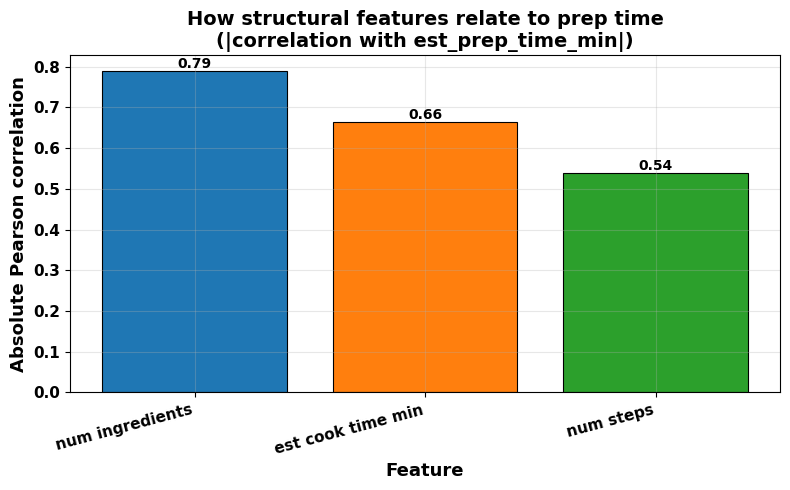

In [36]:
# Q2: Correlation between structural features and prep time
"""
This cell quantifies how structural features relate to prep time.

It computes Pearson correlations between:
  - num_ingredients
  - num_steps
  - est_cook_time_min

and the target:
  - est_prep_time_min

Then it plots the absolute correlation values in a colorful bar chart.
"""

# Make sure we have the main cleaned DataFrame
if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run the earlier preprocessing cells.")

corr_df = recipes_clean.copy()

# Keep rows with all required numeric fields present
cols_needed = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
corr_df = corr_df.dropna(subset=cols_needed)

feature_cols = ["num_ingredients", "num_steps", "est_cook_time_min"]
target_col = "est_prep_time_min"

# Compute correlations
correlations = {}
for col in feature_cols:
    correlations[col] = corr_df[col].corr(corr_df[target_col])

corr_series = pd.Series(correlations).sort_values(key=lambda x: -x.abs())

print("Correlation with prep time (est_prep_time_min):")
display(corr_series.to_frame("corr").style.format({"corr": "{:.3f}"}))

# Plot absolute correlations
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(corr_series))
abs_vals = corr_series.abs().values
colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(corr_series))]

bars = ax.bar(
    x,
    abs_vals,
    color=colors,
    edgecolor="k",
    linewidth=0.8,
)

ax.set_xticks(x)
ax.set_xticklabels(
    [c.replace("_", " ") for c in corr_series.index],
    rotation=15,
    ha="right",
    fontsize=11,
    fontweight="bold",
)

for bar, val in zip(bars, abs_vals):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val,
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

style_axes(
    ax,
    title="How structural features relate to prep time\n(|correlation with est_prep_time_min|)",
    xlabel="Feature",
    ylabel="Absolute Pearson correlation",
)

plt.tight_layout()
plt.savefig(FIG_DIR / "figure_21_How_structural_features_relate_to_prep_time_correlation_with_est_prep_time_min.png", dpi=300, bbox_inches="tight")
plt.show()

## Question 3: What factors explain difficulty level (easy/medium/hard), and how can we spot “beginner-friendly” or “quick-and-simple” recipes?

**Short analytical answer**

Difficulty level is driven by a combination of **structural complexity** and **semantic cues** in the text. The text-only difficulty model already captures a separation between easy, medium, and hard using word patterns in titles, descriptions, and steps (e.g., presence of elaborate techniques, multi-stage instructions, or advanced terms). When structural features—such as number of ingredients, number of steps, and prep/cook times—are added, the **augmented model** improves accuracy and reduces confusion between adjacent classes.

From the structural side, easier recipes tend to:
- Use fewer ingredients and fewer steps.
- Have shorter prep and cook times.
- Avoid long, multi-part instructions.

The augmented difficulty classifier’s confusion matrices show that “easy” recipes are most consistently recognized, while “medium vs hard” confusion is reduced when structural features are included. This aligns with the descriptive statistics and boxplots: recipes tagged “easy” cluster tightly at the low end of ingredient counts and times, making them identifiable as beginner-friendly and quick.

**Supporting analysis and visuals**

- Structural EDA (Cells ~10–14): distributions of `num_ingredients`, `num_steps`, `est_prep_time_min`, and `est_cook_time_min` by difficulty.  
- Difficulty modeling section:
  - **Text-only difficulty model** (Cells ~19–21): baseline performance and confusion matrix.  
  - **Augmented difficulty model** with structural features (Cells ~22–25).  
  - **Side-by-side confusion matrices** comparing text-only vs augmented models (comparison cell after 25).


## Question 4: Can we predict the cuisine type from just the ingredient list and some instructions?

**Short analytical answer**

Cuisine type is partially predictable from the ingredient list and short instructions, but it is a harder task than taste or difficulty. Using a multi-class classifier on TF–IDF features over ingredients + instructions, restricted to the most common cuisines, the model achieves reasonable accuracy: well above random, but lower than the taste and difficulty models.

The confusion matrix in the next cell shows that:

- Distinct cuisines with characteristic ingredients (e.g., those with heavy use of soy sauce, ginger, sesame for East Asian; cumin, coriander, chili for certain Latin/Middle Eastern cuisines; or basil, parmesan, tomato for Italian-style dishes) are better separated.
- More generic or overlapping cuisines are often confused with each other, especially when they share common pantry staples (onion, garlic, butter, generic herbs).
- Overall, the model demonstrates that **ingredients + instructions carry a strong but imperfect signal for cuisine**, and performance could likely be improved with additional features (e.g., regional ingredient tags or longer text context).

**Supporting analysis and visuals**

- Earlier cuisine/taste EDA (Cells ~7–8): heatmaps of primary+secondary tastes vs cuisine, highlighting distinct flavor profiles.  
- **New cuisine classifier evaluation in the next code cell**:
  - Multi-class logistic regression (or similar) on text features for the most frequent cuisines.  
  - Confusion matrix showing which cuisines are easiest vs hardest to distinguish.


Using top 5 cuisines: ['asian', 'european', 'american_region', 'american', 'african']
Samples in subset: 22,415

Cuisine prediction accuracy (top 5 cuisines): 0.875


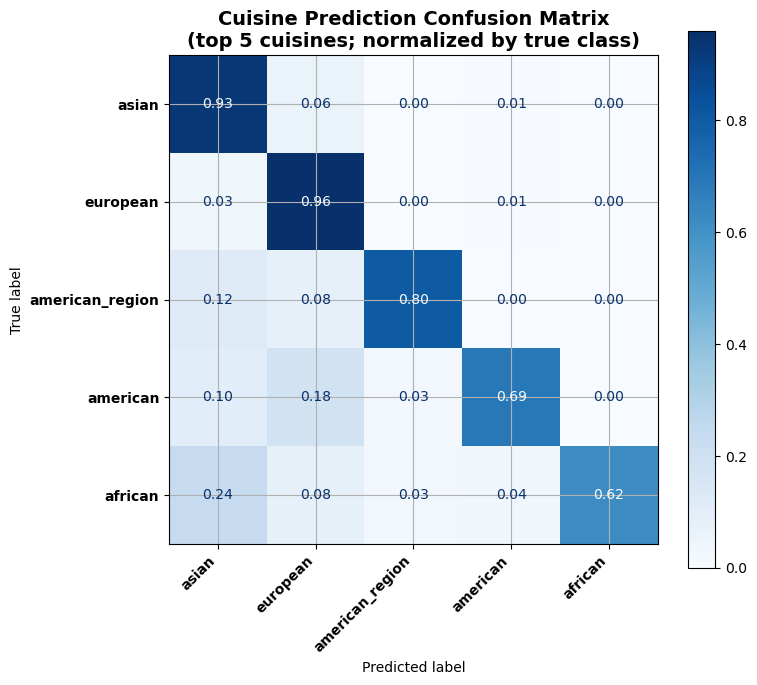

                 precision    recall  f1-score   support

          asian       0.86      0.93      0.89      1540
       european       0.84      0.96      0.90      1496
american_region       0.95      0.80      0.87       654
       american       0.94      0.69      0.79       577
        african       1.00      0.62      0.77       216

       accuracy                           0.87      4483
      macro avg       0.92      0.80      0.84      4483
   weighted avg       0.88      0.87      0.87      4483



In [37]:
# Q4: Predicting cuisine type from ingredients + instructions
"""
This cell trains a simple multi-class classifier to predict cuisine
from text features (ingredients + short instructions) and visualizes
its performance with a confusion matrix.

Steps:
  1. Build/ensure a single 'cuisine' column (from 'cuisine' or 'cuisine_list').
  2. Filter to the most common cuisines (e.g., top 8–10).
  3. Use a text field from ingredients + steps/description.
  4. Train/test split and TF–IDF + logistic regression classifier.
  5. Plot a confusion matrix for the selected cuisines.
"""

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import ast
import numpy as np

if "recipes_clean" not in globals():
    raise NameError("`recipes_clean` not found. Please run the earlier preprocessing cells.")

cuisine_df = recipes_clean.copy()

# Text column used throughout the notebook (title + description + directions)
text_col = "combined_text"
if text_col not in cuisine_df.columns:
    raise KeyError(
        f"Column `{text_col}` not found. Please ensure the text-prep cells "
        f"(for difficulty/taste) have been run so `{text_col}` exists."
    )

# ---------------------------------------------------------------------
# Ensure we have a simple 'cuisine' column
# ---------------------------------------------------------------------
if "cuisine" not in cuisine_df.columns:
    if "cuisine_list" not in cuisine_df.columns:
        raise KeyError(
            "Neither 'cuisine' nor 'cuisine_list' found in the data. "
            "Cannot build a cuisine label for prediction."
        )

    def extract_primary_cuisine(val):
        """
        Parse cuisine_list and return a primary cuisine.
        Handles:
          - actual lists/tuples/ndarrays
          - stringified lists
          - plain strings
          - None / NaN / 'unknown'
        """
        # Case 1: already a list/tuple/array
        if isinstance(val, (list, tuple, np.ndarray)):
            lst = list(val)
        else:
            # Scalar or string
            if val is None:
                return None
            # Floats may be NaN
            if isinstance(val, float):
                if np.isnan(val):
                    return None
            if isinstance(val, str):
                s = val.strip()
                if not s:
                    return None
                # Try to parse stringified list like "['italian', 'mediterranean']"
                if s.startswith("[") and s.endswith("]"):
                    try:
                        parsed = ast.literal_eval(s)
                        if isinstance(parsed, (list, tuple, np.ndarray)):
                            lst = list(parsed)
                        else:
                            lst = [parsed]
                    except Exception:
                        # If parsing fails, treat as a single cuisine string
                        lst = [s]
                else:
                    # Just a plain cuisine string
                    lst = [s]
            else:
                # Some other type; treat as single element
                lst = [val]

        if not lst:
            return None

        primary = lst[0]
        if primary is None:
            return None
        primary = str(primary).strip().lower()
        if primary in ("unknown", "", "none", "nan"):
            return None
        return primary

    cuisine_df["cuisine"] = cuisine_df["cuisine_list"].apply(extract_primary_cuisine)

# Drop rows with missing cuisine or missing text
cuisine_df = cuisine_df.dropna(subset=["cuisine", text_col])

if cuisine_df.empty:
    raise ValueError(
        "No rows with valid `cuisine` and text after processing. "
        "Check that cuisine_list is populated and earlier cleaning steps didn't drop everything."
    )

# ---------------------------------------------------------------------
# Focus on the top N most frequent cuisines to keep the task well-posed
# ---------------------------------------------------------------------
TOP_N_CUISINES = 5
top_cuisines = (
    cuisine_df["cuisine"]
    .value_counts()
    .head(TOP_N_CUISINES)
    .index
    .tolist()
)

cuisine_sub = cuisine_df[cuisine_df["cuisine"].isin(top_cuisines)].copy()

print(f"Using top {len(top_cuisines)} cuisines:", top_cuisines)
print(f"Samples in subset: {cuisine_sub.shape[0]:,}")

X_text = cuisine_sub[text_col].fillna("")
y_cuisine = cuisine_sub["cuisine"].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_text,
    y_cuisine,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_cuisine,
)

cuisine_clf = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                max_features=30000,
                ngram_range=(1, 2),
                min_df=5,
            ),
        ),
        (
            "logreg",
            LogisticRegression(
                max_iter=2000,
                n_jobs=-1,
                # multi_class="auto",  # <- remove this to avoid the FutureWarning
            ),
        ),
    ]
)


cuisine_clf.fit(X_train_c, y_train_c)
y_pred_c = cuisine_clf.predict(X_test_c)

acc = accuracy_score(y_test_c, y_pred_c)
print(f"\nCuisine prediction accuracy (top {len(top_cuisines)} cuisines): {acc:.3f}")

fig, ax = plt.subplots(figsize=(8, 7))

labels = top_cuisines  # explicit, consistent label order

disp = ConfusionMatrixDisplay.from_predictions(
    y_test_c,
    y_pred_c,
    labels=labels,          # <-- enforce this order in the matrix
    display_labels=labels,  # <-- and show the same order on the axes
    normalize="true",
    cmap="Blues",
    values_format=".2f",
    ax=ax,
)


for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(10)
    label.set_fontweight("bold")

ax.set_title(
    "Cuisine Prediction Confusion Matrix\n"
    f"(top {len(top_cuisines)} cuisines; normalized by true class)",
    fontsize=14,
    fontweight="bold",
)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "figure_22_Cuisine_Prediction_Confusion_Matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print(classification_report(y_test_c, y_pred_c, labels=labels))

## Question 5: Given a set of pantry items, how can we rank recipes that use most of what is there while matching target tastes, time, and difficulty?

**Short analytical answer**

The pantry-based recommender uses a multi-step ranking pipeline:

1. **Ingredient matching (coverage & overlap)**  
   Each recipe is represented as a multi-hot ingredient vector. A user pantry is matched to all canonical ingredients that contain the pantry terms (e.g., “zucchini” → “zucchini”, “zucchini patted dry”, etc.). For each recipe, the system computes:
   - **Overlap**: how many of the user’s ingredients appear in the recipe.  
   - **Coverage**: what fraction of the recipe’s ingredients are covered by the pantry.  

2. **Ranking objectives**  
   - **Coverage-prioritized (Cell 31)**: surfaces recipes the user can nearly complete as-is.  
   - **Overlap-prioritized (Cell 32)**: surfaces recipes that use as many of the pantry items as possible (good for using up ingredients).

3. **Taste and difficulty overlays**  
   For each candidate, the taste model predicts a **set of tastes** (sweet, savory, spicy, sour, umami), and the difficulty model predicts **easy/medium/hard**. This allows the system to filter or re-rank recommendations based on a target taste profile and desired difficulty (e.g., “easy & savory recipes that use most of my pantry”). The coverage/overlap bar charts and summary plots show how a given pantry input leads to a cluster of recommended recipes with specific taste and difficulty patterns.

In short, the recommender can support both “what can I cook right now?” (coverage) and “how can I use up these ingredients?” (overlap), while also aligning results with preferred taste, prep time, and difficulty levels.

**Supporting analysis and visuals**

- Ingredient cleaning and canonicalization (Cells ~27–28).  
- Pantry-based recommender core (Cell 29): overlap, coverage, and Jaccard computations.  
- Example pantry analysis with difficulty/taste overlays and PCA neighborhood plot (Cells 30a–30d).  
- User pantry workflows:
  - **Coverage-prioritized recommendations** with difficulty & taste summaries (Cell 31).  
  - **Overlap-prioritized recommendations** with difficulty & taste summaries (Cell 32).


In [38]:
# Cell 33a: Helper functions for interactive GUI
"""
This cell defines helper functions used by the interactive GUI:
  - get_gui_recommendations: run pantry-based recommender, attach difficulty & tastes,
    apply ranking mode and filters.
  - plot_recs_bar: coverage/overlap bar chart depending on ranking mode.
  - plot_pca_neighborhood_gui: PCA neighbor plot for the current recommendations.
  - plot_recs_summary_gui: difficulty and taste summary for the current recommendations.

These functions reuse the models and data prepared earlier in the notebook:
  - recommend_recipes_for_pantry
  - difficulty_clf_aug, difficulty_model_aug_df
  - taste_clf, mlb
  - recipes_for_recs, X_ingredients
"""

from collections import Counter
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA

# Sanity checks: make sure everything we rely on is already defined
required_globals = [
    "recommend_recipes_for_pantry",
    "difficulty_clf_aug",
    "difficulty_model_aug_df",
    "taste_clf",
    "mlb",
    "recipes_for_recs",
    "X_ingredients",
    "COLOR_LIST",
    "RANDOM_SEED",
]
for name in required_globals:
    if name not in globals():
        raise NameError(
            f"`{name}` not found. Please run the earlier modeling and recommender cells "
            f"(taste/difficulty models, ingredient-based recommender) before this GUI cell."
        )


def attach_difficulty_and_tastes(recs_df):
    """
    Given a recommendations DataFrame (from recommend_recipes_for_pantry),
    attach:
      - pred_difficulty
      - p_diff_class per difficulty
      - pred_tastes (list of taste labels)
    and return the augmented DataFrame.
    """
    if recs_df.empty:
        return recs_df

    recs = recs_df.copy()
    recipe_indices = recs["recipe_idx"].values

    # Difficulty features: text + numeric structure
    X_diff = pd.DataFrame(
        {
            "text": recipes_for_recs.loc[recipe_indices, "combined_text"].fillna("").values,
            "num_ingredients": recipes_for_recs.loc[recipe_indices, "num_ingredients"].values,
            "num_steps": recipes_for_recs.loc[recipe_indices, "num_steps"].values,
            "est_prep_time_min": recipes_for_recs.loc[recipe_indices, "est_prep_time_min"].values,
            "est_cook_time_min": recipes_for_recs.loc[recipe_indices, "est_cook_time_min"].values,
        }
    )

    numeric_features = ["num_ingredients", "num_steps", "est_prep_time_min", "est_cook_time_min"]
    num_medians = difficulty_model_aug_df[numeric_features].median()
    for col in numeric_features:
        X_diff[col] = X_diff[col].fillna(num_medians[col])

    pred_diff_labels = difficulty_clf_aug.predict(X_diff)
    pred_diff_proba = difficulty_clf_aug.predict_proba(X_diff)
    diff_classes = difficulty_clf_aug.named_steps["logreg"].classes_

    recs["pred_difficulty"] = pred_diff_labels
    for i, cls in enumerate(diff_classes):
        recs[f"p_diff_{cls}"] = pred_diff_proba[:, i]

    # Taste predictions (multi-label)
    X_taste = recipes_for_recs.loc[recipe_indices, "combined_text"].fillna("").values
    Y_taste_pred = taste_clf.predict(X_taste)

    taste_labels = mlb.classes_
    pred_taste_lists = []
    for row in Y_taste_pred:
        tastes_for_recipe = [lbl for lbl, flag in zip(taste_labels, row) if flag == 1]
        pred_taste_lists.append(tastes_for_recipe)

    recs["pred_tastes"] = pred_taste_lists

    return recs


def get_gui_recommendations(
    pantry_terms,
    rank_mode="coverage",
    min_overlap=1,
    max_prep=None,
    difficulty_filter=None,
    taste_filter=None,
    top_k=10,
):
    """
    Core helper for the GUI.

    Parameters
    ----------
    pantry_terms : list of str
        User's pantry ingredients (already cleaned).
    rank_mode : {"coverage", "overlap"}
        Whether to prioritize recipes by coverage or overlap.
    min_overlap : int
        Minimum number of overlapping ingredients to keep a recipe.
    max_prep : int or None
        Maximum prep time in minutes. If None, no prep-time filter is applied.
    difficulty_filter : list of str or None
        Allowed difficulty labels (e.g., ["easy", "medium"]). If None or empty,
        no difficulty filtering is applied.
    taste_filter : list of str or None
        Preferred tastes. If non-empty, recipes must have at least one of these
        in their predicted taste set.
    top_k : int
        Number of final recipes to return after ranking and filtering.

    Returns
    -------
    recs : DataFrame
        Ranked and filtered recommendations with difficulty/taste overlays.
    user_vec : sparse CSR matrix
        User pantry vector in ingredient space (for PCA visualization).
    """
    if difficulty_filter is None:
        difficulty_filter = []
    if taste_filter is None:
        taste_filter = []

    # Get a reasonably large candidate pool first
    CANDIDATE_K = max(top_k * 4, 40)

    recs_raw, user_vec = recommend_recipes_for_pantry(
        pantry_terms,
        top_k=CANDIDATE_K,
        min_overlap=min_overlap,
        verbose=False,
    )

    if recs_raw.empty or user_vec is None:
        return pd.DataFrame(), None

    # Attach difficulty & tastes
    recs = attach_difficulty_and_tastes(recs_raw)

    # Filter by max prep time (if requested)
    if max_prep is not None:
        recs = recs[
            (recs["est_prep_time_min"].notna())
            & (recs["est_prep_time_min"] <= max_prep)
        ]

    # Filter by difficulty (if requested)
    if difficulty_filter:
        recs = recs[recs["pred_difficulty"].isin(difficulty_filter)]

    # Filter by taste (if requested)
    if taste_filter:
        desired_set = set(taste_filter)
        mask = recs["pred_tastes"].apply(
            lambda ts: len(desired_set.intersection(ts)) > 0
        )
        recs = recs[mask]

    if recs.empty:
        return recs, user_vec

    # Ranking: coverage vs overlap
    if rank_mode == "overlap":
        recs = recs.sort_values(
            by=["overlap", "coverage", "jaccard", "recipe_ingredients_count"],
            ascending=[False, False, False, True],
        )
    else:  # "coverage"
        recs = recs.sort_values(
            by=["coverage", "jaccard", "overlap", "recipe_ingredients_count"],
            ascending=[False, False, False, True],
        )

    recs = recs.reset_index(drop=True).head(top_k)

    return recs, user_vec


def plot_recs_bar(recs_df, rank_mode="coverage"):
    """
    Plot a bar chart of the current recommendations.

    - If rank_mode == "coverage":
        Y-axis = coverage (%), text shows coverage + overlap.
    - If rank_mode == "overlap":
        Y-axis = overlap count, text shows overlap + coverage%.
    """
    if recs_df.empty:
        print("No recommendations to plot.")
        return

    fig, ax = plt.subplots(figsize=(12, 7))

    x_positions = np.arange(len(recs_df))
    titles = recs_df["recipe_title"].tolist()

    coverage_vals = recs_df["coverage"].values * 100.0  # %
    overlap_vals = recs_df["overlap"].values

    if rank_mode == "overlap":
        y_vals = overlap_vals
        y_label = "Number of overlapping ingredients"
        title = "Pantry-Based Recommendations – Overlap Priority"
    else:
        y_vals = coverage_vals
        y_label = "Coverage of recipe ingredients (%)"
        title = "Pantry-Based Recommendations – Coverage Priority"

    y_max = y_vals.max() if len(y_vals) > 0 else 1.0
    ax.set_ylim(0, y_max * 1.25)

    colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(len(recs_df))]
    bars = ax.bar(
        x_positions,
        y_vals,
        color=colors,
        edgecolor="k",
        linewidth=0.8,
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(
        [t[:30] + ("..." if len(t) > 30 else "") for t in titles],
        rotation=45,
        ha="right",
        fontsize=10,
        fontweight="bold",
    )

    for bar, cov, ov, y in zip(bars, coverage_vals, overlap_vals, y_vals):
        if rank_mode == "overlap":
            label_text = f"{int(ov)} ing\n({cov:.1f}%)"
        else:
            label_text = f"{cov:.1f}%\n({int(ov)} ing.)"

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y,
            label_text,
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

    ax.set_ylabel(y_label, fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\n(User pantry, word-level ingredient matches)",
        fontsize=14,
        fontweight="bold",
    )

    for label in ax.get_yticklabels():
        label.set_fontsize(11)
        label.set_fontweight("bold")

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_pca_neighborhood_gui(recs_df, user_vec):
    """
    Plot a PCA neighborhood of the current recommendations vs the user pantry.

    - Points: recipes (colored by coverage).
    - Star: user pantry.
    - Labels: jittered with leader lines, similar to Cell 30c.
    """
    if recs_df.empty or user_vec is None:
        print("No data for PCA neighborhood plot.")
        return

    recipe_indices = recs_df["recipe_idx"].values
    X_recs = X_ingredients[recipe_indices]

    X_recs_dense = X_recs.toarray()
    user_dense = user_vec.toarray()

    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    rec_coords = pca.fit_transform(X_recs_dense)
    user_coord = pca.transform(user_dense)[0]

    fig, ax = plt.subplots(figsize=(9, 7))

    point_size = 140
    scatter = ax.scatter(
        rec_coords[:, 0],
        rec_coords[:, 1],
        s=point_size,
        alpha=0.85,
        edgecolor="k",
        linewidth=0.8,
        c=recs_df["coverage"].values,
        cmap="Blues",
        zorder=3,
    )

    ax.scatter(
        user_coord[0],
        user_coord[1],
        s=260,
        marker="*",
        edgecolor="k",
        linewidth=1.5,
        alpha=0.95,
        color="#d62728",
        label="User pantry",
        zorder=5,
    )

    # Jittered labels with leader lines
    x_vals = rec_coords[:, 0]
    y_vals = rec_coords[:, 1]
    x_range = x_vals.max() - x_vals.min() if len(x_vals) > 1 else 1.0
    y_range = y_vals.max() - y_vals.min() if len(y_vals) > 1 else 1.0

    rng = np.random.default_rng(RANDOM_SEED)
    label_positions = []
    min_dist = 0.06 * np.hypot(x_range, y_range)

    for (x, y, title) in zip(
        rec_coords[:, 0],
        rec_coords[:, 1],
        recs_df["recipe_title"].tolist(),
    ):
        short_title = title[:25] + ("..." if len(title) > 25 else "")

        for _ in range(25):
            dx = (rng.random() - 0.5) * 0.3 * x_range
            dy = (rng.random() - 0.5) * 0.3 * y_range

            lx, ly = x + dx, y + dy

            if all(np.hypot(lx - px, ly - py) >= min_dist for (px, py) in label_positions):
                label_positions.append((lx, ly))
                break
        else:
            lx, ly = x + 0.02 * x_range, y + 0.02 * y_range
            label_positions.append((lx, ly))

        ax.plot(
            [x, lx],
            [y, ly],
            color="gray",
            linewidth=0.8,
            alpha=0.6,
            zorder=2,
        )

        ax.text(
            lx,
            ly,
            short_title,
            fontsize=9,
            fontweight="bold",
            ha="center",
            va="center",
            alpha=0.95,
            zorder=6,
        )

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.ax.set_ylabel("Coverage of recipe ingredients (%)", fontsize=11, fontweight="bold")
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontsize(9)
        tick.set_fontweight("bold")

    style_axes(
        ax,
        title="Ingredient-Space Neighborhood of User Pantry\n(GUI recommendations)",
        xlabel="PCA component 1",
        ylabel="PCA component 2",
    )

    ax.legend(
        loc="upper right",
        borderaxespad=0.5,
        labelspacing=1.0,
        borderpad=0.7,
        prop={"size": 10, "weight": "bold"},
        title_fontsize=11,
    )

    plt.tight_layout()
    plt.show()


def plot_recs_summary_gui(recs_df, title_suffix="GUI recommendations"):
    """
    Plot difficulty distribution and top tastes for the current recommendations.
    """
    if recs_df.empty:
        print("No recommendations to summarize.")
        return

    desired_order = ["easy", "medium", "hard"]
    diff_counts = recs_df["pred_difficulty"].value_counts().reindex(
        desired_order, fill_value=0
    )

    taste_counter = Counter(
        taste
        for tastes in recs_df["pred_tastes"]
        for taste in tastes
    )
    if len(taste_counter) > 0:
        taste_df = (
            pd.DataFrame(
                {"taste": list(taste_counter.keys()), "count": list(taste_counter.values())}
            )
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )
        TOP_TASTES = min(8, taste_df.shape[0])
        taste_top = taste_df.head(TOP_TASTES)
    else:
        taste_top = pd.DataFrame({"taste": [], "count": []})

    fig = plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

    ax_diff = plt.subplot(gs[0])
    ax_taste = plt.subplot(gs[1])

    # Difficulty distribution
    diff_x = np.arange(len(desired_order))
    diff_colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # green, orange, red (no yellow)

    bars_diff = ax_diff.bar(
        diff_x,
        diff_counts.values,
        color=diff_colors,
        edgecolor="k",
        linewidth=0.8,
    )

    ax_diff.set_xticks(diff_x)
    ax_diff.set_xticklabels(
        [lbl.capitalize() for lbl in desired_order],
        rotation=0,
        fontsize=11,
        fontweight="bold",
    )

    for bar, cnt in zip(bars_diff, diff_counts.values):
        ax_diff.text(
            bar.get_x() + bar.get_width() / 2,
            cnt,
            int(cnt),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    ax_diff.yaxis.set_major_locator(MaxNLocator(integer=True))

    style_axes(
        ax_diff,
        title=f"Predicted Difficulty Distribution\n({title_suffix})",
        xlabel="Difficulty",
        ylabel="Count",
    )

    # Top tastes
    if not taste_top.empty:
        y_pos = np.arange(taste_top.shape[0])
        taste_colors = [COLOR_LIST[i % len(COLOR_LIST)] for i in range(taste_top.shape[0])]

        ax_taste.barh(
            y_pos,
            taste_top["count"].values,
            color=taste_colors,
            edgecolor="k",
            linewidth=0.8,
        )

        ax_taste.set_yticks(y_pos)
        ax_taste.set_yticklabels(
            taste_top["taste"].tolist(),
            fontsize=11,
            fontweight="bold",
        )
        ax_taste.invert_yaxis()

        for y, cnt in zip(y_pos, taste_top["count"].values):
            ax_taste.text(
                cnt,
                y,
                int(cnt),
                va="center",
                ha="left",
                fontsize=10,
                fontweight="bold",
            )

        ax_taste.xaxis.set_major_locator(MaxNLocator(integer=True))

        style_axes(
            ax_taste,
            title=f"Top Predicted Tastes\n({title_suffix})",
            xlabel="Count",
            ylabel="Taste",
        )
    else:
        ax_taste.text(
            0.5,
            0.5,
            "No tastes predicted for these recipes.",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )
        style_axes(
            ax_taste,
            title=f"Top Predicted Tastes\n({title_suffix})",
            xlabel="Count",
            ylabel="Taste",
        )

    plt.tight_layout()
    plt.show()


In [39]:
# Patch: safer PCA neighborhood plot for GUI (handles 0 or 1 recipe case)
from sklearn.decomposition import PCA

def plot_pca_neighborhood_gui(recs_df, user_vec):
    """
    Plot a PCA neighborhood of the current recommendations vs the user pantry.

    - Points: recipes (colored by coverage).
    - Star: user pantry.
    - Labels: jittered with leader lines.

    If there are fewer than 2 recipes, PCA is skipped and a message is printed.
    """
    if recs_df is None or recs_df.empty or user_vec is None:
        print("No data for PCA neighborhood plot.")
        return

    # Need at least 2 points for a 2D PCA embedding
    if recs_df.shape[0] < 2:
        print("Not enough recipes to draw PCA neighborhood (need at least 2).")
        return

    recipe_indices = recs_df["recipe_idx"].values
    X_recs = X_ingredients[recipe_indices]

    X_recs_dense = X_recs.toarray()
    user_dense = user_vec.toarray()

    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    rec_coords = pca.fit_transform(X_recs_dense)
    user_coord = pca.transform(user_dense)[0]

    fig, ax = plt.subplots(figsize=(9, 7))

    point_size = 140
    scatter = ax.scatter(
        rec_coords[:, 0],
        rec_coords[:, 1],
        s=point_size,
        alpha=0.85,
        edgecolor="k",
        linewidth=0.8,
        c=recs_df["coverage"].values,
        cmap="Blues",
        zorder=3,
    )

    ax.scatter(
        user_coord[0],
        user_coord[1],
        s=260,
        marker="*",
        edgecolor="k",
        linewidth=1.5,
        alpha=0.95,
        color="#d62728",
        label="User pantry",
        zorder=5,
    )

    # Jittered labels with leader lines
    x_vals = rec_coords[:, 0]
    y_vals = rec_coords[:, 1]
    x_range = x_vals.max() - x_vals.min() if len(x_vals) > 1 else 1.0
    y_range = y_vals.max() - y_vals.min() if len(y_vals) > 1 else 1.0

    rng = np.random.default_rng(RANDOM_SEED)
    label_positions = []
    min_dist = 0.06 * np.hypot(x_range, y_range)

    for (x, y, title) in zip(
        rec_coords[:, 0],
        rec_coords[:, 1],
        recs_df["recipe_title"].tolist(),
    ):
        short_title = title[:25] + ("..." if len(title) > 25 else "")

        for _ in range(25):
            dx = (rng.random() - 0.5) * 0.3 * x_range
            dy = (rng.random() - 0.5) * 0.3 * y_range

            lx, ly = x + dx, y + dy

            if all(np.hypot(lx - px, ly - py) >= min_dist for (px, py) in label_positions):
                label_positions.append((lx, ly))
                break
        else:
            lx, ly = x + 0.02 * x_range, y + 0.02 * y_range
            label_positions.append((lx, ly))

        ax.plot(
            [x, lx],
            [y, ly],
            color="gray",
            linewidth=0.8,
            alpha=0.6,
            zorder=2,
        )

        ax.text(
            lx,
            ly,
            short_title,
            fontsize=9,
            fontweight="bold",
            ha="center",
            va="center",
            alpha=0.95,
            zorder=6,
        )

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.ax.set_ylabel("Coverage of recipe ingredients (%)", fontsize=11, fontweight="bold")
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontsize(9)
        tick.set_fontweight("bold")

    style_axes(
        ax,
        title="Ingredient-Space Neighborhood of User Pantry\n(GUI recommendations)",
        xlabel="PCA component 1",
        ylabel="PCA component 2",
    )

    ax.legend(
        loc="upper right",
        borderaxespad=0.5,
        labelspacing=1.0,
        borderpad=0.7,
        prop={"size": 10, "weight": "bold"},
        title_fontsize=11,
    )

    plt.tight_layout()
    plt.show()


In [40]:
# Cell 33b: Interactive pantry-based recommender GUI + Ingredient Explorer (using ing_mlb)
"""
GUI for pantry-based recommendations with:
  - Pantry text input
  - Ingredient Explorer: search canonical ingredients (from ing_mlb / X_ingredients) and add to pantry
  - Coverage vs overlap ranking
  - Difficulty & taste filters via checkboxes
  - Min-overlap & max-prep sliders
  - Top-K slider
  - "Clear filters" button
  - Results table + bar chart + PCA plot + summaries
  - Clickable recipe dropdown -> full details
"""

from IPython.display import display, clear_output, Markdown
import ast
import numpy as np
import pandas as pd
import re

try:
    import ipywidgets as widgets
    HAVE_WIDGETS_GUI = True
except ImportError:
    HAVE_WIDGETS_GUI = False
    print(
        "ipywidgets is not installed. Install it (e.g. `pip install ipywidgets`) "
        "and enable it in Jupyter to use the interactive GUI."
    )

# Global holder for current recommendations (used by detail viewer)
gui_current_recs = None

if HAVE_WIDGETS_GUI:

    # ---------------------------------------------------------
    # Ingredient vocabulary directly from ing_mlb / X_ingredients
    # ---------------------------------------------------------
    ingredient_vocab_df = None
    if "ing_mlb" in globals() and "X_ingredients" in globals():
        try:
            vocab = np.array(ing_mlb.classes_)
            counts = np.asarray(X_ingredients.sum(axis=0)).ravel()
            ingredient_vocab_df = pd.DataFrame(
                {"ingredient": vocab, "count": counts}
            )
        except Exception as e:
            print("Warning: could not derive ingredient vocabulary from ing_mlb / X_ingredients:", e)
            ingredient_vocab_df = None
    else:
        print(
            "Warning: ing_mlb / X_ingredients not found. "
            "Ingredient search panel will be disabled unless these variables are defined."
        )

    # Options for tastes and difficulty
    all_tastes = list(mlb.classes_)
    taste_options = [t for t in all_tastes if t.lower() != "none"]
    difficulty_options = ["easy", "medium", "hard"]

    # ----------------------------
    # Widgets (wider layout)
    # ----------------------------
    pantry_input = widgets.Textarea(
        value="chicken, garlic, onion, olive oil",
        description="Pantry:",
        placeholder="Enter comma-separated ingredients, e.g.:\nchicken, garlic, soy sauce",
        layout=widgets.Layout(width="100%", height="90px"),
        style={"description_width": "80px"},
    )

    # --- Ingredient Explorer widgets ---
    ingredient_helper_label = widgets.HTML(
        "<b>Ingredient Explorer</b><br>"
        "<span style='font-size: 11px;'>Search canonical ingredients, then add them to the pantry. Additionally, you can type a search term and then write it directly into the pantry; everything that showed up when you typed it will be included as part of that term.</span>",
        layout=widgets.Layout(margin="4px 0 4px 0"),
    )

    ingredient_search_input = widgets.Text(
        value="",
        description="Search:",
        placeholder="e.g. zucchini, garlic, flour...",
        layout=widgets.Layout(width="100%"),
        style={"description_width": "70px"},
    )

    ingredient_results = widgets.SelectMultiple(
        options=[],
        description="Matches:",
        layout=widgets.Layout(width="100%", height="160px"),
        style={"description_width": "70px"},
    )

    ingredient_add_button = widgets.Button(
        description="Add selected to pantry",
        button_style="info",
        icon="plus",
        layout=widgets.Layout(width="100%", height="32px", margin="4px 0 0 0"),
    )

    ingredient_helper_box = widgets.VBox(
        [
            ingredient_helper_label,
            ingredient_search_input,
            ingredient_results,
            ingredient_add_button,
        ],
        # Slightly taller so the button is fully visible
        layout=widgets.Layout(width="100%", max_height="340px", overflow_y="auto"),
    )

    rank_mode_widget = widgets.ToggleButtons(
        options=[
            ("Coverage (cookable)", "coverage"),
            ("Overlap (use pantry)", "overlap"),
        ],
        value="coverage",
        description="Ranking:",
        style={
            "description_width": "80px",
            "button_width": "260px",
        },
        layout=widgets.Layout(width="100%"),
    )

    min_overlap_slider = widgets.IntSlider(
        value=1,
        min=0,
        max=10,
        step=1,
        description="Min overlap:",
        style={"description_width": "110px"},
        layout=widgets.Layout(width="100%"),
    )

    max_prep_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=240,
        step=5,
        description="Max prep (min, 0=any):",
        style={"description_width": "160px"},
        layout=widgets.Layout(width="100%"),
    )

    topk_slider = widgets.IntSlider(
        value=10,
        min=5,
        max=30,
        step=1,
        description="Top K recipes:",
        style={"description_width": "130px"},
        layout=widgets.Layout(width="100%"),
    )

    # Difficulty filter via checkboxes
    difficulty_checkboxes = [
        widgets.Checkbox(
            value=False,  # empty = no filter => "all"
            description=lab.capitalize(),
            indent=False,
        )
        for lab in difficulty_options
    ]
    difficulty_box = widgets.VBox(
        difficulty_checkboxes,
        layout=widgets.Layout(width="260px"),
    )
    difficulty_label = widgets.HTML(
        "<b>Difficulty filter</b><br>"
        "<span style='font-size: 11px;'>Check to restrict; leave all unchecked for all difficulties.</span>",
        layout=widgets.Layout(margin="0 0 4px 0"),
    )

    # Taste filter via checkboxes
    taste_checkboxes = [
        widgets.Checkbox(
            value=False,  # empty = no filter => "all"
            description=lab.capitalize(),
            indent=False,
        )
        for lab in taste_options
    ]
    taste_box = widgets.VBox(
        taste_checkboxes,
        layout=widgets.Layout(width="260px", max_height="220px", overflow_y="auto"),
    )
    taste_label = widgets.HTML(
        "<b>Taste filter</b><br>"
        "<span style='font-size: 11px;'>Check to restrict; leave all unchecked for all tastes.</span>",
        layout=widgets.Layout(margin="8px 0 4px 0"),
    )

    clear_filters_button = widgets.Button(
        description="Clear difficulty/taste filters",
        button_style="",
        icon="eraser",
        layout=widgets.Layout(width="260px", height="32px", margin="8px 0 0 0"),
    )

    run_button = widgets.Button(
        description="Recommend recipes",
        button_style="success",
        icon="search",
        layout=widgets.Layout(width="250px", height="40px"),
    )

    gui_output = widgets.Output()

    # Recipe selector + detail output
    recipe_label = widgets.HTML(
        "<b>Select a recipe to view full description, ingredients, and directions:</b>",
        layout=widgets.Layout(margin="10px 0 4px 0"),
    )

    recipe_select = widgets.Dropdown(
        options=[],
        description="Recipe:",
        style={"description_width": "70px"},
        layout=widgets.Layout(width="70%", margin="0 0 6px 0"),
    )

    recipe_detail_output = widgets.Output()

    # ----------------------------
    # Ingredient Explorer handlers
    # ----------------------------

    def refresh_ingredient_matches(_=None):
        """Update ingredient_results based on current search query."""
        if ingredient_vocab_df is None:
            ingredient_results.options = []
            return

        df = ingredient_vocab_df.copy()
        query = ingredient_search_input.value.strip()

        if query:
            pattern = re.escape(query)
            mask = df["ingredient"].str.contains(pattern, case=False, na=False)
            df = df[mask]

        df = df.sort_values("count", ascending=False).head(100)

        ingredient_results.options = [
            (f"{ing} (n={int(cnt)})", ing)
            for ing, cnt in zip(df["ingredient"], df["count"])
        ]

    ingredient_search_input.observe(refresh_ingredient_matches, names="value")

    def on_add_ingredients_clicked(b):
        """Add selected canonical ingredients to the pantry text box."""
        if ingredient_vocab_df is None:
            return

        selected = list(ingredient_results.value)
        if not selected:
            return

        existing_raw = pantry_input.value or ""
        existing_terms = [
            s.strip()
            for s in existing_raw.replace("\n", ",").split(",")
            if s.strip()
        ]
        existing_lower = {t.lower() for t in existing_terms}

        for ing in selected:
            if ing.lower() not in existing_lower:
                existing_terms.append(ing)
                existing_lower.add(ing.lower())

        pantry_input.value = ", ".join(existing_terms)

    ingredient_add_button.on_click(on_add_ingredients_clicked)

    # Initialize matches once at startup
    refresh_ingredient_matches()

    # ----------------------------
    # Helper: robust base_row lookup
    # ----------------------------

    def get_base_row_for_gui_row(row):
        """
        Robustly find the underlying full recipe row for a GUI recommendation row.

        Priority:
          1. Treat recipe_idx as positional index (iloc) into recipes_for_recs.
          2. Treat recipe_idx as label index (loc) into recipes_for_recs.
          3. Fall back to matching by recipe_title.
          4. Last resort: just return the GUI row itself.
        """
        if "recipes_for_recs" not in globals():
            return row

        gui_title = str(row.get("recipe_title", "")).strip()
        idx_val = row.get("recipe_idx", None)

        candidates = []

        # 1) recipe_idx as positional index
        if idx_val is not None:
            try:
                idx_pos = int(idx_val)
                if 0 <= idx_pos < len(recipes_for_recs):
                    cand = recipes_for_recs.iloc[idx_pos]
                    candidates.append(cand)
            except Exception:
                pass

        # 2) recipe_idx as label index
        if idx_val is not None:
            try:
                if isinstance(idx_val, float) and not np.isnan(idx_val):
                    idx_lbl = int(idx_val)
                else:
                    idx_lbl = idx_val

                if idx_lbl in recipes_for_recs.index:
                    cand = recipes_for_recs.loc[idx_lbl]
                    candidates.append(cand)
            except Exception:
                pass

        # 3) title-based matching
        if gui_title and "recipe_title" in recipes_for_recs.columns:
            matches = recipes_for_recs[recipes_for_recs["recipe_title"] == gui_title]
            for _, cand in matches.iterrows():
                candidates.append(cand)

        gui_title_norm = gui_title.lower()
        for cand in candidates:
            cand_title = str(cand.get("recipe_title", "")).strip().lower()
            if gui_title_norm and cand_title == gui_title_norm:
                return cand

        if candidates:
            return candidates[0]

        return row

    # ----------------------------
    # Helper: show recipe details
    # ----------------------------

    def show_recipe_details(selected_index):
        """Render full details for the selected recipe index in gui_current_recs."""
        recipe_detail_output.clear_output()
        with recipe_detail_output:
            if selected_index is None:
                print("Select a recipe to view full details.")
                return

            if gui_current_recs is None or gui_current_recs.empty:
                print("No recommendations to show yet.")
                return

            if selected_index not in gui_current_recs.index:
                print("Invalid selection.")
                return

            row = gui_current_recs.loc[selected_index]
            base_row = get_base_row_for_gui_row(row)

            title = str(base_row.get("recipe_title", "Unknown recipe"))
            difficulty_val = row.get("pred_difficulty", base_row.get("difficulty", "unknown"))
            tastes_val = row.get("pred_tastes", [])
            cuisine_val = base_row.get("cuisine", "unknown")
            prep = base_row.get("est_prep_time_min", None)
            cook = base_row.get("est_cook_time_min", None)

            header_lines = [f"### {title}"]
            meta_bits = []

            if cuisine_val and cuisine_val != "unknown":
                meta_bits.append(f"**Cuisine:** {cuisine_val}")
            if difficulty_val:
                meta_bits.append(f"**Predicted difficulty:** {difficulty_val}")
            if tastes_val:
                meta_bits.append("**Predicted tastes:** " + ", ".join(map(str, tastes_val)))
            if prep is not None and not pd.isna(prep):
                meta_bits.append(f"**Est. prep time:** {int(prep)} min")
            if cook is not None and not pd.isna(cook):
                meta_bits.append(f"**Est. cook time:** {int(cook)} min")

            if meta_bits:
                header_lines.append("  \n".join(meta_bits))

            # ------- Ingredients -------
            ingred = None
            for cand in ["ingredients", "canonical_ingredients", "clean_ingredients", "ingredients_list"]:
                if cand in base_row.index:
                    val = base_row[cand]
                    if val is None:
                        continue
                    if isinstance(val, (list, tuple, np.ndarray)):
                        if len(val) == 0:
                            continue
                        ingred = val
                        break
                    if isinstance(val, float) and np.isnan(val):
                        continue
                    s = str(val).strip()
                    if not s:
                        continue
                    ingred = val
                    break

            # ------- Directions -------
            steps_val = None
            for cand in ["directions", "steps", "instructions", "short_directions"]:
                if cand in base_row.index:
                    val = base_row[cand]
                    if val is None:
                        continue
                    if isinstance(val, (list, tuple, np.ndarray)):
                        if len(val) == 0:
                            continue
                        steps_val = val
                        break
                    if isinstance(val, float) and np.isnan(val):
                        continue
                    s = str(val).strip()
                    if not s:
                        continue
                    steps_val = val
                    break

            # ------- Description -------
            desc = base_row.get("description", None)

            body = ""

            if desc:
                body += "\n\n**Description**\n\n" + str(desc)

            if ingred is not None:
                if isinstance(ingred, (list, tuple, np.ndarray)):
                    ingred_list = list(ingred)
                else:
                    try:
                        if isinstance(ingred, str) and ingred.strip().startswith("["):
                            parsed = ast.literal_eval(ingred)
                            if isinstance(parsed, (list, tuple, np.ndarray)):
                                ingred_list = list(parsed)
                            else:
                                ingred_list = [parsed]
                        else:
                            ingred_list = [str(ingred)]
                    except Exception:
                        ingred_list = [str(ingred)]
                body += "\n\n**Ingredients**\n\n" + "\n".join(f"- {x}" for x in ingred_list)

            if steps_val is not None:
                if isinstance(steps_val, (list, tuple, np.ndarray)):
                    steps_list = list(steps_val)
                else:
                    try:
                        if isinstance(steps_val, str) and steps_val.strip().startswith("["):
                            parsed = ast.literal_eval(steps_val)
                            if isinstance(parsed, (list, tuple, np.ndarray)):
                                steps_list = list(parsed)
                            else:
                                steps_list = [parsed]
                        else:
                            steps_list = [s for s in str(steps_val).split("\n") if s.strip()]
                    except Exception:
                        steps_list = [str(steps_val)]

                body += "\n\n**Directions**\n\n" + "\n".join(
                    f"{i+1}. {s}" for i, s in enumerate(steps_list)
                )

            display(Markdown("\n".join(header_lines) + (body if body else "")))

    def on_recipe_change(change):
        if change["name"] != "value":
            return
        show_recipe_details(change["new"])

    recipe_select.observe(on_recipe_change, names="value")

    # ----------------------------
    # Callbacks for buttons
    # ----------------------------

    def on_clear_filters_clicked(b):
        """Reset difficulty & taste filters to 'all' (internally: empty = no filter)."""
        for cb in difficulty_checkboxes:
            cb.value = False
        for cb in taste_checkboxes:
            cb.value = False

    clear_filters_button.on_click(on_clear_filters_clicked)

    def on_run_clicked(b):
        global gui_current_recs
        with gui_output:
            clear_output()

            # Parse pantry
            raw = pantry_input.value
            pantry_terms = [s.strip() for s in raw.replace("\n", ",").split(",") if s.strip()]
            if not pantry_terms:
                print("Please enter at least one pantry ingredient.")
                return

            rank_mode = rank_mode_widget.value
            min_overlap = min_overlap_slider.value
            max_prep_val = max_prep_slider.value
            max_prep = max_prep_val if max_prep_val > 0 else None

            # Collect filters from checkboxes
            diff_filter = [cb.description.lower() for cb in difficulty_checkboxes if cb.value]
            taste_filter = [cb.description.lower() for cb in taste_checkboxes if cb.value]

            top_k = topk_slider.value

            print("Pantry terms:", pantry_terms)
            print(
                f"Ranking: {rank_mode} | Min overlap: {min_overlap} | "
                f"Max prep: {max_prep if max_prep is not None else 'no limit'}"
            )
            print(f"Difficulty filter: {diff_filter if diff_filter else 'all'}")
            print(f"Taste filter: {taste_filter if taste_filter else 'all'}")
            print()

            recs_gui, user_vec_gui = get_gui_recommendations(
                pantry_terms,
                rank_mode=rank_mode,
                min_overlap=min_overlap,
                max_prep=max_prep,
                difficulty_filter=diff_filter,
                taste_filter=taste_filter,
                top_k=top_k,
            )

            if recs_gui is None or recs_gui.empty:
                print("No recipes matched these settings. Try relaxing the filters.")
                gui_current_recs = None
                recipe_select.options = []
                recipe_detail_output.clear_output()
                return

            # Keep a clean 0..N-1 index for GUI use
            gui_current_recs = recs_gui.reset_index(drop=True)

            # Display a compact table
            cols_to_show = [
                "recipe_title",
                "pred_difficulty",
                "pred_tastes",
                "coverage",
                "overlap",
                "est_prep_time_min",
                "est_cook_time_min",
                "cuisine",
            ]
            cols_to_show = [c for c in cols_to_show if c in gui_current_recs.columns]

            print("Top ranked recipes:")
            display(
                gui_current_recs[cols_to_show].style.format(
                    {
                        "coverage": "{:.2f}",
                        "est_prep_time_min": "{:.0f}",
                        "est_cook_time_min": "{:.0f}",
                    }
                )
            )

            # Plots
            plot_recs_bar(gui_current_recs, rank_mode=rank_mode)
            plot_pca_neighborhood_gui(gui_current_recs, user_vec_gui)
            suffix = f"GUI recommendations ({rank_mode} mode)"
            plot_recs_summary_gui(gui_current_recs, title_suffix=suffix)

            # Update recipe selector options for detail view
            recipe_options = [
                (f"{i+1}. {title}", i)
                for i, title in enumerate(gui_current_recs["recipe_title"].tolist())
            ]
            recipe_select.options = recipe_options

            if recipe_options:
                recipe_select.value = recipe_options[0][1]
            else:
                recipe_detail_output.clear_output()

    run_button.on_click(on_run_clicked)

    # ----------------------------
    # Layout (avoid horizontal scroll)
    # ----------------------------
    controls_left = widgets.VBox(
        [
            pantry_input,
            ingredient_helper_box,
            rank_mode_widget,
            topk_slider,
            min_overlap_slider,
            max_prep_slider,
        ],
        layout=widgets.Layout(width="52%", overflow_x="hidden"),
    )

    filters_box = widgets.VBox(
        [
            difficulty_label,
            difficulty_box,
            taste_label,
            taste_box,
            clear_filters_button,
        ],
        layout=widgets.Layout(width="260px"),
    )

    controls_right = widgets.VBox(
        [
            filters_box,
        ],
        layout=widgets.Layout(width="46%", overflow_x="hidden"),
    )

    controls_box = widgets.HBox(
        [controls_left, controls_right],
        layout=widgets.Layout(width="100%", overflow_x="hidden"),
    )

    run_box = widgets.HBox(
        [run_button],
        layout=widgets.Layout(justify_content="flex-start", padding="10px 0 0 0"),
    )

    detail_box = widgets.VBox(
        [
            recipe_label,
            recipe_select,
            recipe_detail_output,
        ],
        layout=widgets.Layout(width="100%", padding="10px 0 0 0"),
    )

    display(controls_box, run_box, gui_output, detail_box)


Output()